In [436]:
import math
import random
import pygame
import sys
import numpy as np
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data, InMemoryDataset, download_url, TemporalData
import torch.nn as nn
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from torch_geometric.nn import ChebConv
import torch.optim as optim


## Converting CSV To Input For Our Model

### Grabbing Our CSV And Converting To DataFrame

In [603]:
path_to_sim_edges = '../data/simulation_edges.csv'
sim_edges_df = pd.read_csv(path_to_sim_edges)

path_to_sim = '../data/simulation.csv'
sim_df = pd.read_csv(path_to_sim)


sim_edges_df.head(5)

frame_rate = 2

sim_edges_df= sim_edges_df[sim_edges_df['Timestep']% frame_rate== 0]
sim_df= sim_df[sim_df['Timestep']% frame_rate== 0]

sim_edges_df_final = sim_edges_df[sim_edges_df['Simulation'] == 0]
sim_df_final = sim_df[sim_df['Simulation'] == 0]

testing_edges = sim_edges_df[sim_edges_df['Simulation'] == 1]
testing = sim_df[sim_df['Simulation'] == 1]

total_length = len(testing)
total_length_edges = len(testing_edges)

subset_length = math.ceil(total_length * 0.2)  # Get 20% of the total data
subset_length_edges = math.ceil(total_length_edges * 0.2)  # Get 20% of the total data

testing_edges_20 = testing_edges[:subset_length_edges]
testing_20 = testing[:subset_length]







x            y        dx        dy  Boids  Simulation  \
100000   619.460650   189.773236 -1.660158  1.155650      0           1   
100001  1898.018355  1301.545636  4.220119 -3.068603      1           1   
100002  1260.467286  1176.804588  3.127156  1.716963      2           1   
100003   497.631837  1955.525737 -3.278662 -0.975349      3           1   
100004   310.270335   456.126312  1.705934  4.355292      4           1   
...             ...          ...       ...       ...    ...         ...   
119995   811.270201  1148.841227 -5.507173  1.067961     95           1   
119996  1072.305840   293.985521 -6.225704 -7.512285     96           1   
119997   323.493421  1434.813483 -9.531644  3.024526     97           1   
119998   904.288816   567.359874 -2.963143 -0.882621     98           1   
119999   811.576362  1209.144149 -4.772537  2.044461     99           1   

        Timestep  
100000         0  
100001         0  
100002         0  
100003         0  
100004         0  
...          ...  
119995       199  
119996       199  
119997       199  
119998       199  
119999       199  

[20000 rows x 7 columns]

In [600]:
# import torch
# import numpy as np
# from torch_geometric.data import Data

# def calculate_edge_attributes(node_features, edge_index, max_distance=1.0):
#     """
#     Calculate edge attributes based on the distance between nodes.
    
#     Parameters:
#     - node_features (Tensor): Tensor of shape [num_nodes, num_features] containing the node features.
#     - edge_index (Tensor): Tensor of shape [2, num_edges] containing the edge indices.
#     - max_distance (float): Maximum distance to normalize the edge weights.

#     Returns:
#     - edge_attr (Tensor): Tensor of shape [num_edges, 1] containing the edge weights.
#     """
#     edge_attrs = []
#     for i, j in edge_index.T:
#         node_i = node_features[i]
#         node_j = node_features[j]
#         distance = torch.norm(node_i[:2] - node_j[:2])  # Assuming the first two features are x and y coordinates
#         edge_weight = 1.0 / (distance + 1e-6)  # Avoid division by zero
#         edge_attrs.append(edge_weight)

#     edge_attrs = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)
#     edge_attrs = edge_attrs / max_distance  # Normalize edge weights
#     return edge_attrs

# # Example usage
# node_features = torch.tensor([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]], dtype=torch.float)
# edge_index = torch.tensor([[0, 1, 2, 3], [1, 0, 3, 2]], dtype=torch.long)
# edge_attr = calculate_edge_attributes(node_features, edge_index)

# print(edge_attr)


### EDA Of Dataset

In [521]:
# TODO

### Converting DataFrame To Data Object From Pytorch Geometric

In [581]:
def compute_edge_features(boids, edge_index):
    num_edges = edge_index.shape[1]
    edge_features = torch.zeros(num_edges, dtype=torch.float)
    
    for i in range(num_edges):
        boid_i = edge_index[0, i].item()
        boid_j = edge_index[1, i].item()
        
        x_i, y_i = boids[boid_i].x, boids[boid_i].y
        x_j, y_j = boids[boid_j].x, boids[boid_j].y
        
        # Compute Euclidean distance
        distance = np.sqrt((x_i - x_j) ** 2 + (y_i - y_j) ** 2)
        
        # Inverse distance as interaction strength (higher interaction for closer boids)
        # Add a small value to avoid division by zero
        edge_features[i] = 1.0 / (distance + 1e-6)
    
    return edge_features



def toDataGraph(sim_df, sim_edges_df, node_features_names):
    
    """
    Converts simulation data into a PyTorch Geometric Data object.

    Parameters:
    - sim_df (DataFrame): DataFrame containing node features for a specific simulation and timestep.
    - sim_edges_df (DataFrame): DataFrame containing edge information for the simulation.
    - node_features_names (list of str): Names of the columns in sim_df that are node features.

    Returns:
    - Data: A PyTorch Geometric Data object representing the graph for the simulation.
    """
    # Convert node features and edge information into tensors
    node_features = torch.tensor(sim_df[node_features_names].to_numpy(), dtype=torch.float)
    edge_index = torch.tensor(sim_edges_df[['Boid_i', 'Boid_j']].to_numpy().T, dtype=torch.long)
    # edge_attributes = torch.tensor(np.ones((sim_edges_df.shape[0], 1)), dtype=torch.float)

    # Create and return the Data object
    graph = Data(x=node_features, edge_index=edge_index)
    return graph

def toDataGraph(sim_df, sim_edges_df, node_features_names):
    """
    Converts simulation data into a PyTorch Geometric Data object with edge attributes.

    Parameters:
    - sim_df (DataFrame): DataFrame containing node features for a specific simulation and timestep.
    - sim_edges_df (DataFrame): DataFrame containing edge information for the simulation.
    - node_features_names (list of str): Names of the columns in sim_df that are node features.

    Returns:
    - Data: A PyTorch Geometric Data object representing the graph for the simulation.
    """
    node_features = torch.tensor(sim_df[node_features_names].to_numpy(), dtype=torch.float)
    edge_index = torch.tensor(sim_edges_df[['Boid_i', 'Boid_j']].to_numpy().T, dtype=torch.long)
    
    # Calculate edge attributes based on distance
    # edge_attr = calculate_edge_attributes(node_features, edge_index)
    
    # Create and return the Data object
    graph = Data(x=node_features, edge_index=edge_index) #edge_weight=edge_attr)
    return graph

def allDataGraph(sim_df, sim_edges_df):
    """
    Generates a list of PyTorch Geometric Data objects for each simulation and timestep.

    Parameters:
    - sim_df (DataFrame): DataFrame containing node features for all simulations and timesteps.
    - sim_edges_df (DataFrame): DataFrame containing edge information for all simulations and timesteps.

    Returns:
    - list of Data: A list of PyTorch Geometric Data objects, one for each simulation and timestep.
    """
    # Group the data by simulation and timestep
    sim_gb_df = sim_df.groupby(['Timestep', 'Simulation'])
    sim_edges_gb_df = sim_edges_df.groupby(['Timestep', 'Simulation'])

    graphs = []
    # Iterate over each group and convert to a Data object
    for key, _ in sim_gb_df:
        curr_sim_df = sim_gb_df.get_group(key)
        curr_sim_edges_df = sim_edges_gb_df.get_group(key)
        curr_graph = toDataGraph(curr_sim_df, curr_sim_edges_df, ['x', 'y',"Boids"])#,'dx', 'dy'])
        graphs.append(curr_graph)

    return graphs

# Example usage
graphs = allDataGraph(sim_df, sim_edges_df)

## TODO: NEXT STEP MAKES CLASS THAT GIVEN THE SIMULATION DATAFRAME AND SIMULATION EDGES DATAFRAME CREATES A DATASET OBJECT

class CustomDataset(Dataset):
    def __init__(self, sim_df, sim_edges_df):
        super(CustomDataset).__init__()
        self.all_graphs = allDataGraph(sim_df, sim_edges_df)
        self.sequences = [graphs[i-5:i-1] for i in range(5, len(self.all_graphs)+1)]
        self.labels = [graphs[i-1] for i in range(5, len(self.all_graphs)+1)]
        self.len = len(self.labels)
    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]
    def __len__(self):
        return self.len

dataset = CustomDataset(sim_df_final, sim_edges_df_final)
dataset_testing = CustomDataset(testing_20,testing_edges_20)


In [604]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from torch_geometric.data import Data
from scipy.spatial.distance import pdist, squareform

def compute_edge_features(node_features, edge_index):
    num_edges = edge_index.shape[1]
    edge_features = torch.zeros(num_edges, dtype=torch.float)
    
    for i in range(num_edges):
        boid_i = edge_index[0, i].item()
        boid_j = edge_index[1, i].item()
        
        x_i, y_i = node_features[boid_i, 0].item(), node_features[boid_i, 1].item()
        x_j, y_j = node_features[boid_j, 0].item(), node_features[boid_j, 1].item()
        
        # Compute Euclidean distance
        distance = np.sqrt((x_i - x_j) ** 2 + (y_i - y_j) ** 2)
        
        # Inverse distance as interaction strength (higher interaction for closer boids)
        # Add a small value to avoid division by zero
        edge_features[i] = 1.0 / (distance + 1e-6)
    
    return edge_features

def toDataGraph(sim_df, sim_edges_df, node_features_names):
    node_features = torch.tensor(sim_df[node_features_names].to_numpy(), dtype=torch.float)
    edge_index = torch.tensor(sim_edges_df[['Boid_i', 'Boid_j']].to_numpy().T, dtype=torch.long)
    
    # Calculate edge attributes based on distance
    edge_attr = compute_edge_features(node_features, edge_index)
    
    # Create and return the Data object
    graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    return graph

def allDataGraph(sim_df, sim_edges_df):
    sim_gb_df = sim_df.groupby(['Timestep', 'Simulation'])
    sim_edges_gb_df = sim_edges_df.groupby(['Timestep', 'Simulation'])

    graphs = []
    for key, _ in sim_gb_df:
        curr_sim_df = sim_gb_df.get_group(key)
        curr_sim_edges_df = sim_edges_gb_df.get_group(key)
        curr_graph = toDataGraph(curr_sim_df, curr_sim_edges_df, ['x', 'y', 'Boids'])
        graphs.append(curr_graph)

    return graphs

class CustomDataset(Dataset):
    def __init__(self, sim_df, sim_edges_df):
        self.all_graphs = allDataGraph(sim_df, sim_edges_df)
        self.sequences = [self.all_graphs[i-5:i-1] for i in range(5, len(self.all_graphs)+1)]
        self.labels = [self.all_graphs[i-1] for i in range(5, len(self.all_graphs)+1)]
        self.len = len(self.labels)
    
    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]
    
    def __len__(self):
        return self.len
dataset = CustomDataset(sim_df, sim_edges_df)

dataset_testing = CustomDataset(testing_20, testing_edges_20)


In [620]:
dataset_testing[1]

([Data(x=[50, 3], edge_index=[2, 8], edge_attr=[8]),
  Data(x=[50, 3], edge_index=[2, 9], edge_attr=[9]),
  Data(x=[50, 3], edge_index=[2, 9], edge_attr=[9]),
  Data(x=[50, 3], edge_index=[2, 8], edge_attr=[8])],
 Data(x=[50, 3], edge_index=[2, 9], edge_attr=[9]))

In [523]:
dataset[1]

([Data(x=[100, 3], edge_index=[2, 20]),
  Data(x=[100, 3], edge_index=[2, 24]),
  Data(x=[100, 3], edge_index=[2, 20]),
  Data(x=[100, 3], edge_index=[2, 24])],
 Data(x=[100, 3], edge_index=[2, 18]))

In [551]:
# adds more features to nodes
import torch
import pandas as pd
from torch_geometric.data import Data

def compute_heading_angles(velocity):
    return torch.atan2(velocity[:, 1], velocity[:, 0])

def compute_relative_features(data):
    num_boids = data.shape[0]
    x_y = data[:, :2]
    dx_dy = data[:, 2:4]
    
    # Compute pairwise distances
    dist_matrix = torch.cdist(x_y, x_y)
    
    # Compute relative positions
    relative_positions = x_y.unsqueeze(1) - x_y.unsqueeze(0)
    
    # Compute relative velocities
    relative_velocities = dx_dy.unsqueeze(1) - dx_dy.unsqueeze(0)
    
    return dist_matrix, relative_positions, relative_velocities

def compute_interaction_features(dist_matrix, threshold):
    num_neighbors = (dist_matrix < threshold).sum(dim=1)
    return num_neighbors

def add_timestep_feature(data):
    return data[:, 6].unsqueeze(1)  # Assuming timestep is in the 7th column

def generate_features(data, threshold=75):
    num_boids = data.shape[0]
    x_y = data[:, :2]
    dx_dy = data[:, 2:4]
    
    # Compute additional features
    dist_matrix, relative_positions, relative_velocities = compute_relative_features(data)
    heading_angles = compute_heading_angles(dx_dy)
    num_neighbors = compute_interaction_features(dist_matrix, threshold)
    timesteps = add_timestep_feature(data)
    
    # Concatenate all features
    features = torch.cat([x_y, dx_dy, heading_angles.unsqueeze(1), num_neighbors.unsqueeze(1), timesteps], dim=1)
    return features

def toDataGraph(sim_df, sim_edges_df, threshold=75):
    """
    Converts simulation data into a PyTorch Geometric Data object with additional features.
    """
    # Convert node features and edge information into tensors
    node_features = generate_features(torch.tensor(sim_df.to_numpy(), dtype=torch.float32), threshold)
    edge_index = torch.tensor(sim_edges_df[['Boid_i', 'Boid_j']].to_numpy().T, dtype=torch.long)
    
    # Create and return the Data object
    graph = Data(x=node_features, edge_index=edge_index)
    return graph

def allDataGraph(sim_df, sim_edges_df):
    """
    Generates a list of PyTorch Geometric Data objects for each simulation and timestep.
    """
    # Group the data by simulation and timestep
    sim_gb_df = sim_df.groupby(['Timestep', 'Simulation'])
    sim_edges_gb_df = sim_edges_df.groupby(['Timestep', 'Simulation'])
    
    graphs = []
    # Iterate over each group and convert to a Data object
    for key, _ in sim_gb_df:
        curr_sim_df = sim_gb_df.get_group(key)
        curr_sim_edges_df = sim_edges_gb_df.get_group(key)
        curr_graph = toDataGraph(curr_sim_df, curr_sim_edges_df)
        graphs.append(curr_graph)
    
    return graphs

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, sim_df, sim_edges_df, sequence_length=5):
        super(CustomDataset, self).__init__()
        self.all_graphs = allDataGraph(sim_df, sim_edges_df)
        self.sequence_length = sequence_length
        self.sequences = [self.all_graphs[i - sequence_length:i] for i in range(sequence_length, len(self.all_graphs))]
        self.labels = [self.all_graphs[i] for i in range(sequence_length, len(self.all_graphs))]
        self.len = len(self.labels)

    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]

    def __len__(self):
        return self.len


# Example usage
dataset = CustomDataset(sim_df_final, sim_edges_df_final)
dataset_testing = CustomDataset(testing_20,testing_edges_20)


In [552]:
dataset_testing[1]

([Data(x=[100, 7], edge_index=[2, 20]),
  Data(x=[100, 7], edge_index=[2, 18]),
  Data(x=[100, 7], edge_index=[2, 18]),
  Data(x=[100, 7], edge_index=[2, 18]),
  Data(x=[100, 7], edge_index=[2, 21])],
 Data(x=[100, 7], edge_index=[2, 22]))

## GconvGRU

In [525]:
class GConvGRU(torch.nn.Module):
    r"""An implementation of the Chebyshev Graph Convolutional Gated Recurrent Unit
    Cell. For details see this paper: `"Structured Sequence Modeling with Graph
    Convolutional Recurrent Networks." <https://arxiv.org/abs/1612.07659>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):

            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`

            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`

            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(GConvGRU, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.normalization = normalization
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_z = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_r = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_h = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H, lambda_max):
        Z = self.conv_x_z(X, edge_index, edge_weight, lambda_max=lambda_max)
        Z = Z + self.conv_h_z(H, edge_index, edge_weight, lambda_max=lambda_max)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H, lambda_max):
        R = self.conv_x_r(X, edge_index, edge_weight, lambda_max=lambda_max)
        R = R + self.conv_h_r(H, edge_index, edge_weight, lambda_max=lambda_max)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R, lambda_max):
        H_tilde = self.conv_x_h(X, edge_index, edge_weight, lambda_max=lambda_max)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index, edge_weight, lambda_max=lambda_max)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
        lambda_max: torch.Tensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.
            * **lambda_max** *(PyTorch Tensor, optional but mandatory if normalization is not sym)* - Largest eigenvalue of Laplacian.


        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        #print("Forward of GRU", edge_weight)
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H, lambda_max)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H, lambda_max)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R, lambda_max)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

## Encoder and Decoder with dropout layers 

In [634]:
class Encoder(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2, dropout_rate=0.5):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(node_feature_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, input_recurrent_dim)
        self.reccurent = GConvGRU(input_recurrent_dim, output_recurrent_dim, k)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, edge_index, H=None):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        encoder_h = self.reccurent(X=x, edge_index=edge_index, H=H)
        return encoder_h

class Decoder(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2, dropout_rate=0.5):
        super(Decoder, self).__init__()
        self.recurrent = GConvGRU(input_recurrent_dim, output_recurrent_dim, k)
        self.conv2 = GCNConv(output_recurrent_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, node_feature_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, h, edge_index, H=None):
        decoder_h = self.recurrent(X=h, edge_index=edge_index, H=H)
        x = torch.relu(decoder_h)
        x = self.dropout(x)  # Apply dropout
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.conv1(x, edge_index)
        return x, decoder_h


## Testing Encoder Decoder

In [638]:
class Encoder(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2, dropout_rate=0.5):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(node_feature_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)  # Additional Conv layer
        self.conv5 = GCNConv(hidden_dim, input_recurrent_dim)  # Additional Conv layer
        self.recurrent = GConvGRU(input_recurrent_dim, output_recurrent_dim, k)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, edge_index, H=None):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.conv5(x, edge_index)
        x = torch.relu(x)
        encoder_h = self.recurrent(X=x, edge_index=edge_index, H=H)
        return encoder_h


class Decoder(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2, dropout_rate=0.5):
        super(Decoder, self).__init__()
        self.recurrent = GConvGRU(input_recurrent_dim, output_recurrent_dim, k)
        self.conv1 = GCNConv(output_recurrent_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)  # Additional Conv layer
        self.conv5 = GCNConv(hidden_dim, node_feature_dim)  # Additional Conv layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, h, edge_index, H=None):
        decoder_h = self.recurrent(X=h, edge_index=edge_index, H=H)
        x = torch.relu(decoder_h)
        x = self.dropout(x)
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.conv5(x, edge_index)
        return x, decoder_h

## The standard Generator

In [537]:
# one that works

class GraphSeqGenerator(nn.Module):
    
    def __init__(self, obs_len, pred_len, 
                 node_feature_dim, 
                 encoder_hidden_dim, encoder_input_recurrent_dim, encoder_output_recurrent_dim,
                 decoder_hidden_dim, decoder_input_recurrent_dim, decoder_output_recurrent_dim,
                 device,k,
                 noise_dim, noise_type='gaussian', noise_mix_type='ped', 
                ):
        
        super(GraphSeqGenerator, self).__init__()
        self.obs_len = obs_len
        self.pred_len = pred_len
        self.node_feature_dim = node_feature_dim

        self.encoder_hidden_dim = encoder_hidden_dim
        self.encoder_input_recurrent_dim = encoder_input_recurrent_dim
        self.encoder_output_recurrent_dim = encoder_output_recurrent_dim

        self.decoder_hidden_dim = decoder_hidden_dim
        self.decoder_input_recurrent_dim = decoder_input_recurrent_dim
        self.decoder_output_recurrent_dim = decoder_output_recurrent_dim

        self.noise_dim = noise_dim
        self.noise_type = noise_type
        self.noise_mix_type = noise_mix_type

        self.k=k
        self.device = device

        self.encoder = Encoder(
                                node_feature_dim=self.node_feature_dim,
                                hidden_dim=self.encoder_hidden_dim,
                                input_recurrent_dim=self.encoder_input_recurrent_dim,
                                output_recurrent_dim=self.encoder_output_recurrent_dim,
                                k=self.k
                                )
        
        self.decoder = Decoder(
                                node_feature_dim=self.node_feature_dim,
                                hidden_dim=self.decoder_hidden_dim,
                                input_recurrent_dim=self.decoder_input_recurrent_dim,
                                output_recurrent_dim=self.decoder_output_recurrent_dim,
                                k=self.k
                                )
        
        if self.noise_dim[0] == 0:
            self.noise_dim = None
        else:
            self.noise_first_dim = noise_dim[0]
        
    def get_noise(self, shape, noise_type):
        if noise_type == 'gaussian':
            return torch.randn(*shape).to(self.device)
        elif noise_type == 'uniform':
            return torch.rand(*shape).sub_(0.5).mul_(2.0).to(self.device)
        raise ValueError('Unrecognized noise type "%s"' % noise_type)

    def add_noise(self, _input, user_noise=None):
        """
        Inputs:
        - _input: Tensor of shape (_, decoder_h_dim - noise_first_dim)
        - user_noise: Generally used for inference when you want to see
        relation between different types of noise and outputs.
        Outputs:
        - decoder_h: Tensor of shape (_, decoder_h_dim)
        Example:

        Here _input.size(0) is the number of boids (weren't doing batches yet).
        Let's say 100. Lets say self.noise_dim is '(64,)', the noise shape
        will be (100, 64). So then we concat, (100, num_feat) with (100,64) tensor
        along dim=1, then we get a resulting vector, (100, num_feat + 64)

        """
        if self.noise_dim == None:
            return _input
        noise_shape = (_input.size(0), ) + self.noise_dim

        if user_noise is not None:
            z_decoder = user_noise
        else:
            z_decoder = self.get_noise(noise_shape, self.noise_type)

        decoder_h = torch.cat([_input, z_decoder], dim=1)

        return decoder_h

    def forward(self, seq):
        encoder_hidden_states = []
        prev_encoder_H = None

        # First get the hidden states from encoder
        for graph in seq:
            curr_encoder_h = self.encoder(graph.x, graph.edge_index, prev_encoder_H)
            encoder_hidden_states.append(curr_encoder_h)
            prev_encoder_H = curr_encoder_h
            
        # Second add noise to the hidden states from encoder to feed it to decoder
        encoder_hidden_states = [self.add_noise(h) for h in encoder_hidden_states]
        
        # Third pass in noisy hidden states from encoder to decoder and get last output of decoder
        prev_decoder_H = None
        for i, graph in enumerate(seq):
            x, curr_decoder_h = self.decoder(encoder_hidden_states[i], graph.edge_index, prev_decoder_H)
            prev_decoder_H = curr_decoder_h
        return x

## Generator Model with feature normalization

In [606]:
import torch
import torch.nn as nn

class GraphSeqGenerator(nn.Module):
    
    def __init__(self, obs_len, pred_len, 
                 node_feature_dim, 
                 encoder_hidden_dim, encoder_input_recurrent_dim, encoder_output_recurrent_dim,
                 decoder_hidden_dim, decoder_input_recurrent_dim, decoder_output_recurrent_dim,
                 device, k,
                 noise_dim, noise_type='gaussian', noise_mix_type='ped'):
        
        super(GraphSeqGenerator, self).__init__()
        self.obs_len = obs_len
        self.pred_len = pred_len
        self.node_feature_dim = node_feature_dim

        self.encoder_hidden_dim = encoder_hidden_dim
        self.encoder_input_recurrent_dim = encoder_input_recurrent_dim
        self.encoder_output_recurrent_dim = encoder_output_recurrent_dim

        self.decoder_hidden_dim = decoder_hidden_dim
        self.decoder_input_recurrent_dim = decoder_input_recurrent_dim
        self.decoder_output_recurrent_dim = decoder_output_recurrent_dim

        self.noise_dim = noise_dim
        self.noise_type = noise_type
        self.noise_mix_type = noise_mix_type

        self.k = k
        self.device = device

        self.encoder = Encoder(
            node_feature_dim=self.node_feature_dim,
            hidden_dim=self.encoder_hidden_dim,
            input_recurrent_dim=self.encoder_input_recurrent_dim,
            output_recurrent_dim=self.encoder_output_recurrent_dim,
            k=self.k
        )
        
        self.decoder = Decoder(
            node_feature_dim=self.node_feature_dim,
            hidden_dim=self.decoder_hidden_dim,
            input_recurrent_dim=self.decoder_input_recurrent_dim,
            output_recurrent_dim=self.decoder_output_recurrent_dim,
            k=self.k
        )
        
        if self.noise_dim[0] == 0:
            self.noise_dim = None
        else:
            self.noise_first_dim = noise_dim[0]
        
    def get_noise(self, shape, noise_type):
        if noise_type == 'gaussian':
            return torch.randn(*shape).to(self.device)
        elif noise_type == 'uniform':
            return torch.rand(*shape).sub_(0.5).mul_(2.0).to(self.device)
        raise ValueError('Unrecognized noise type "%s"' % noise_type)

    def add_noise(self, _input, user_noise=None):
        """
        Adds noise to the input features.
        Inputs:
        - _input: Tensor of shape (_, decoder_h_dim - noise_first_dim)
        - user_noise: Optional user-provided noise.
        Outputs:
        - decoder_h: Tensor of shape (_, decoder_h_dim)
        """
        if self.noise_dim is None:
            return _input
        noise_shape = (_input.size(0), ) + self.noise_dim

        if user_noise is not None:
            z_decoder = user_noise
        else:
            z_decoder = self.get_noise(noise_shape, self.noise_type)

        decoder_h = torch.cat([_input, z_decoder], dim=1)

        return decoder_h

    def normalize_features(self, features, min_vals, max_vals):
        """
        Normalizes features to be within min and max bounds.
        """
        min_vals = min_vals.to(features.device)
        max_vals = max_vals.to(features.device)
        # Normalize features to [0, 1]
        scaled_features = (features - features.min(dim=0).values) / (features.max(dim=0).values - features.min(dim=0).values)
        # Scale to [min_vals, max_vals]
        normalized_features = scaled_features * (max_vals - min_vals) + min_vals
        return normalized_features

    def compute_bounds(self, seq):
        """
        Computes the minimum and maximum values for node features in the input sequence.
        This is used for normalization purposes.
        """
        device = seq[0].x.device
        min_vals = torch.tensor([float('inf')] * self.node_feature_dim, device=device)
        max_vals = torch.tensor([float('-inf')] * self.node_feature_dim, device=device)

        for graph in seq:
            min_vals = torch.min(min_vals, graph.x.min(dim=0).values)
            max_vals = torch.max(max_vals, graph.x.max(dim=0).values)

        return min_vals, max_vals

    def forward(self, seq):
        encoder_hidden_states = []
        prev_encoder_H = None

        # Get the hidden states from the encoder
        for graph in seq:
            curr_encoder_h = self.encoder(graph.x, graph.edge_index, prev_encoder_H)
            encoder_hidden_states.append(curr_encoder_h)
            prev_encoder_H = curr_encoder_h
        
        # Add noise to the hidden states from the encoder
        encoder_hidden_states = [self.add_noise(h) for h in encoder_hidden_states]
        
        # Pass noisy hidden states through the decoder
        prev_decoder_H = None
        for i, graph in enumerate(seq):
            x, curr_decoder_h = self.decoder(encoder_hidden_states[i], graph.edge_index, prev_decoder_H)
            prev_decoder_H = curr_decoder_h
        
        # Compute bounds from the input sequence
        min_vals, max_vals = self.compute_bounds(seq)
        
        # Normalize output features
        normalized_features = self.normalize_features(x, min_vals, max_vals)
        
        return normalized_features


## Testing Generator

## Standard Discriminator

In [632]:
# weirsten discriminator

class GraphSeqDiscriminator(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2):
        super(GraphSeqDiscriminator, self).__init__()
        self.node_feature_dim = node_feature_dim
        self.encoder_hidden_dim = hidden_dim
        self.encoder_input_recurrent_dim = input_recurrent_dim
        self.encoder_output_recurrent_dim = output_recurrent_dim
        self.k = k

        self.encoder = Encoder(
            node_feature_dim=self.node_feature_dim,
            hidden_dim=self.encoder_hidden_dim,
            input_recurrent_dim=self.encoder_input_recurrent_dim,
            output_recurrent_dim=self.encoder_output_recurrent_dim,
            k=self.k
        )
        self.linear = nn.Linear(self.encoder_output_recurrent_dim, 1)

    def forward(self, seq):
        encoder_hidden_states = []
        prev_encoder_H = None

        # First get the hidden states from encoder
        for graph in seq:
            curr_encoder_h = self.encoder(graph.x, graph.edge_index, prev_encoder_H)
            encoder_hidden_states.append(curr_encoder_h)
            prev_encoder_H = curr_encoder_h

        x = self.linear(curr_encoder_h)
        
        return x



## Testing Discriminator


In [631]:
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import global_mean_pool

class GraphSeqDiscriminator(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2):
        super(GraphSeqDiscriminator, self).__init__()
        self.node_feature_dim = node_feature_dim
        self.encoder_hidden_dim = hidden_dim
        self.encoder_input_recurrent_dim = input_recurrent_dim
        self.encoder_output_recurrent_dim = output_recurrent_dim
        self.k = k

        self.encoder = Encoder(
            node_feature_dim=self.node_feature_dim,
            hidden_dim=self.encoder_hidden_dim,
            input_recurrent_dim=self.encoder_input_recurrent_dim,
            output_recurrent_dim=self.encoder_output_recurrent_dim,
            k=self.k
        )
        
        # Linear layer
        self.linear = nn.Linear(self.encoder_output_recurrent_dim, 1)

    def forward(self, seq):
        encoder_hidden_states = []
        prev_encoder_H = None

        # Process each graph in the sequence
        for graph in seq:
            curr_encoder_h = self.encoder(graph.x, graph.edge_index, prev_encoder_H)
            encoder_hidden_states.append(curr_encoder_h)
            prev_encoder_H = curr_encoder_h

        # Aggregate node features using global pooling
        pooled_features = global_mean_pool(encoder_hidden_states[-1], torch.zeros(encoder_hidden_states[-1].size(0), dtype=torch.long))

        # Classify based on pooled features
        x = self.linear(pooled_features)
        
        return x


## Get edges from predicted node features

In [579]:
def get_edges_tensor(data, threshold):
    """
    Calculates edges based on a distance threshold for a tensor where the first two columns represent 'x' and 'y' coordinates,
    and formats them in COO (Coordinate List) format with shape [2, num_edges].

    Parameters:
    - data: A tensor where each row is a point in 2D space, with the first two columns being 'x' and 'y' coordinates.
    - threshold: The distance threshold to consider two points as connected.

    Returns:
    - edges_coo: A tensor in COO format with shape [2, num_edges], where the first row contains the source nodes and the second row contains the target nodes.
    """
    
    # Calculate pairwise distances only for 'x' and 'y'
    x_y = data[:, :2]  # Extract 'x' and 'y' columns
    distances = torch.cdist(x_y, x_y)  # Compute pairwise distances

    # Identify pairs within the threshold distance
    close_pairs = distances < threshold

    # Extract indices of close pairs
    edges = torch.nonzero(close_pairs, as_tuple=False).type(torch.long)

    # Filter out upper triangle including diagonal to avoid duplicates and self-connections
    edges_filtered = edges[edges[:, 0] < edges[:, 1]]

    # Transpose to get shape [2, num_edges]
    edges_coo = edges_filtered.t()

    return edges_coo

## Working Training Loop

In [639]:
# hopefully better training loop
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch_geometric.data import Data

# Assuming GraphSeqGenerator, GraphSeqDiscriminator, and get_edges_tensor are already defined



import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch_geometric.data import Data

def smooth_labels(labels, smooth_factor=0.1):
    # Smooth real labels to be between 1-smooth_factor and 1
    return labels * (1 - smooth_factor) + smooth_factor / 2

def wasserstein_loss(real_scores, fake_scores):
    return torch.mean(fake_scores) - torch.mean(real_scores)

def clip_weights(model, clip_value):
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

def diversity_loss(features):
    # Compute pairwise distances
    pairwise_dists = torch.cdist(features, features, p=2)
    # Penalize the mean pairwise distance
    return torch.mean(torch.relu(3- pairwise_dists))  # Example minimum distance

def train_loop(dataset, generator_model, discriminator_model, optimizer_g, optimizer_d, device, clip_value=0.05, lambda_diversity=1.1, smooth_factor=0.1):
    g_losses = []
    d_losses = []
    err_d_total, err_g_total = 0, 0
    for i, (seq, next_graph_of_seq) in tqdm(enumerate(dataset), desc='Train', total=len(dataset)):
        # Putting sequences in device
        seq = [graph.to(device) for graph in seq]
        real_next_graph_of_seq = next_graph_of_seq.to(device)

        # Get output of generator which is just node features
        fake_graph_node_feats = generator_model(seq).to(device)

        # Get the edges of the fake_graph_node_feats
        edge_index = get_edges_tensor(fake_graph_node_feats, threshold=75)

        # Set up a Data Object from Pytorch Geometric
        fake_next_graph_of_seq = Data(x=fake_graph_node_feats, edge_index=edge_index).to(device)

        # Creating fake sequence and real sequence where the first couple are real and the last is either predicted or real
        real_seq = seq + [real_next_graph_of_seq]
        fake_seq = seq + [fake_next_graph_of_seq]

        # Train Discriminator
        optimizer_d.zero_grad()

        real_pred = discriminator_model(real_seq)
        fake_pred = discriminator_model(fake_seq).detach()

        # Apply label smoothing
        real_labels = smooth_labels(torch.ones(real_pred.size()).to(device), smooth_factor)
        fake_labels = torch.zeros(fake_pred.size()).to(device)
        
        # Calculate discriminator losses with smoothed labels
        loss_d_real = torch.mean((real_pred - real_labels) ** 2)
        loss_d_fake = torch.mean((fake_pred - fake_labels) ** 2)
        loss_d = loss_d_real + loss_d_fake

        loss_d.backward()
        optimizer_d.step()

        # Clip discriminator weights
        clip_weights(discriminator_model, clip_value)

        # Train Generator
        optimizer_g.zero_grad()

        fake_pred = discriminator_model(fake_seq)

        # Compute losses
        loss_g = -torch.mean(fake_pred)
        
        # Compute diversity loss
        loss_diversity = diversity_loss(fake_graph_node_feats)
        loss_g += lambda_diversity * loss_diversity

        loss_g.backward()
        optimizer_g.step()

        # Track losses
        err_d_total += loss_d.item()
        err_g_total += loss_g.item()

        g_losses.append(loss_g.item())
        d_losses.append(loss_d.item())

        if (i + 1) % len(dataset) == 0:  # Print every 196 batches
            print(f"Step {i + 1}/{len(dataset)} | Generator Loss: {loss_g.item()} | Discriminator Loss: {loss_d.item()}")

    return g_losses, d_losses


num_ft =3

obs_len =4
pred_len= 5
noise_dim = 6
node_feature_dim = num_ft
hidden_dim =128

encoder_hidden_dim =128
encoder_input_recurrent_dim =128
encoder_output_recurrent_dim = 128

decoder_hidden_dim = 128
decoder_input_recurrent_dim = 128 + noise_dim
decoder_output_recurrent_dim = 128

device = torch.device("cpu")
recurrent_dim = 128
output_dim = num_ft
k=2


discriminator_model = GraphSeqDiscriminator(node_feature_dim=node_feature_dim, 
                                      hidden_dim=hidden_dim, 
                                      input_recurrent_dim=recurrent_dim, 
                                      output_recurrent_dim=encoder_output_recurrent_dim, 
                                      k=k
                                      )

generator_model = GraphSeqGenerator(obs_len=obs_len, 
                                    pred_len=pred_len,
                                    node_feature_dim=node_feature_dim,
                                    encoder_hidden_dim=encoder_hidden_dim, 
                                    encoder_input_recurrent_dim=encoder_input_recurrent_dim,
                                    encoder_output_recurrent_dim=encoder_output_recurrent_dim,
                                    decoder_hidden_dim=decoder_hidden_dim, 
                                    decoder_input_recurrent_dim=decoder_input_recurrent_dim,
                                    decoder_output_recurrent_dim=decoder_output_recurrent_dim,
                                    device=device,
                                    k=k,
                                    noise_dim=(noise_dim,)
                                    )

discriminator_model.to(device)
generator_model.to(device)
optimizer_G = optim.RAdam(generator_model.parameters(), lr=0.0001)
optimizer_D = optim.RAdam(discriminator_model.parameters(), lr=0.0006)
# criterion_g = nn.BCEWithLogitsLoss()
# criterion_d = nn.BCEWithLogitsLoss()

discriminator_model.train()
generator_model.train()
epochs = 100
for i in range(epochs):
    train_loop(dataset,generator_model,discriminator_model,
               optimizer_G,optimizer_D,device
               )

Train: 100%|██████████| 996/996 [02:32<00:00,  6.53it/s]


Step 996/996 | Generator Loss: -0.8729519844055176 | Discriminator Loss: 0.9152316451072693


Train: 100%|██████████| 996/996 [02:28<00:00,  6.72it/s]


Step 996/996 | Generator Loss: -0.8867266774177551 | Discriminator Loss: 0.8957526087760925


Train: 100%|██████████| 996/996 [02:30<00:00,  6.63it/s]


Step 996/996 | Generator Loss: -0.8865430951118469 | Discriminator Loss: 0.9059596061706543


Train: 100%|██████████| 996/996 [02:30<00:00,  6.64it/s]


Step 996/996 | Generator Loss: -0.8860137462615967 | Discriminator Loss: 0.9084275364875793


Train: 100%|██████████| 996/996 [02:08<00:00,  7.73it/s]


Step 996/996 | Generator Loss: -0.8852447271347046 | Discriminator Loss: 0.9016373753547668


Train: 100%|██████████| 996/996 [02:01<00:00,  8.22it/s]


Step 996/996 | Generator Loss: -0.8819281458854675 | Discriminator Loss: 0.9009914398193359


Train: 100%|██████████| 996/996 [01:56<00:00,  8.53it/s]


Step 996/996 | Generator Loss: -0.886734664440155 | Discriminator Loss: 0.9042156338691711


Train: 100%|██████████| 996/996 [01:57<00:00,  8.51it/s]


Step 996/996 | Generator Loss: -0.8836406469345093 | Discriminator Loss: 0.907224714756012


Train: 100%|██████████| 996/996 [01:57<00:00,  8.47it/s]


Step 996/996 | Generator Loss: -0.8898294568061829 | Discriminator Loss: 0.9017369747161865


Train: 100%|██████████| 996/996 [01:58<00:00,  8.42it/s]


Step 996/996 | Generator Loss: -0.88460773229599 | Discriminator Loss: 0.9013963341712952


Train: 100%|██████████| 996/996 [02:04<00:00,  8.02it/s]


Step 996/996 | Generator Loss: -0.8837412595748901 | Discriminator Loss: 0.9046666026115417


Train: 100%|██████████| 996/996 [02:10<00:00,  7.62it/s]


Step 996/996 | Generator Loss: -0.8852027058601379 | Discriminator Loss: 0.9043710827827454


Train: 100%|██████████| 996/996 [02:20<00:00,  7.10it/s]


Step 996/996 | Generator Loss: -0.8837947845458984 | Discriminator Loss: 0.9035631418228149


Train: 100%|██████████| 996/996 [02:19<00:00,  7.17it/s]


Step 996/996 | Generator Loss: -0.8867532014846802 | Discriminator Loss: 0.899277925491333


Train: 100%|██████████| 996/996 [02:19<00:00,  7.16it/s]


Step 996/996 | Generator Loss: -0.8864105939865112 | Discriminator Loss: 0.8982149958610535


Train: 100%|██████████| 996/996 [02:22<00:00,  6.97it/s]


Step 996/996 | Generator Loss: -0.8848550915718079 | Discriminator Loss: 0.9026188254356384


Train: 100%|██████████| 996/996 [02:19<00:00,  7.13it/s]


Step 996/996 | Generator Loss: -0.8841595649719238 | Discriminator Loss: 0.9037433862686157


Train: 100%|██████████| 996/996 [02:17<00:00,  7.22it/s]


Step 996/996 | Generator Loss: -0.88410484790802 | Discriminator Loss: 0.9023963212966919


Train: 100%|██████████| 996/996 [02:17<00:00,  7.26it/s]


Step 996/996 | Generator Loss: -0.8844959735870361 | Discriminator Loss: 0.9035433530807495


Train: 100%|██████████| 996/996 [02:18<00:00,  7.20it/s]


Step 996/996 | Generator Loss: -0.8847605586051941 | Discriminator Loss: 0.9042348861694336


Train: 100%|██████████| 996/996 [02:19<00:00,  7.15it/s]


Step 996/996 | Generator Loss: -0.8853926062583923 | Discriminator Loss: 0.9019414186477661


Train: 100%|██████████| 996/996 [02:16<00:00,  7.27it/s]


Step 996/996 | Generator Loss: -0.8840134143829346 | Discriminator Loss: 0.9040014743804932


Train:  82%|████████▏ | 813/996 [01:47<00:24,  7.59it/s]


KeyboardInterrupt: 

## Testing Training Loop 

In [624]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

# Assuming GraphSeqGenerator, GraphSeqDiscriminator are already defined

def smooth_labels(labels, smooth_factor=0.1):
    # Smooth real labels to be between 1-smooth_factor and 1
    return labels * (1 - smooth_factor) + smooth_factor / 2

def wasserstein_loss(real_scores, fake_scores):
    return torch.mean(fake_scores) - torch.mean(real_scores)

def clip_weights(model, clip_value):
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

def diversity_loss(features, min_distance=3):
    # Compute pairwise distances
    pairwise_dists = torch.cdist(features, features, p=2)
    # Penalize distances greater than min_distance
    return torch.mean(torch.relu(pairwise_dists - min_distance))

def distance_penalty_loss(node_features, min_distance=3):
    """
    Calculate a penalty based on the average distance between all pairs of boids.
    
    Parameters:
    - node_features: Tensor containing the positions (x, y) of the boids.
    
    Returns:
    - penalty: The distance penalty loss.
    """
    positions = node_features[:, :2]  # Assuming the first two features are x and y
    pairwise_dists = torch.cdist(positions, positions, p=2)
    penalty = torch.mean(torch.relu(pairwise_dists - min_distance))
    return penalty

def get_edges_tensor(node_features, threshold=75):
    edge_index = knn_graph(node_features, k=threshold)
    return edge_index

def train_loop(dataset, generator_model, discriminator_model, optimizer_g, optimizer_d, device, clip_value=0.05, lambda_diversity=1.2, smooth_factor=0.1):
    g_losses = []
    d_losses = []
    err_d_total, err_g_total = 0, 0
    for i, (seq, next_graph_of_seq) in tqdm(enumerate(dataset), desc='Train', total=len(dataset)):
        # Putting sequences in device
        seq = [graph.to(device) for graph in seq]
        real_next_graph_of_seq = next_graph_of_seq.to(device)

        # Get output of generator which is just node features
        fake_graph_node_feats = generator_model(seq).to(device)

        # Get the edges of the fake_graph_node_feats
        edge_index = get_edges_tensor(fake_graph_node_feats, threshold=75)

        # Set up a Data Object from Pytorch Geometric
        fake_next_graph_of_seq = Data(x=fake_graph_node_feats, edge_index=edge_index).to(device)

        # Creating fake sequence and real sequence where the first couple are real and the last is either predicted or real
        real_seq = seq + [real_next_graph_of_seq]
        fake_seq = seq + [fake_next_graph_of_seq]

        # Train Discriminator
        optimizer_d.zero_grad()

        real_pred = discriminator_model(real_seq)
        fake_pred = discriminator_model(fake_seq).detach()

        # Apply label smoothing
        real_labels = smooth_labels(torch.ones(real_pred.size()).to(device), smooth_factor)
        fake_labels = torch.zeros(fake_pred.size()).to(device)
        
        # Calculate discriminator losses with smoothed labels
        loss_d_real = torch.mean((real_pred - real_labels) ** 2)
        loss_d_fake = torch.mean((fake_pred - fake_labels) ** 2)
        loss_d = loss_d_real + loss_d_fake

        loss_d.backward()
        optimizer_d.step()

        # Clip discriminator weights
        clip_weights(discriminator_model, clip_value)

        # Train Generator
        optimizer_g.zero_grad()

        fake_pred = discriminator_model(fake_seq)

        # Compute losses
        loss_g = -torch.mean(fake_pred)
        
        # Compute diversity loss
        loss_diversity = diversity_loss(fake_graph_node_feats)
        loss_distance_penalty = distance_penalty_loss(fake_graph_node_feats)
        loss_g += lambda_diversity * (loss_diversity + loss_distance_penalty)

        loss_g.backward()
        optimizer_g.step()

        # Track losses
        err_d_total += loss_d.item()
        err_g_total += loss_g.item()

        g_losses.append(loss_g.item())
        d_losses.append(loss_d.item())

        if (i + 1) % len(dataset) == 0:  # Print every 196 batches
            print(f"Step {i + 1}/{len(dataset)} | Generator Loss: {loss_g.item()} | Discriminator Loss: {loss_d.item()}")

    return g_losses, d_losses



num_ft = 3
# obs_len = 4
# pred_len = 5
noise_dim = 6
node_feature_dim = num_ft
hidden_dim = 128

encoder_hidden_dim = 128
encoder_input_recurrent_dim = 128
encoder_output_recurrent_dim = 128

decoder_hidden_dim = 128
decoder_input_recurrent_dim = 128 + noise_dim
decoder_output_recurrent_dim = 128

device = torch.device("cpu")
recurrent_dim = 128
output_dim = num_ft
k = 2

discriminator_model = GraphSeqDiscriminator(node_feature_dim=node_feature_dim, 
                                            hidden_dim=hidden_dim, 
                                            input_recurrent_dim=recurrent_dim, 
                                            output_recurrent_dim=encoder_output_recurrent_dim, 
                                            k=k)

generator_model = GraphSeqGenerator(obs_len=obs_len, 
                                    pred_len=pred_len,
                                    node_feature_dim=node_feature_dim,
                                    encoder_hidden_dim=encoder_hidden_dim, 
                                    encoder_input_recurrent_dim=encoder_input_recurrent_dim,
                                    encoder_output_recurrent_dim=encoder_output_recurrent_dim,
                                    decoder_hidden_dim=decoder_hidden_dim, 
                                    decoder_input_recurrent_dim=decoder_input_recurrent_dim,
                                    decoder_output_recurrent_dim=decoder_output_recurrent_dim,
                                    device=device,
                                    k=k,
                                    noise_dim=(noise_dim,))

discriminator_model.to(device)
generator_model.to(device)
optimizer_G = optim.RAdam(generator_model.parameters(), lr=0.0001)
optimizer_D = optim.RAdam(discriminator_model.parameters(), lr=0.0006)

discriminator_model.train()
generator_model.train()
epochs = 100

for i in range(epochs):
    g_losses, d_losses = train_loop(dataset, generator_model, discriminator_model, optimizer_G, optimizer_D, device)
    print(f"Epoch {i + 1}/{epochs} | Generator Loss: {sum(g_losses) / len(g_losses)} | Discriminator Loss: {sum(d_losses) / len(d_losses)}")


Train:   0%|          | 0/996 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x128 and 134x128)

In [625]:
dataset[1]

([Data(x=[50, 3], edge_index=[2, 7], edge_attr=[7]),
  Data(x=[50, 3], edge_index=[2, 6], edge_attr=[6]),
  Data(x=[50, 3], edge_index=[2, 8], edge_attr=[8]),
  Data(x=[50, 3], edge_index=[2, 6], edge_attr=[6])],
 Data(x=[50, 3], edge_index=[2, 9], edge_attr=[9]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch_geometric.data import Data
from scipy.optimize import linear_sum_assignment

# Assuming GraphSeqGenerator, GraphSeqDiscriminator, and get_edges_tensor are already defined

def smooth_labels(labels, smooth_factor=0.1):
    return labels * (1 - smooth_factor) + smooth_factor / 2

def wasserstein_loss(real_scores, fake_scores):
    return torch.mean(fake_scores) - torch.mean(real_scores)

def clip_weights(model, clip_value):
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

def diversity_loss(features):
    pairwise_dists = torch.cdist(features, features, p=2)
    return torch.mean(torch.relu(5 - pairwise_dists))

def one_to_one_assignment(pred_positions, real_positions):
    # Compute pairwise distances
    dists = torch.cdist(pred_positions, real_positions, p=2).detach().cpu().numpy()

    # Solve the assignment problem using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(dists)

    return row_ind, col_ind

def nearest_neighbor_loss(pred_positions, real_positions, threshold=5.0):
    # Get one-to-one assignment
    row_ind, col_ind = one_to_one_assignment(pred_positions, real_positions)

    # Calculate distances based on the assignment
    assigned_dists = torch.tensor([torch.norm(pred_positions[i] - real_positions[j], p=2)
                                   for i, j in zip(row_ind, col_ind)]).to(pred_positions.device)

    # Compute loss based on the threshold
    loss = torch.mean(torch.relu(assigned_dists - threshold))

    return loss

def train_loop(dataset, generator_model, discriminator_model, optimizer_g, optimizer_d, device, clip_value=0.05, lambda_diversity=2, lambda_nn=2, smooth_factor=0.1):
    g_losses = []
    d_losses = []
    err_d_total, err_g_total = 0, 0
    for i, (seq, next_graph_of_seq) in tqdm(enumerate(dataset), desc='Train', total=len(dataset)):
        seq = [graph.to(device) for graph in seq]
        real_next_graph_of_seq = next_graph_of_seq.to(device)

        # Forward pass through the generator
        fake_graph_node_feats = generator_model(seq).to(device)
        edge_index = get_edges_tensor(fake_graph_node_feats, threshold=75)
        fake_next_graph_of_seq = Data(x=fake_graph_node_feats, edge_index=edge_index).to(device)

        real_seq = seq + [real_next_graph_of_seq]
        fake_seq = seq + [fake_next_graph_of_seq]

        # Train Discriminator
        optimizer_d.zero_grad()

        real_pred = discriminator_model(real_seq)
        fake_pred = discriminator_model(fake_seq).detach()

        real_labels = smooth_labels(torch.ones(real_pred.size()).to(device), smooth_factor)
        fake_labels = torch.zeros(fake_pred.size()).to(device)
        
        loss_d_real = torch.mean((real_pred - real_labels) ** 2)
        loss_d_fake = torch.mean((fake_pred - fake_labels) ** 2)
        loss_d = loss_d_real + loss_d_fake

        loss_d.backward()
        optimizer_d.step()

        clip_weights(discriminator_model, clip_value)

        # Train Generator
        optimizer_g.zero_grad()

        fake_pred = discriminator_model(fake_seq)
        loss_g = -torch.mean(fake_pred)
        
        # Compute diversity loss
        loss_diversity = diversity_loss(fake_graph_node_feats)
        loss_nn = nearest_neighbor_loss(fake_graph_node_feats, real_next_graph_of_seq.x)
        loss_g += lambda_diversity * loss_diversity + lambda_nn * loss_nn

        loss_g.backward()
        optimizer_g.step()

        err_d_total += loss_d.item()
        err_g_total += loss_g.item()

        g_losses.append(loss_g.item())
        d_losses.append(loss_d.item())

        if (i + 1) % len(dataset) == 0:
            print(f"Step {i + 1}/{len(dataset)} | Generator Loss: {loss_g.item()} | Discriminator Loss: {loss_d.item()}")

    return g_losses, d_losses

# Model and optimizer setup
obs_len = 4
pred_len = 5
noise_dim = 16
node_feature_dim = 7
hidden_dim = 32

encoder_hidden_dim = 32
encoder_input_recurrent_dim = 32
encoder_output_recurrent_dim = 32

decoder_hidden_dim = 32
decoder_input_recurrent_dim = 32 + noise_dim
decoder_output_recurrent_dim = 32

device = torch.device("cpu")
recurrent_dim = 32
output_dim = 7
k = 2

discriminator_model = GraphSeqDiscriminator(
    node_feature_dim=node_feature_dim, 
    hidden_dim=hidden_dim, 
    input_recurrent_dim=recurrent_dim, 
    output_recurrent_dim=encoder_output_recurrent_dim, 
    k=k
)

generator_model = GraphSeqGenerator(
    obs_len=obs_len, 
    pred_len=pred_len,
    node_feature_dim=node_feature_dim,
    encoder_hidden_dim=encoder_hidden_dim, 
    encoder_input_recurrent_dim=encoder_input_recurrent_dim,
    encoder_output_recurrent_dim=encoder_output_recurrent_dim,
    decoder_hidden_dim=decoder_hidden_dim, 
    decoder_input_recurrent_dim=decoder_input_recurrent_dim,
    decoder_output_recurrent_dim=decoder_output_recurrent_dim,
    device=device,
    k=k,
    noise_dim=(noise_dim,)
)

discriminator_model.to(device)
generator_model.to(device)
optimizer_G = optim.RAdam(generator_model.parameters(), lr=0.00001)
optimizer_D = optim.RAdam(discriminator_model.parameters(), lr=0.00006)

epochs = 100
for i in range(epochs):
    train_loop(dataset, generator_model, discriminator_model, optimizer_G, optimizer_D, device)


Train: 100%|██████████| 195/195 [00:14<00:00, 13.70it/s]


Step 195/195 | Generator Loss: 806.9217529296875 | Discriminator Loss: 0.5996984839439392


Train: 100%|██████████| 195/195 [00:14<00:00, 13.89it/s]


Step 195/195 | Generator Loss: 797.4630126953125 | Discriminator Loss: 0.6548457145690918


Train: 100%|██████████| 195/195 [00:13<00:00, 13.97it/s]


Step 195/195 | Generator Loss: 618.1200561523438 | Discriminator Loss: 0.8934910297393799


Train: 100%|██████████| 195/195 [00:14<00:00, 13.78it/s]


Step 195/195 | Generator Loss: 999.0700073242188 | Discriminator Loss: 0.8594338893890381


Train: 100%|██████████| 195/195 [00:13<00:00, 13.98it/s]


Step 195/195 | Generator Loss: 691.8731689453125 | Discriminator Loss: 0.8695111870765686


Train: 100%|██████████| 195/195 [00:14<00:00, 13.81it/s]


Step 195/195 | Generator Loss: 670.2396240234375 | Discriminator Loss: 0.8476181030273438


Train: 100%|██████████| 195/195 [00:14<00:00, 13.90it/s]


Step 195/195 | Generator Loss: 825.163330078125 | Discriminator Loss: 0.8580834269523621


Train: 100%|██████████| 195/195 [00:14<00:00, 13.27it/s]


Step 195/195 | Generator Loss: 799.718505859375 | Discriminator Loss: 0.8058609962463379


Train: 100%|██████████| 195/195 [00:14<00:00, 13.84it/s]


Step 195/195 | Generator Loss: 519.171630859375 | Discriminator Loss: 0.8398998975753784


Train: 100%|██████████| 195/195 [00:14<00:00, 13.87it/s]


Step 195/195 | Generator Loss: 835.6456298828125 | Discriminator Loss: 0.838610053062439


Train: 100%|██████████| 195/195 [00:13<00:00, 14.12it/s]


Step 195/195 | Generator Loss: 924.3240966796875 | Discriminator Loss: 0.8652334213256836


Train:  73%|███████▎  | 142/195 [00:11<00:04, 12.81it/s]


KeyboardInterrupt: 

## Code to print out the results

Evaluating: 100%|██████████| 996/996 [00:19<00:00, 50.46it/s]


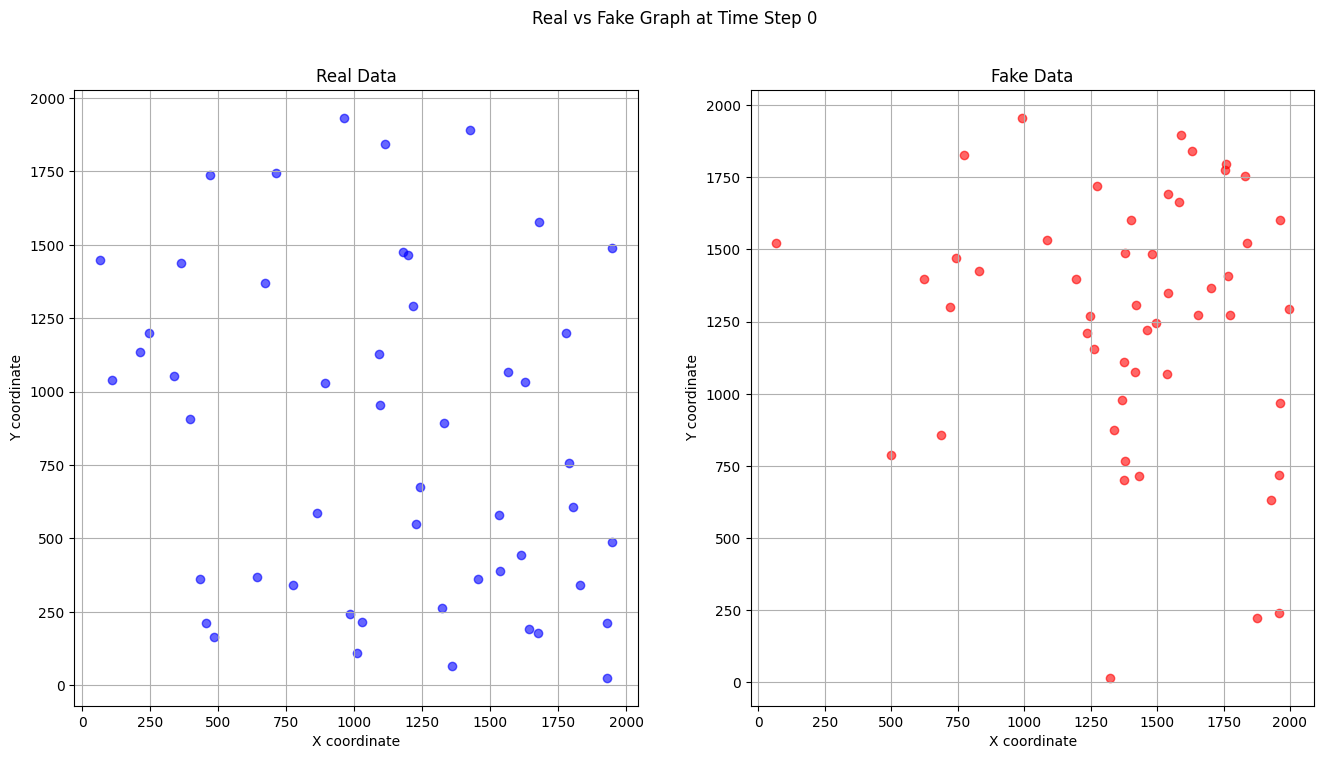

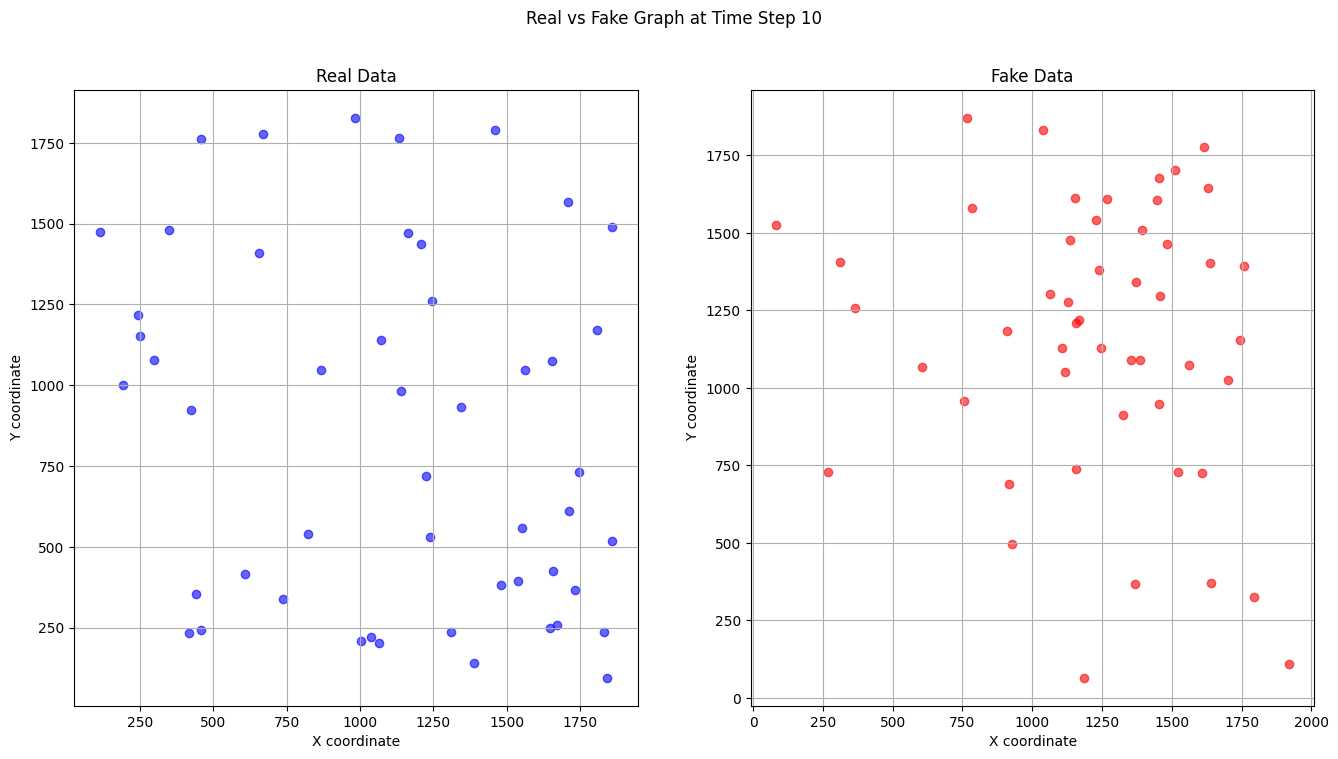

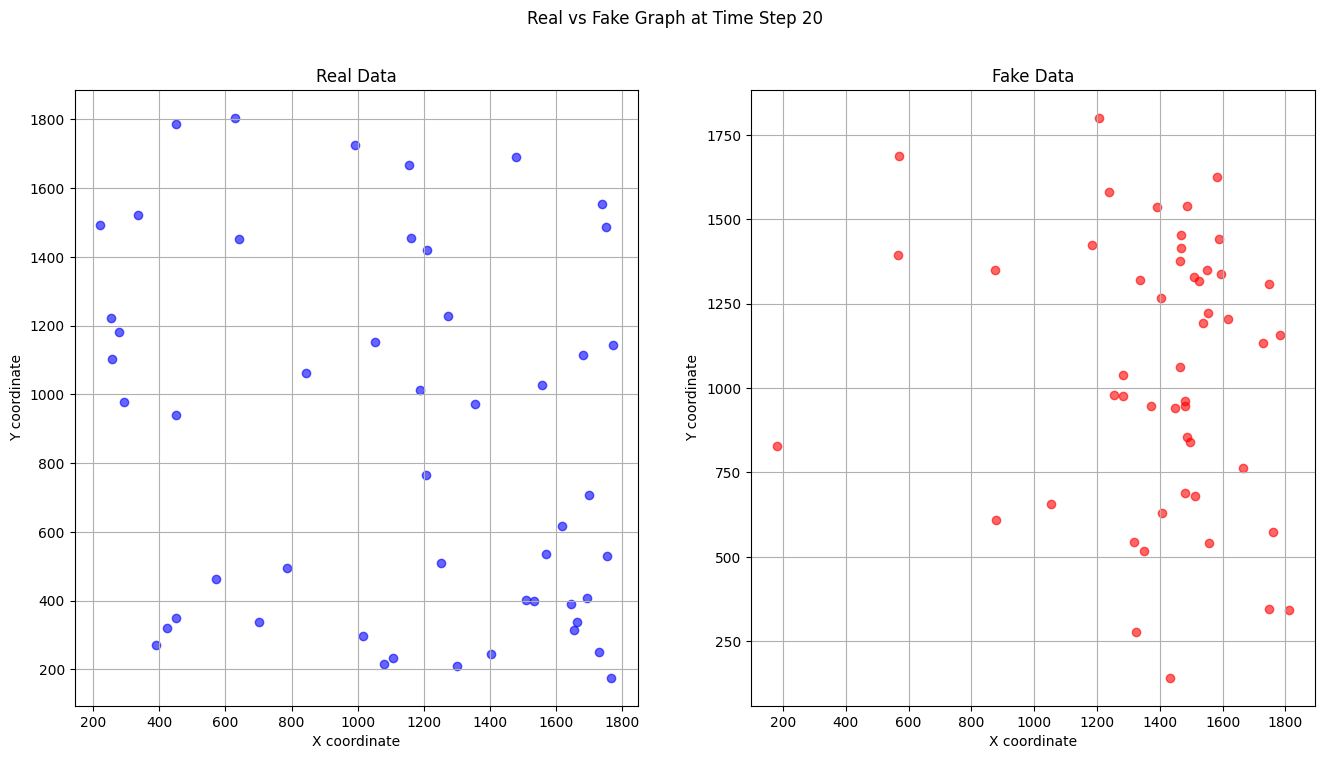

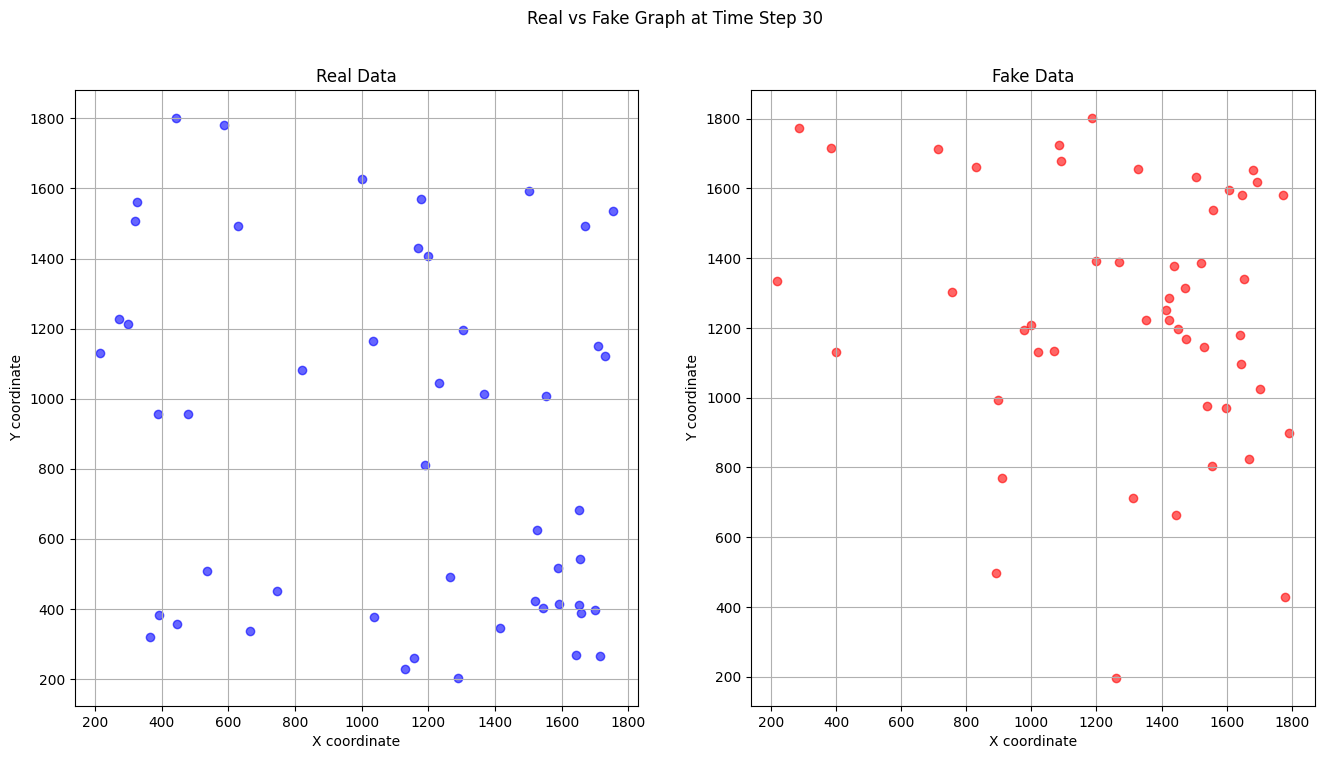

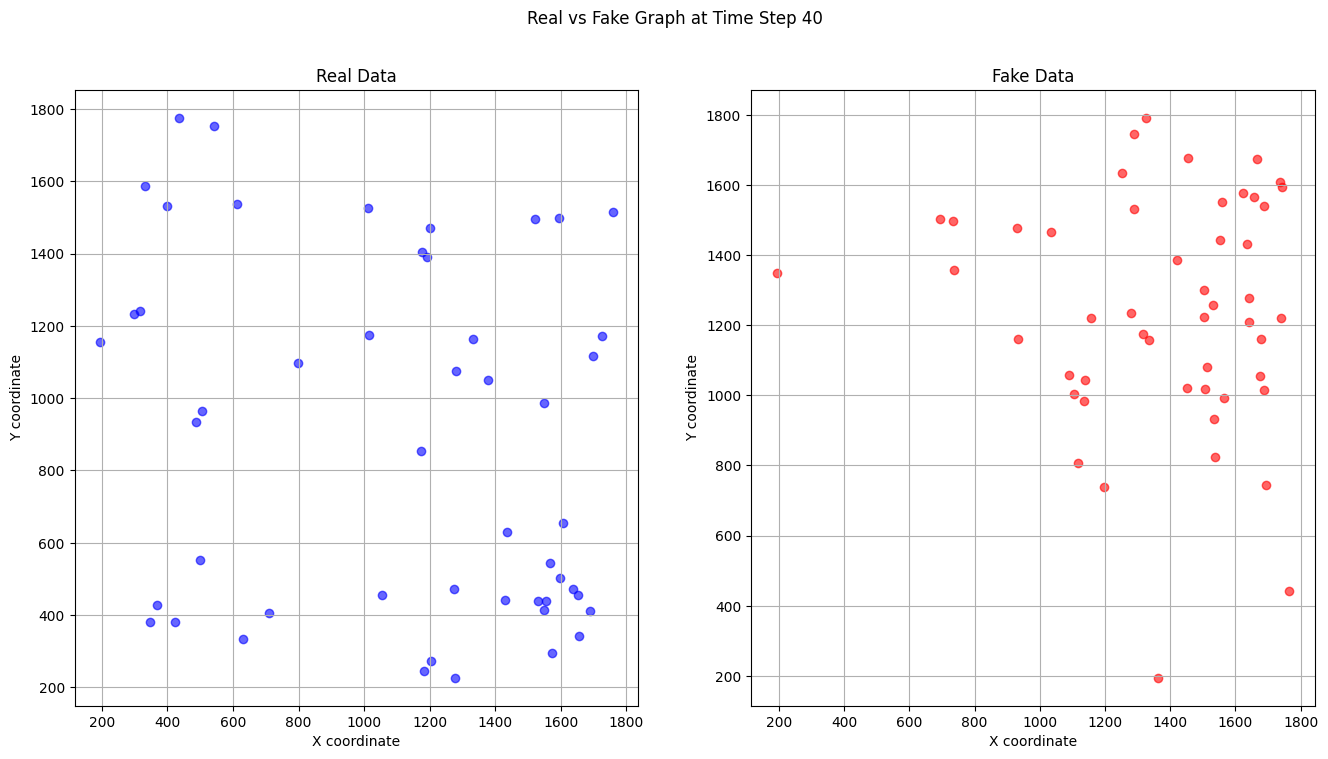

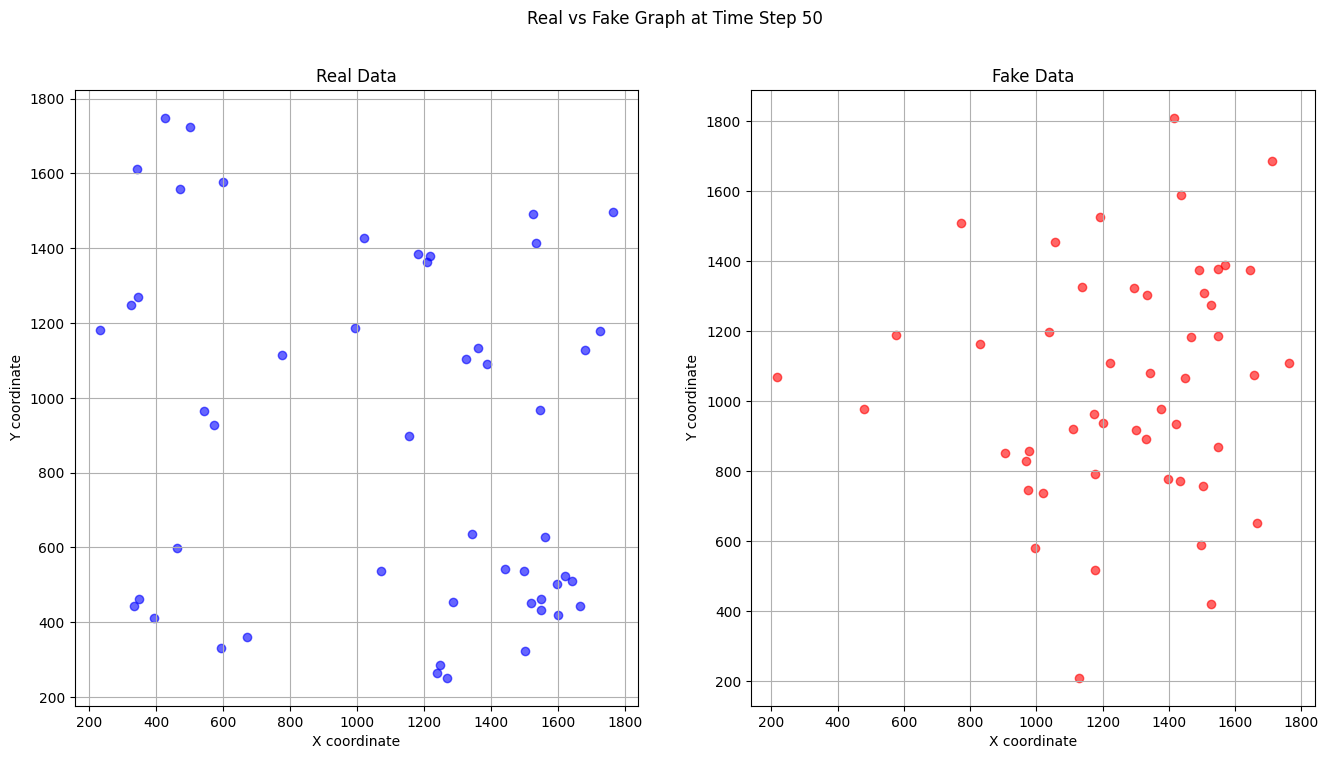

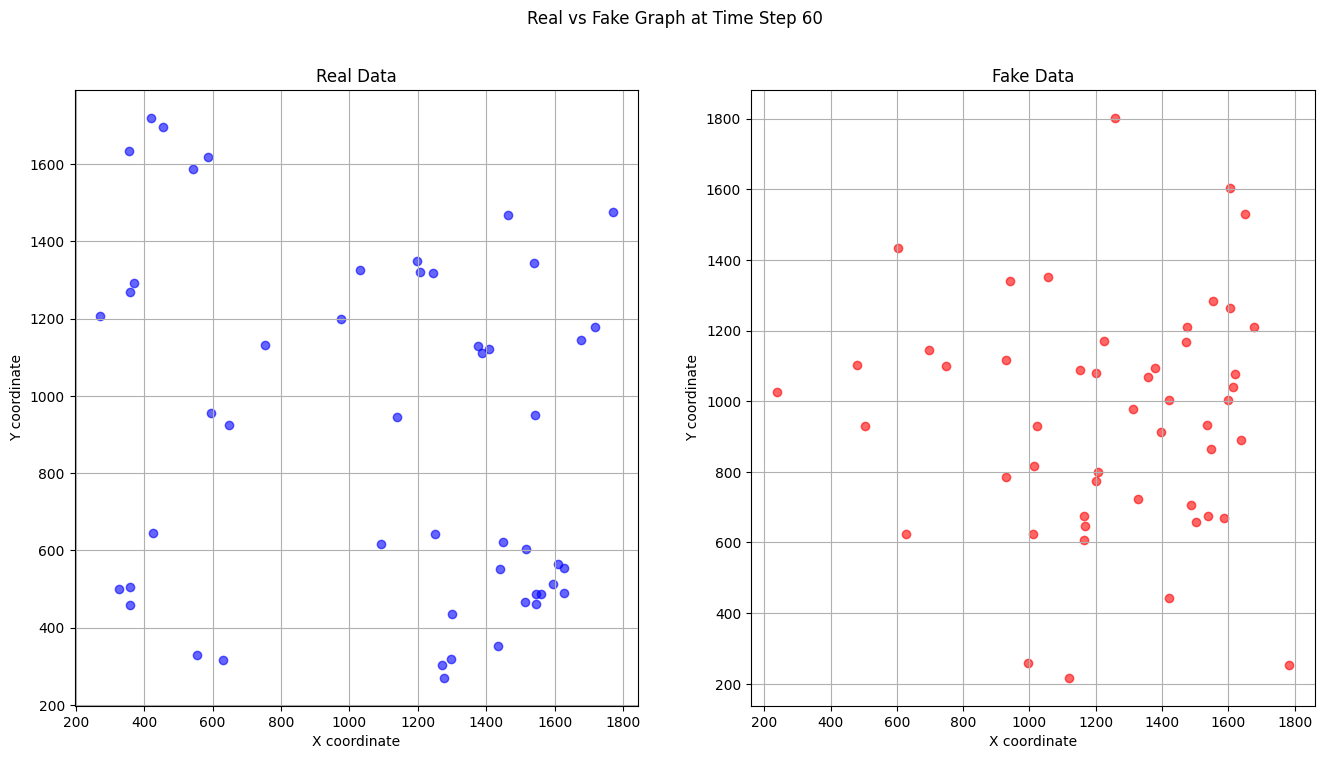

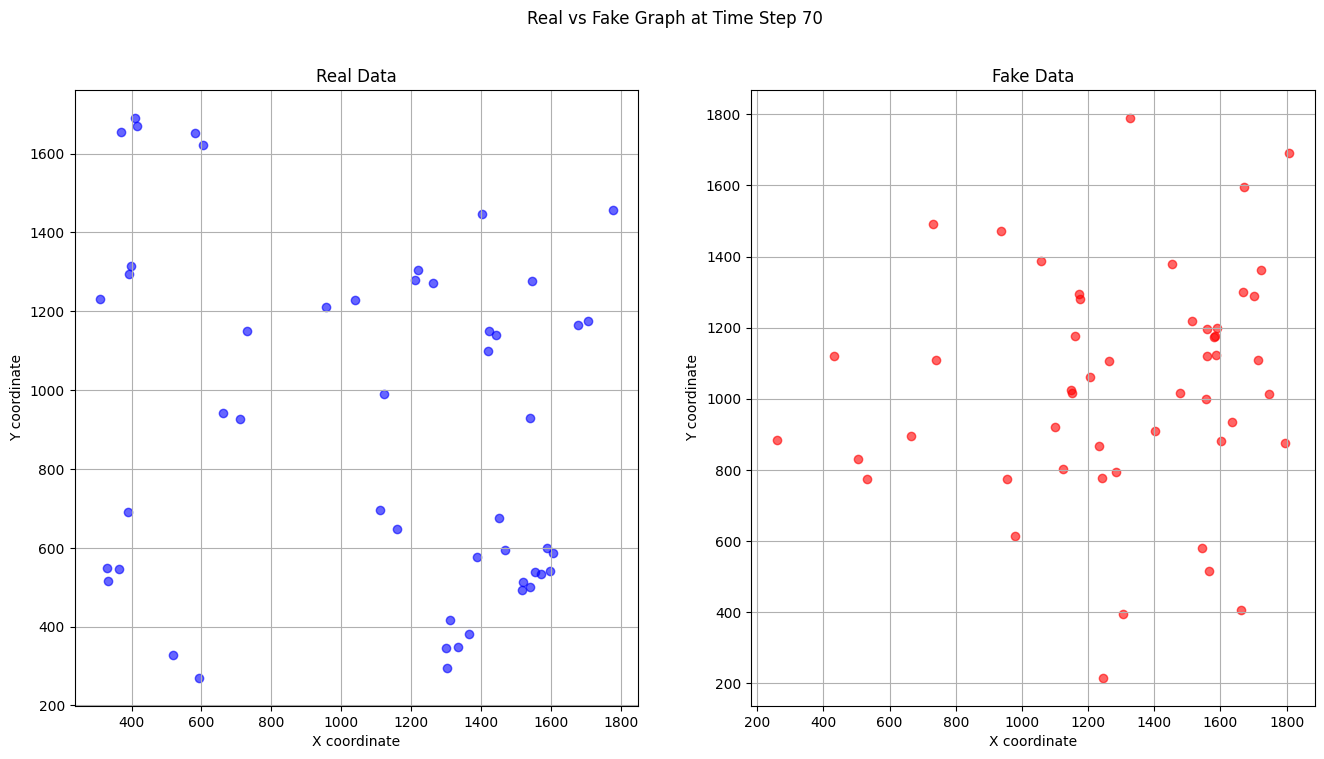

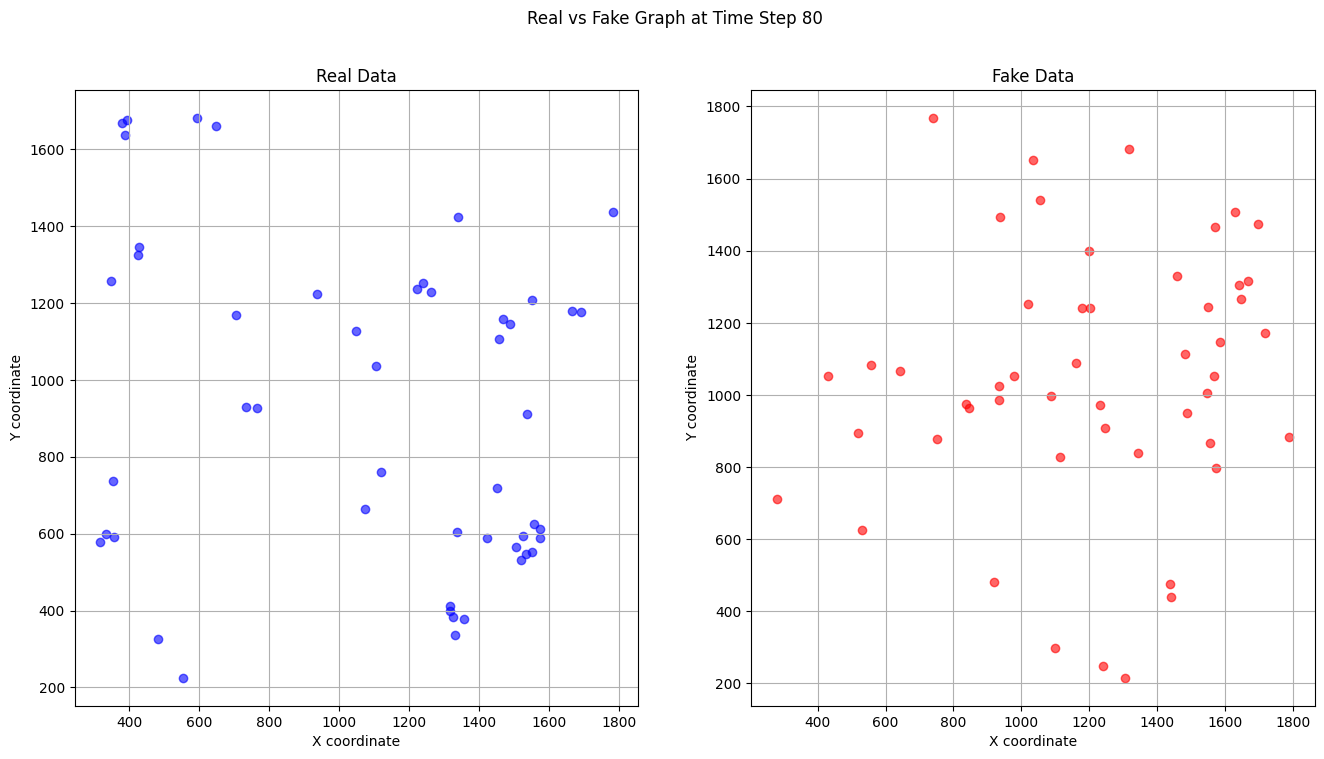

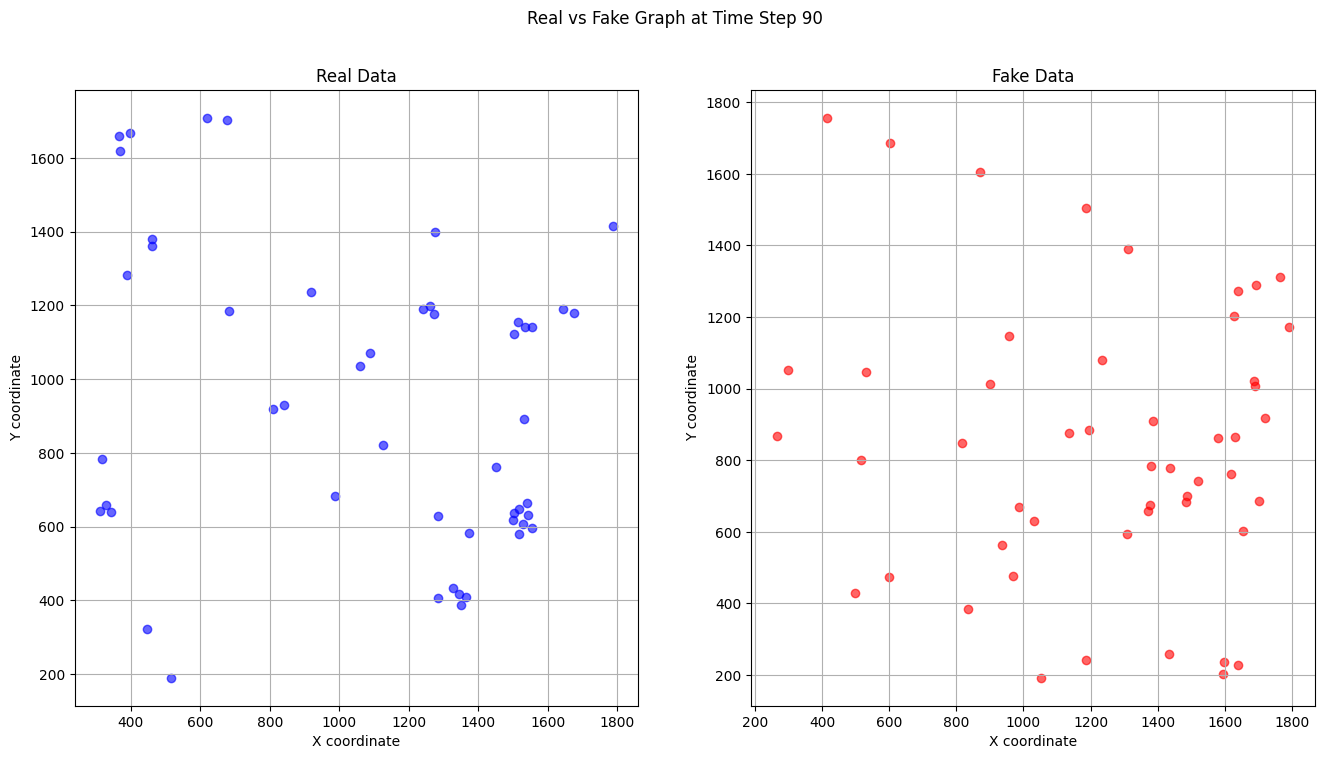

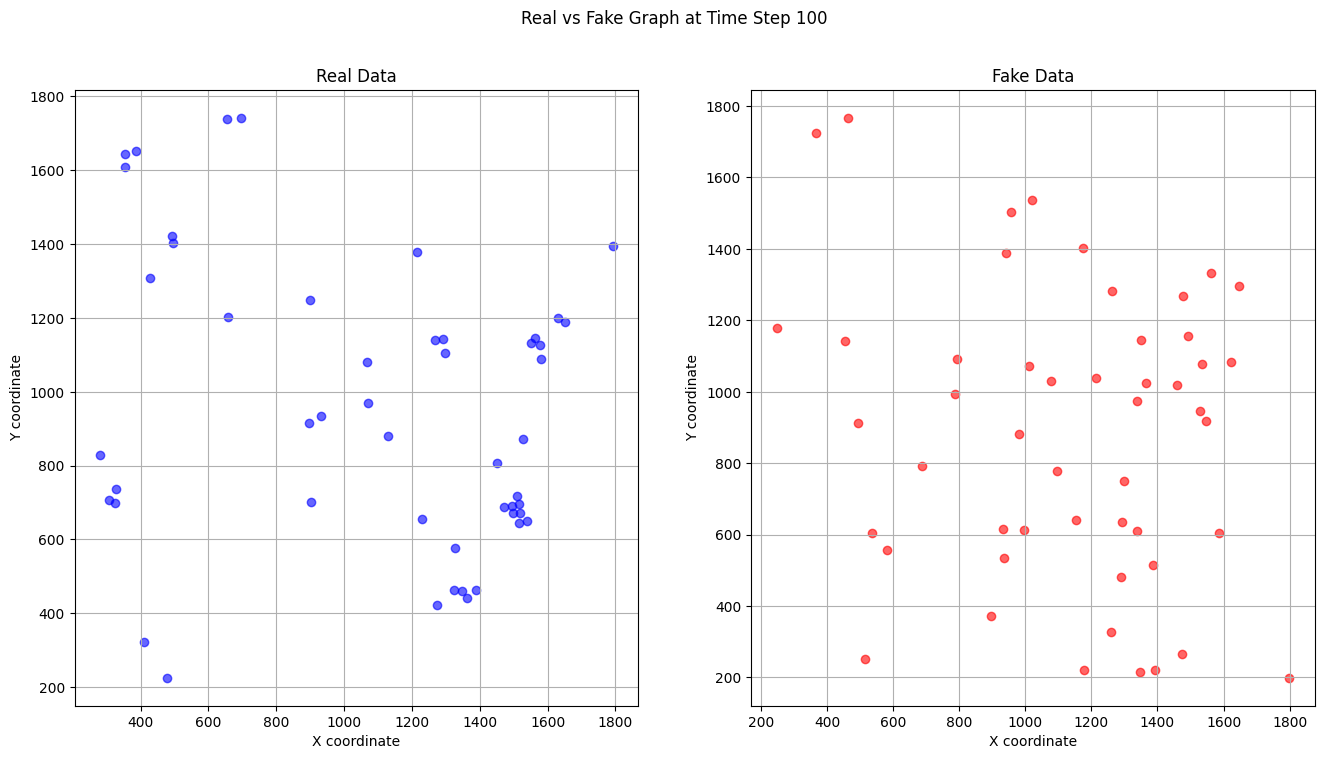

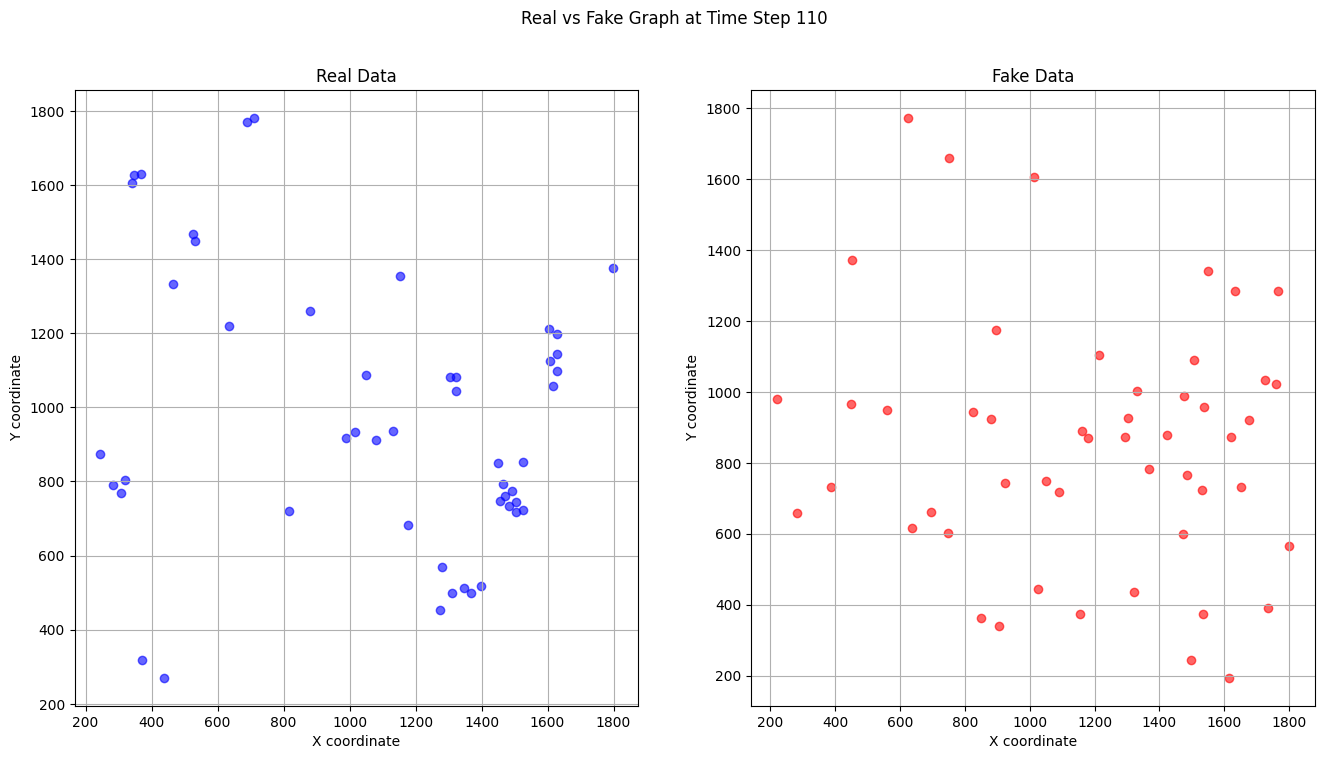

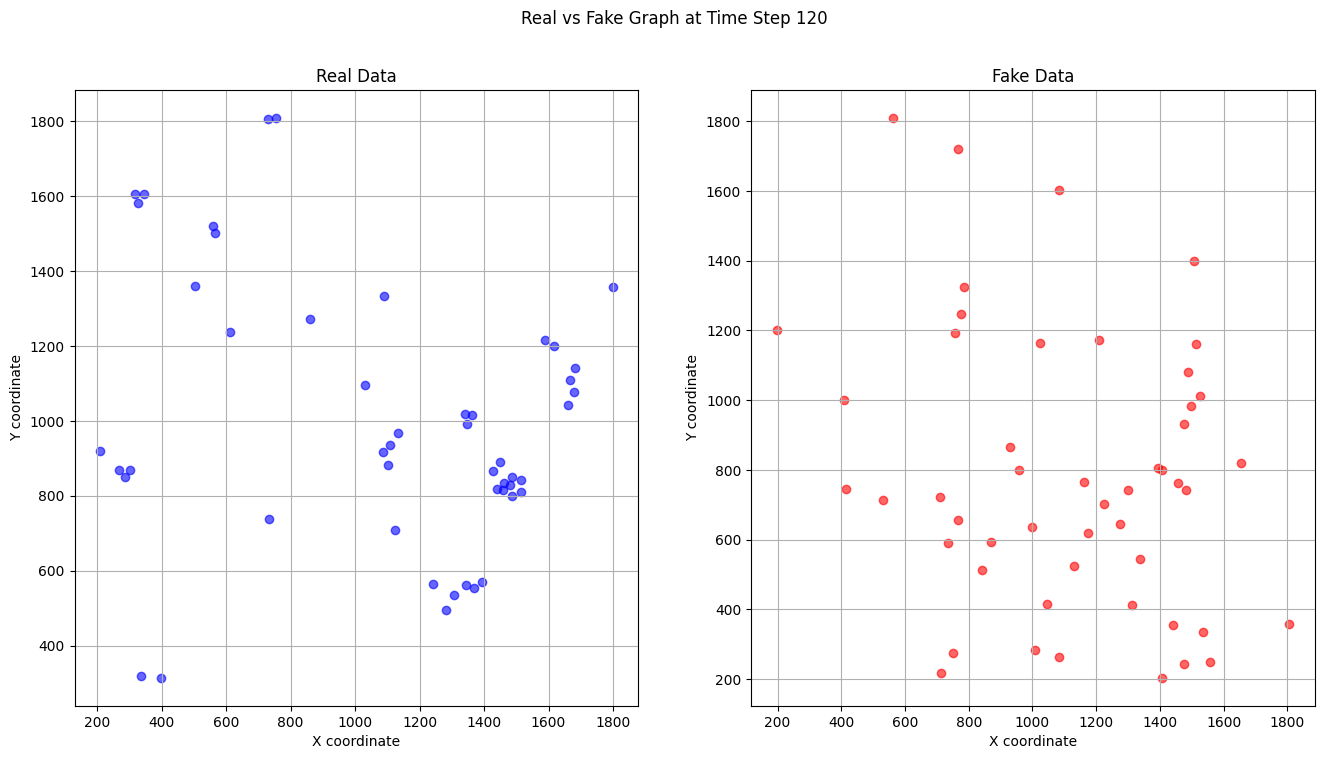

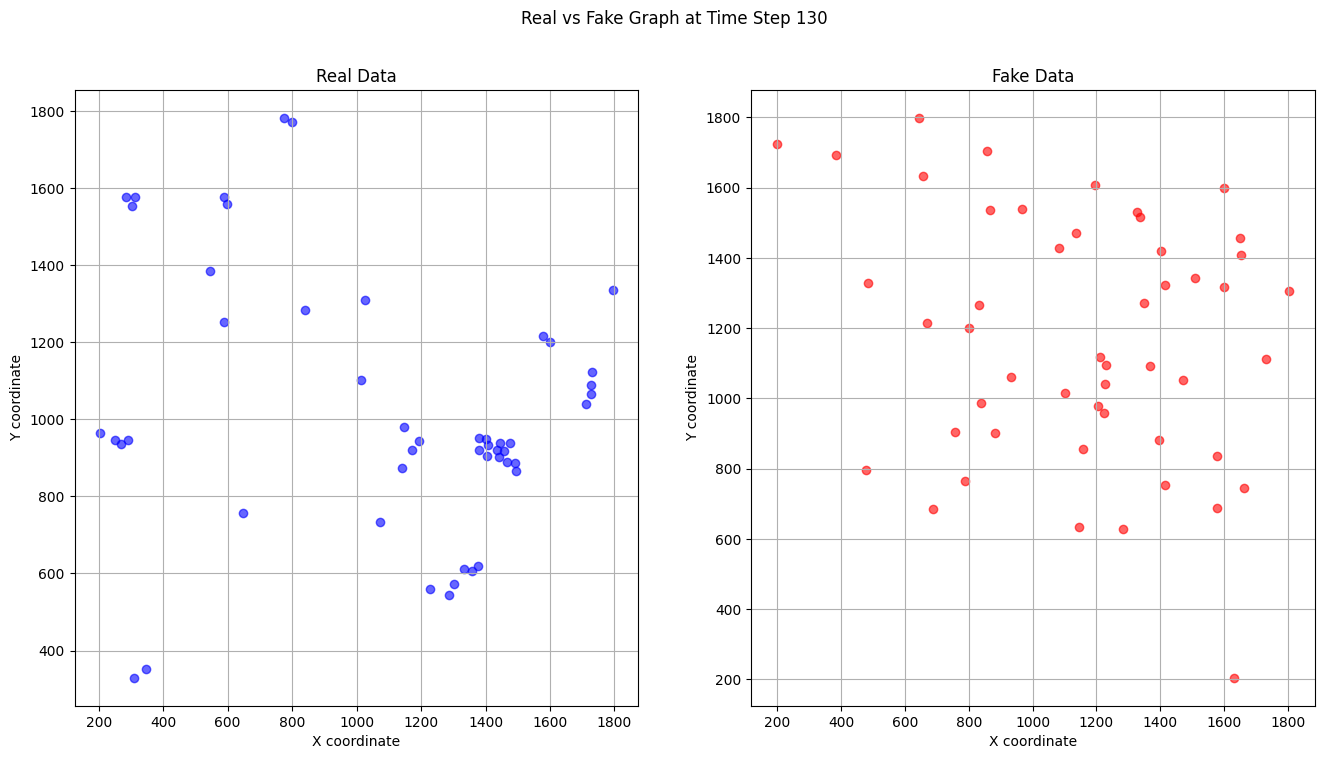

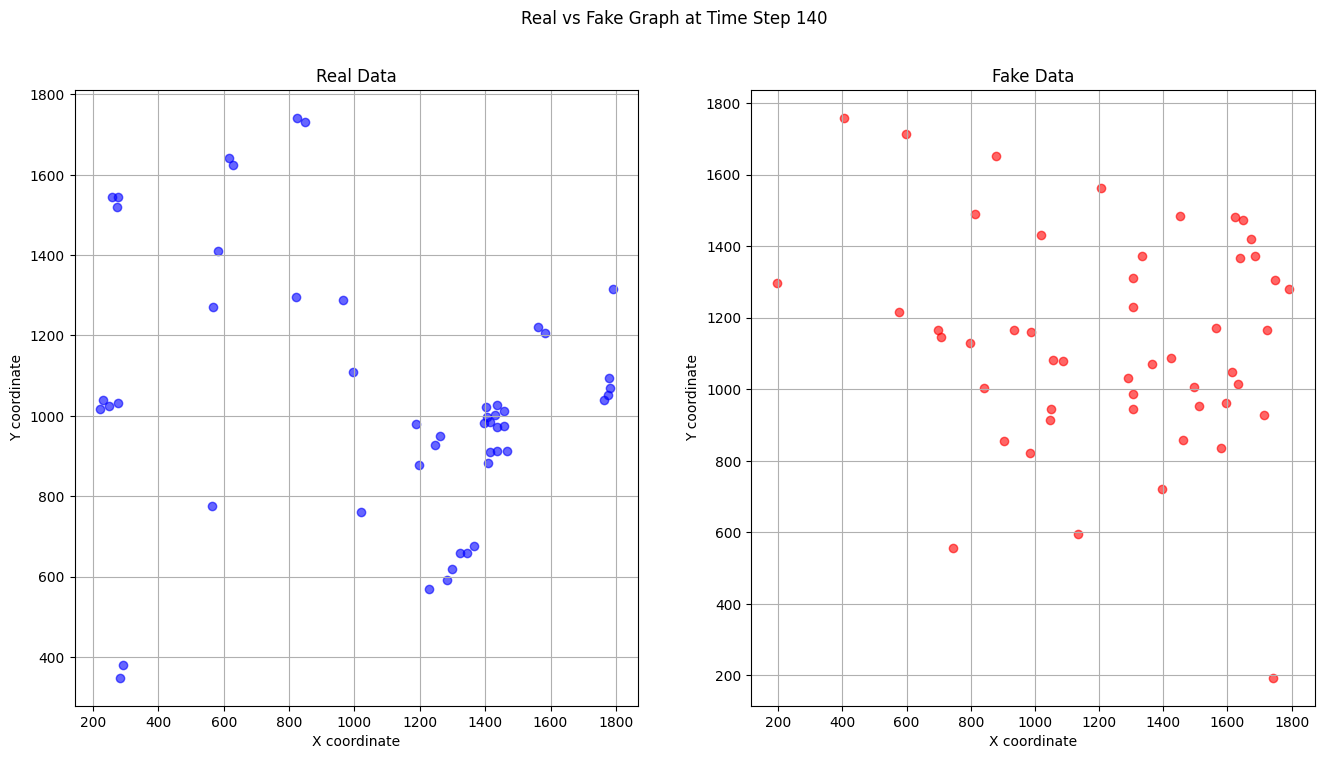

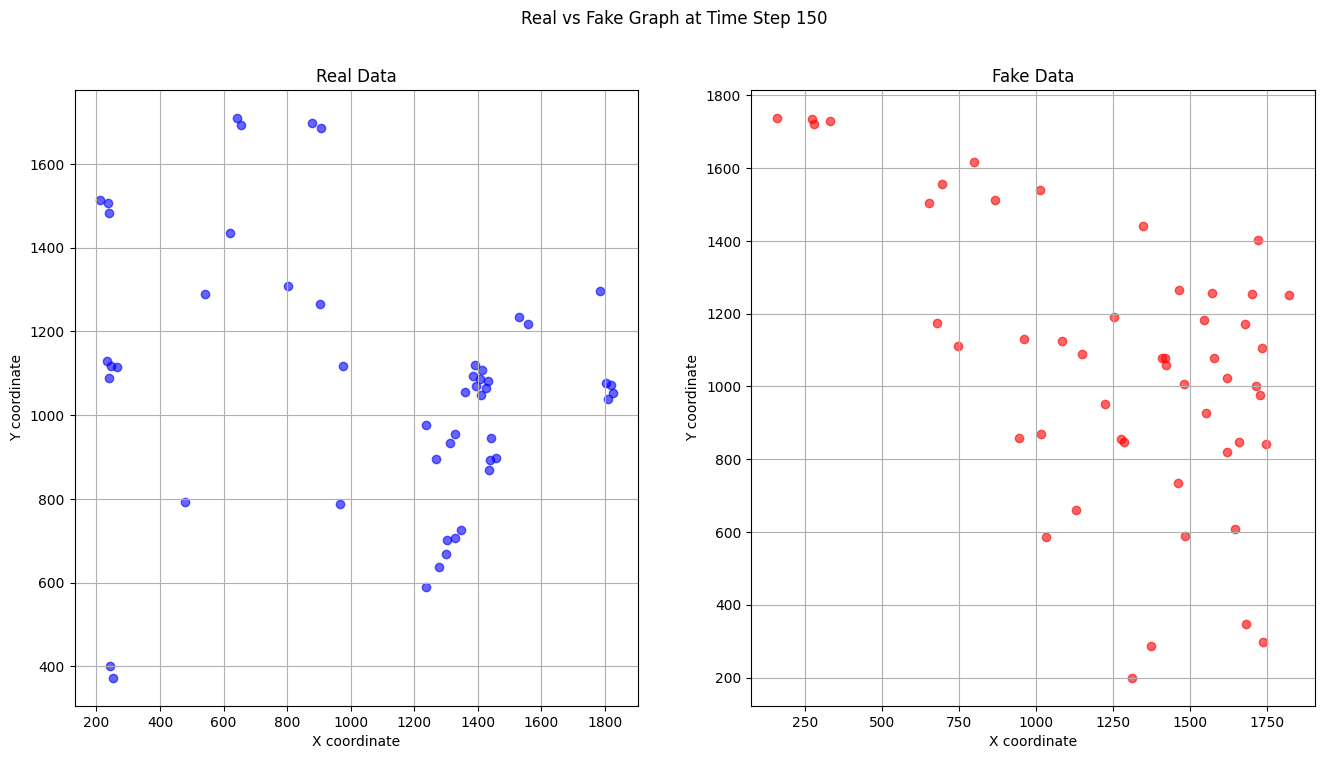

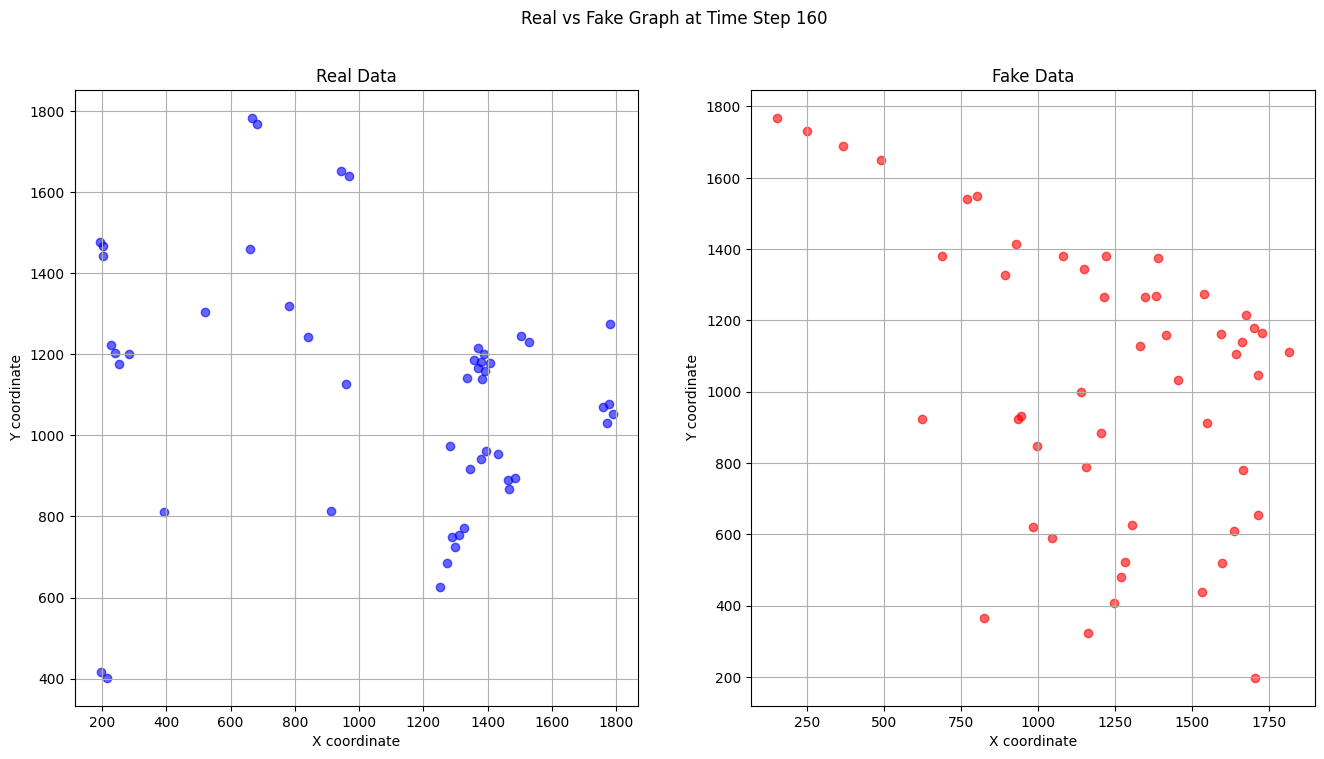

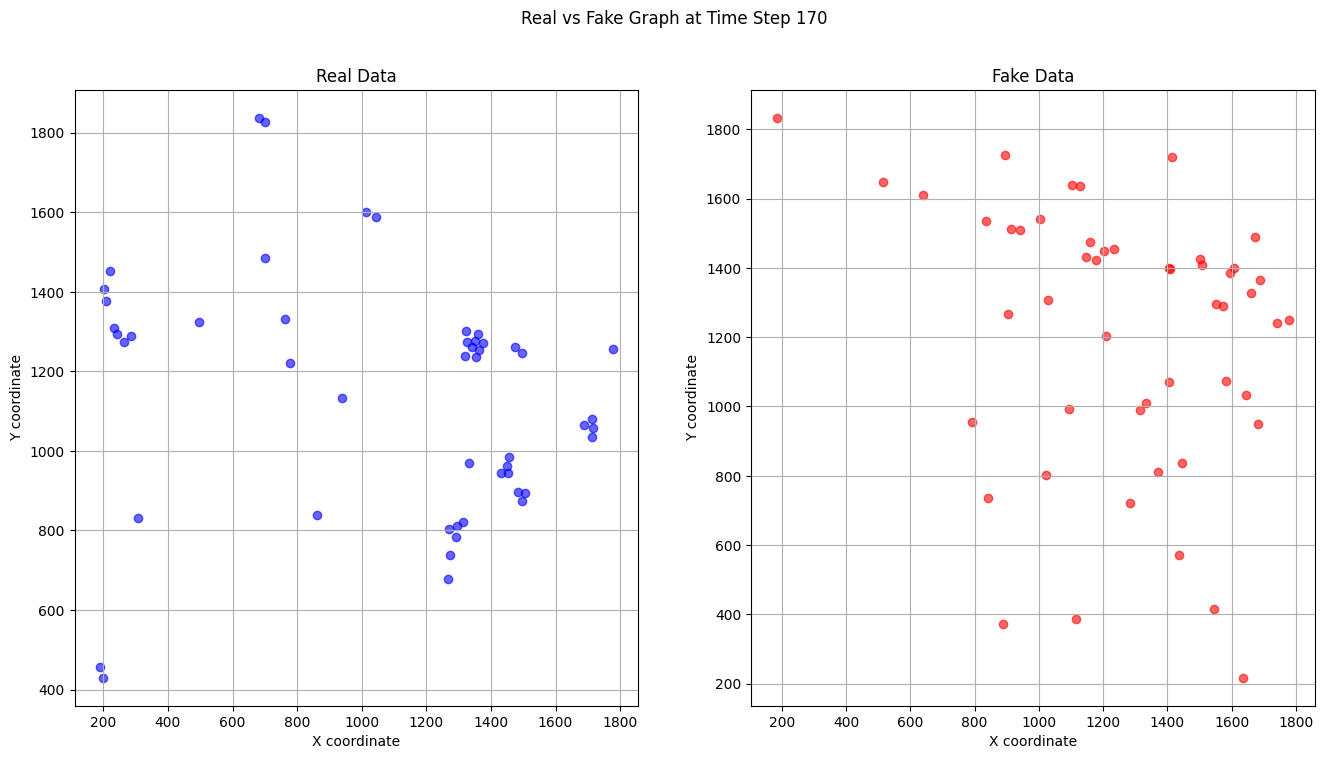

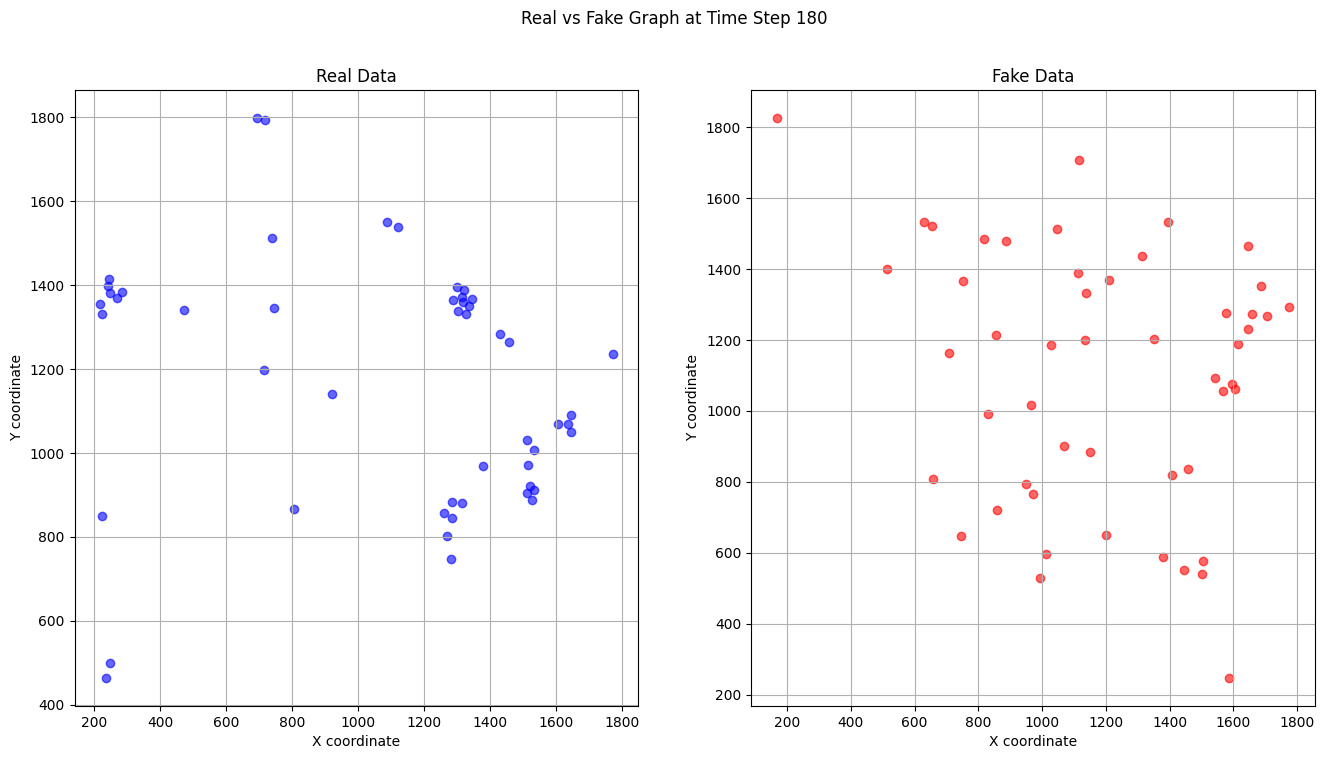

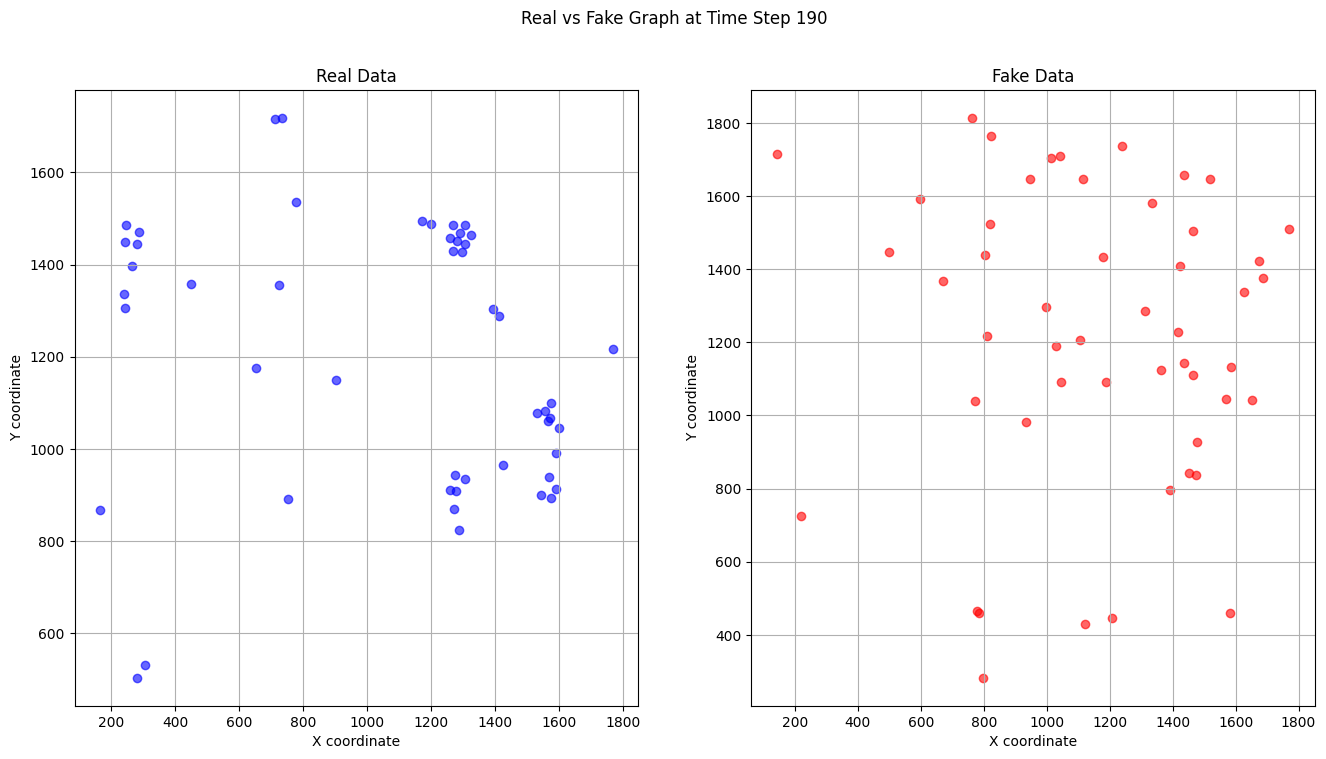

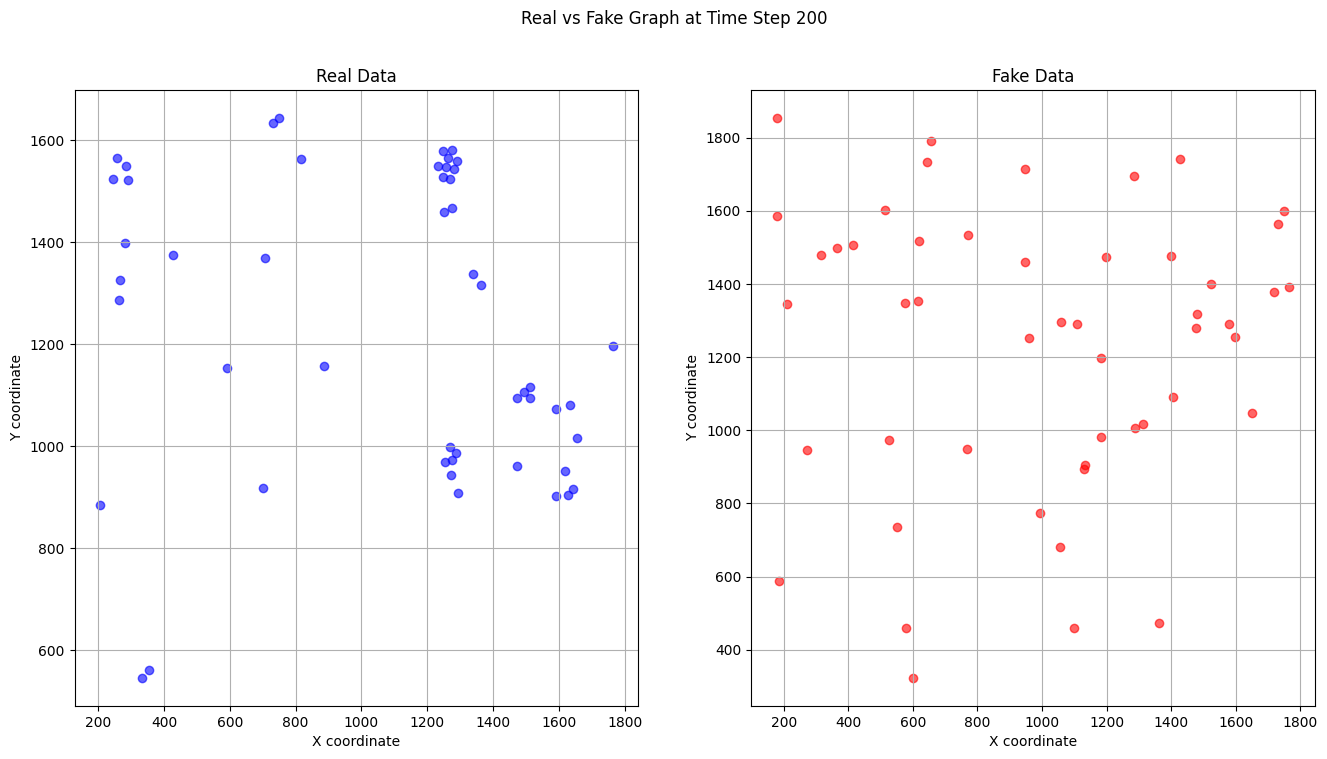

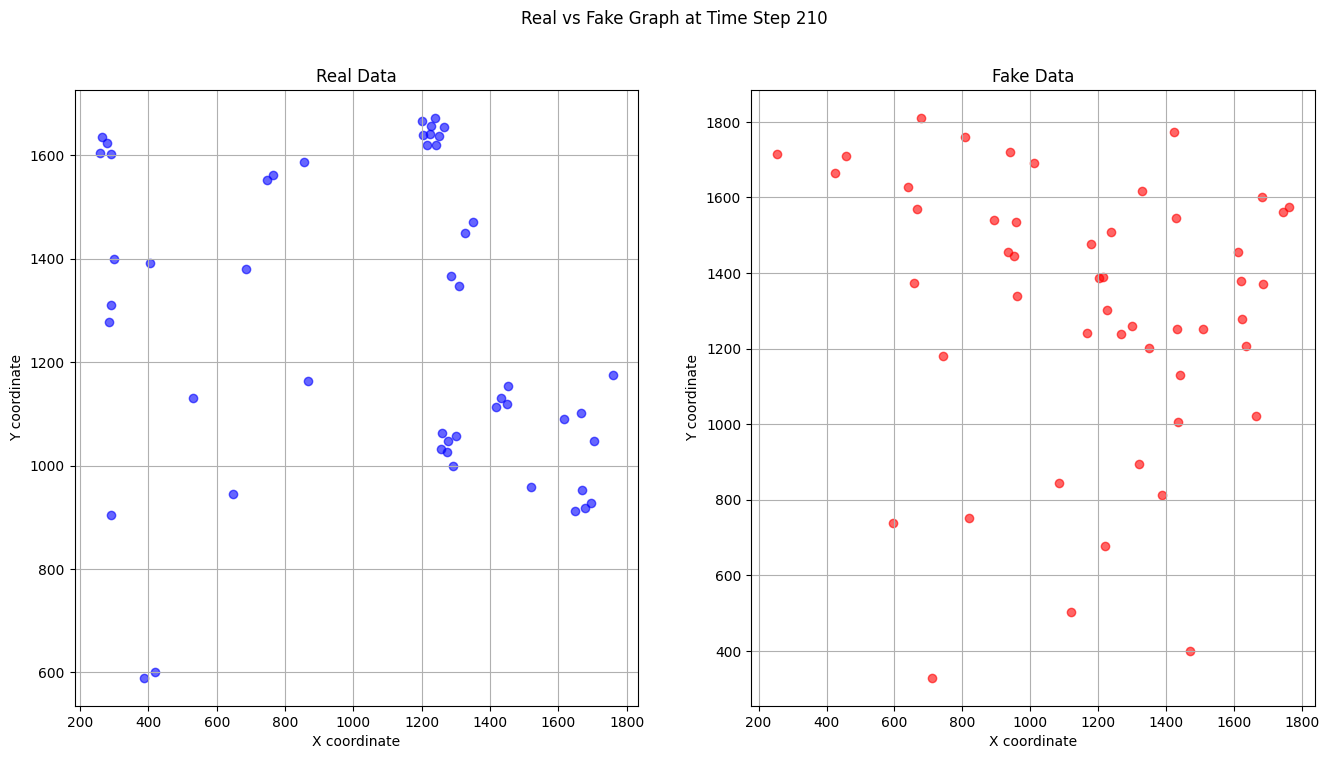

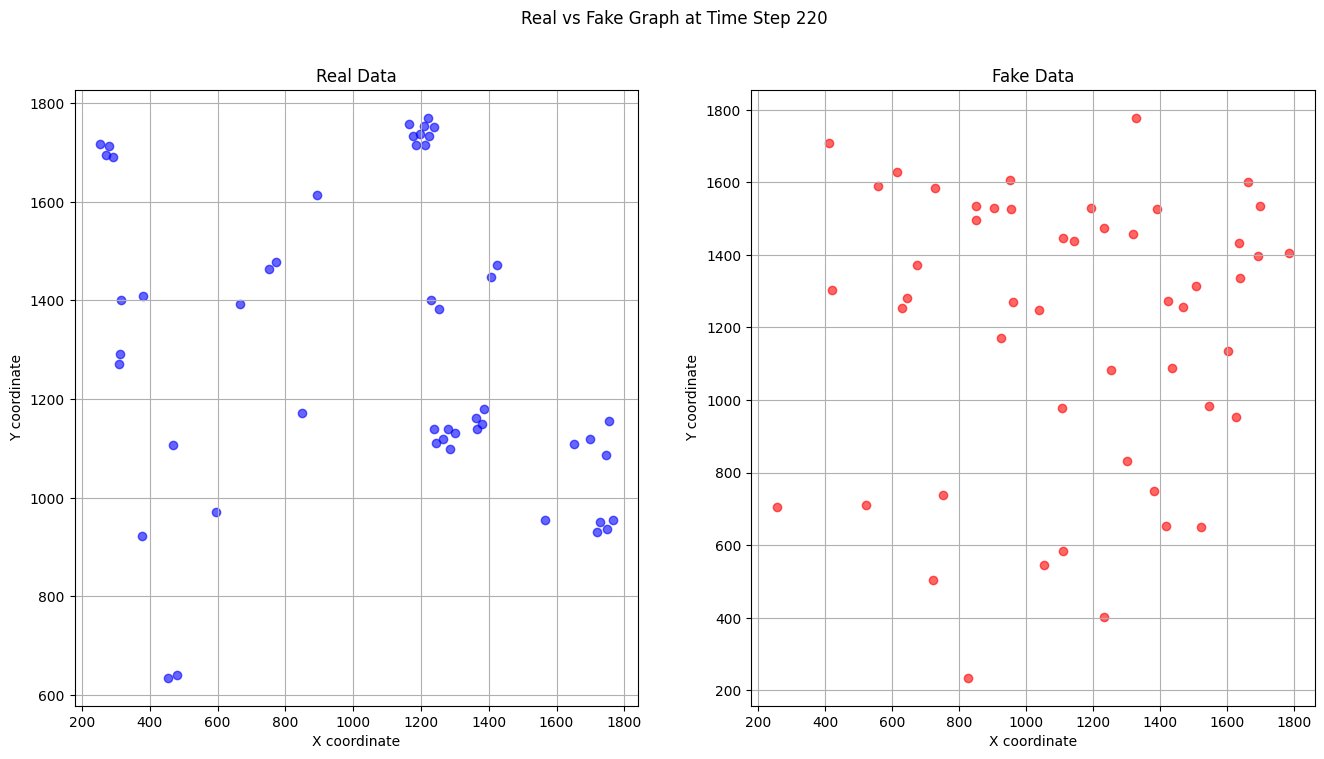

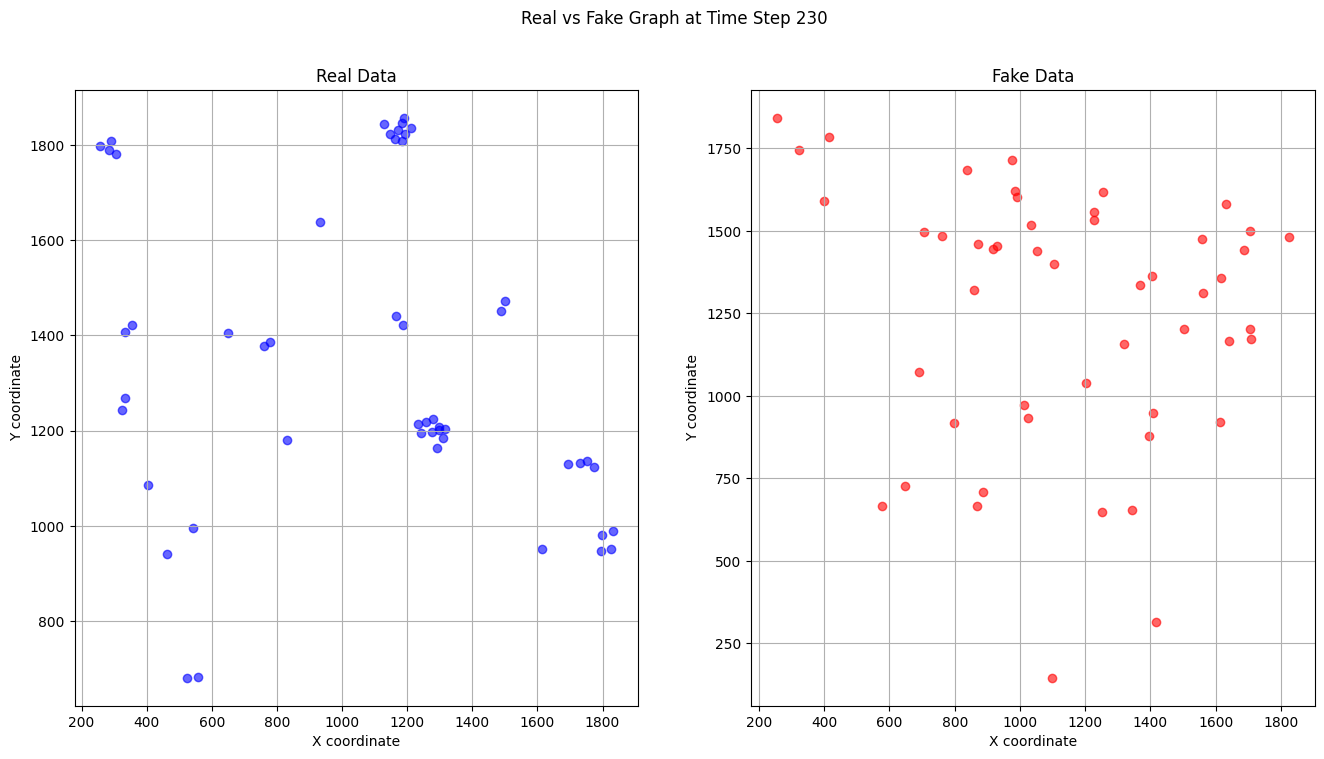

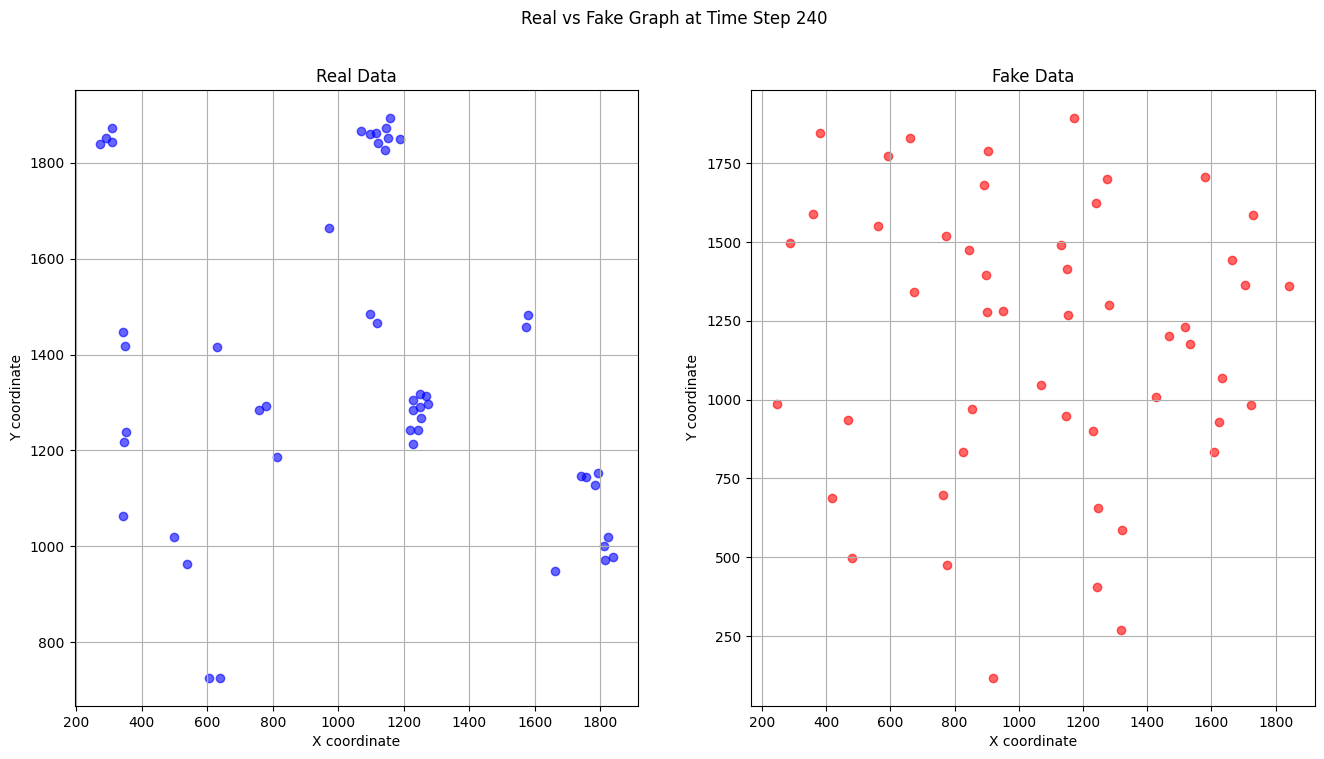

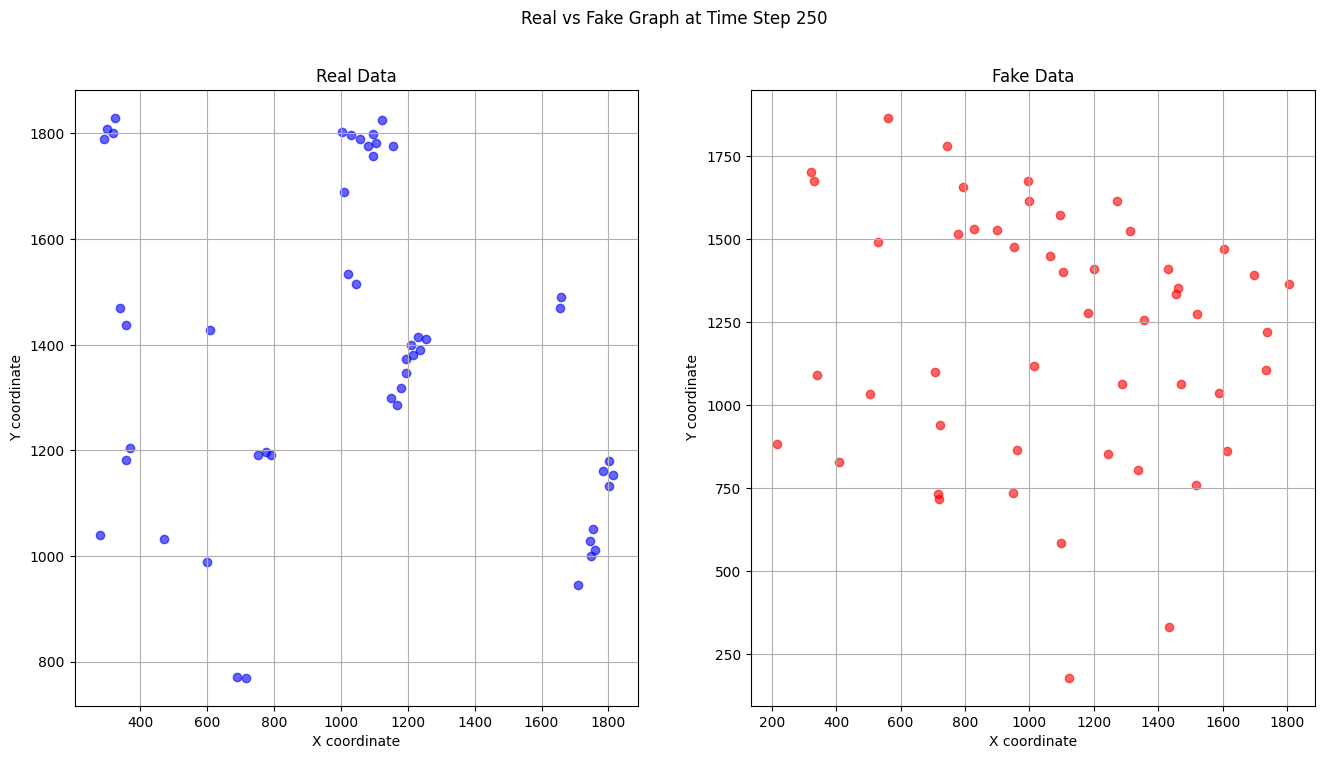

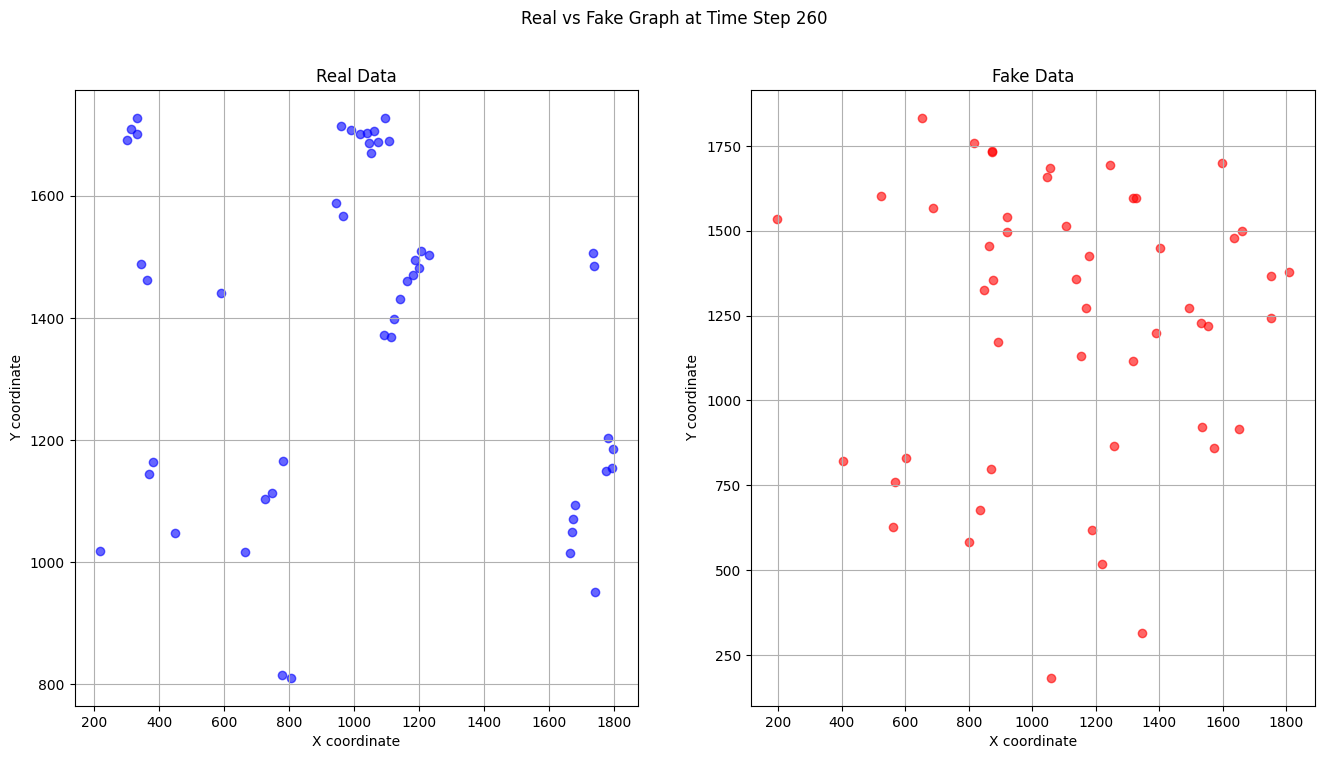

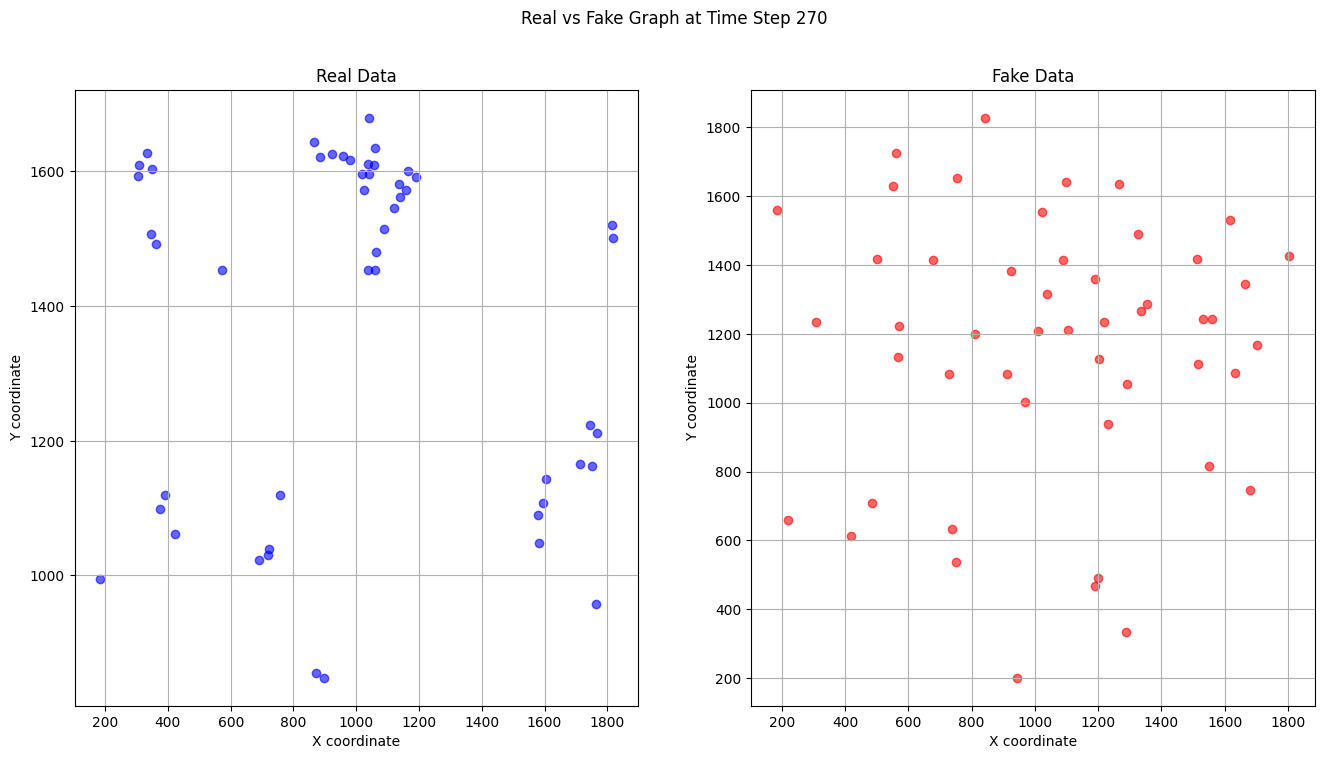

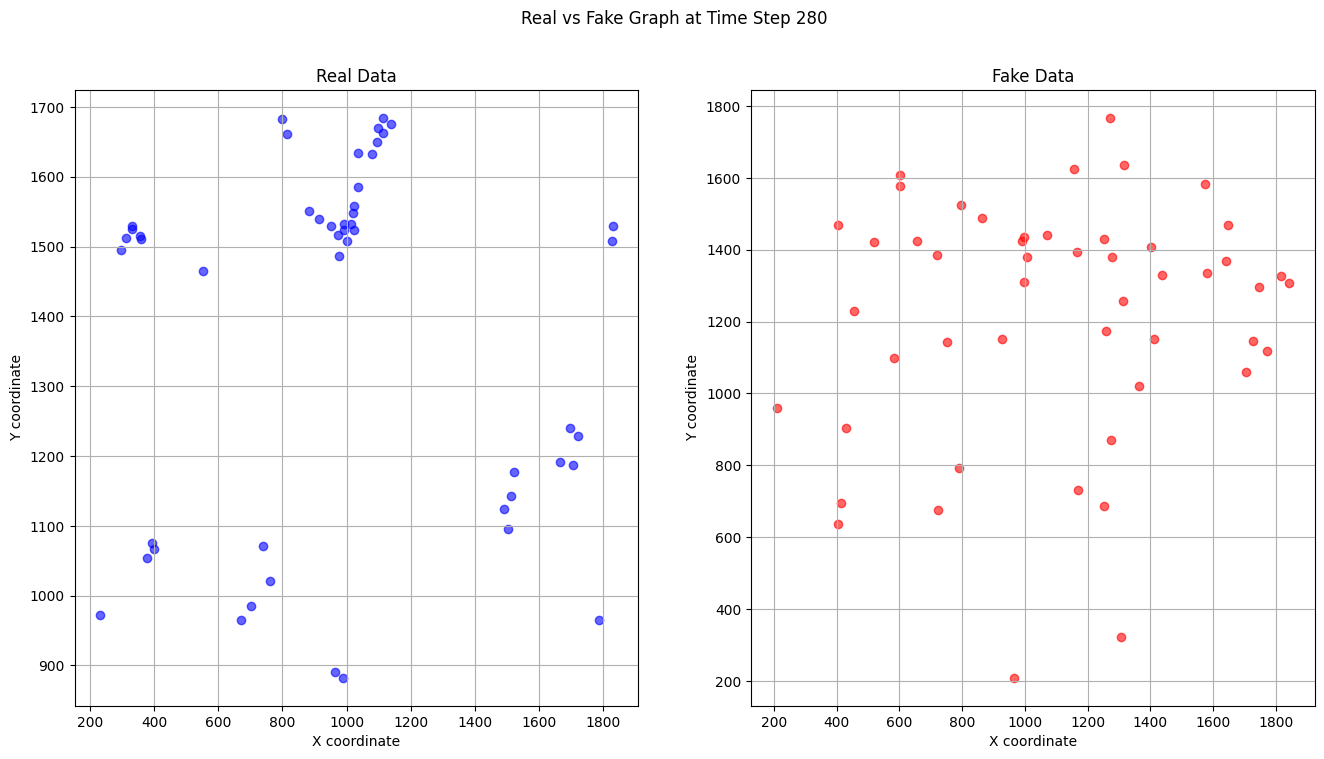

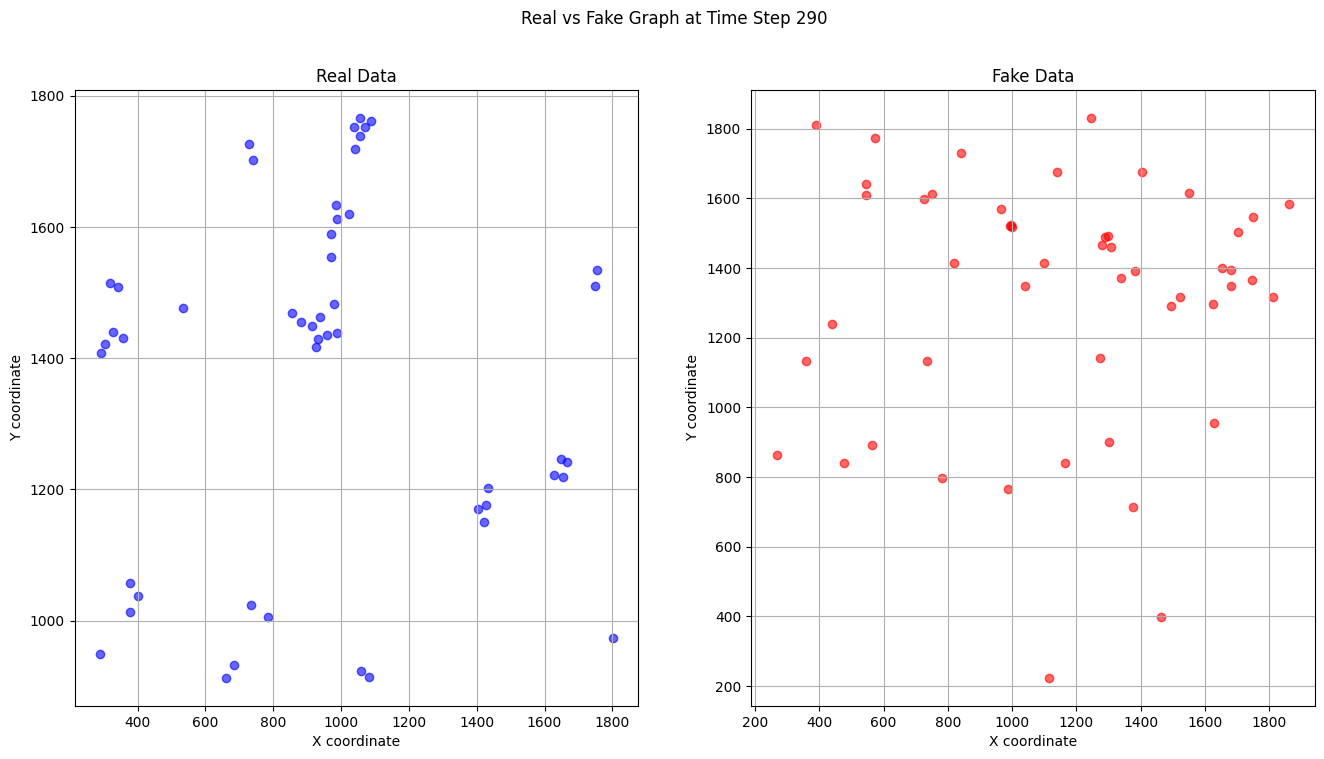

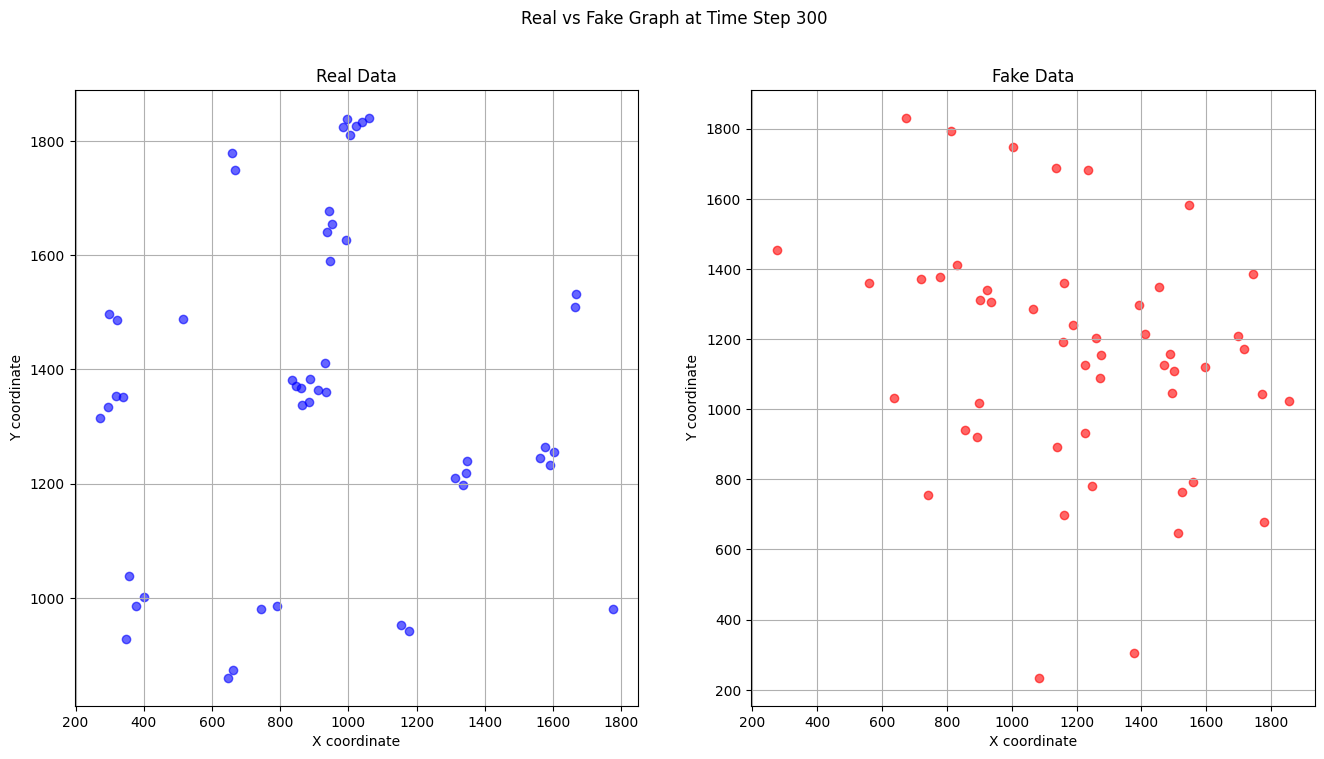

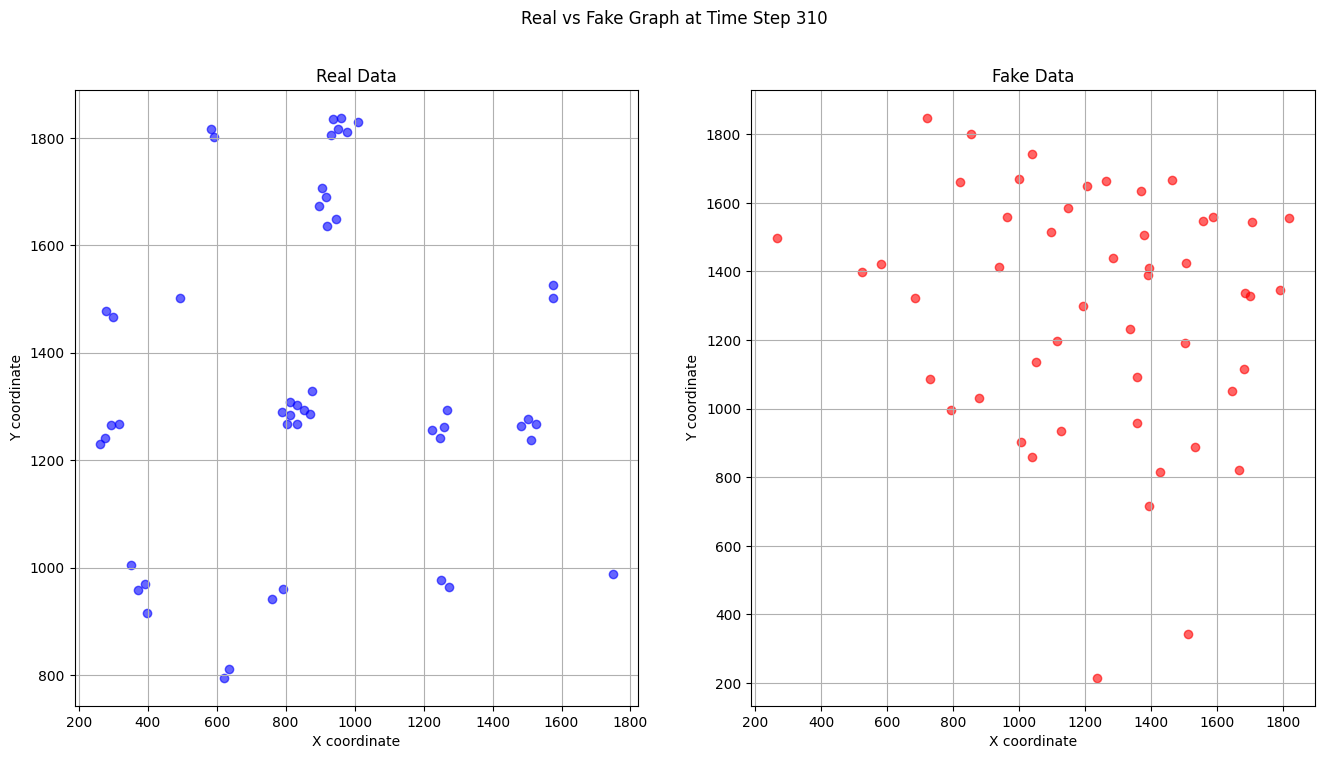

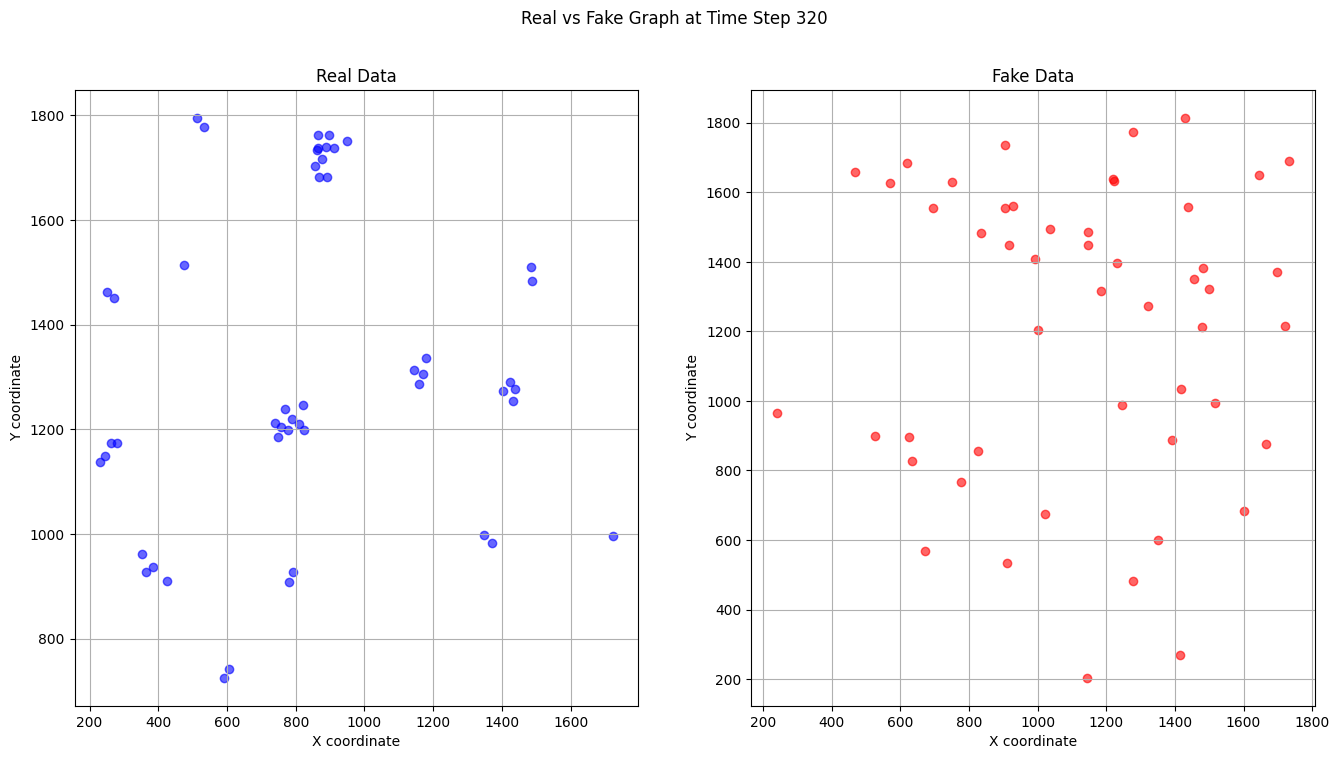

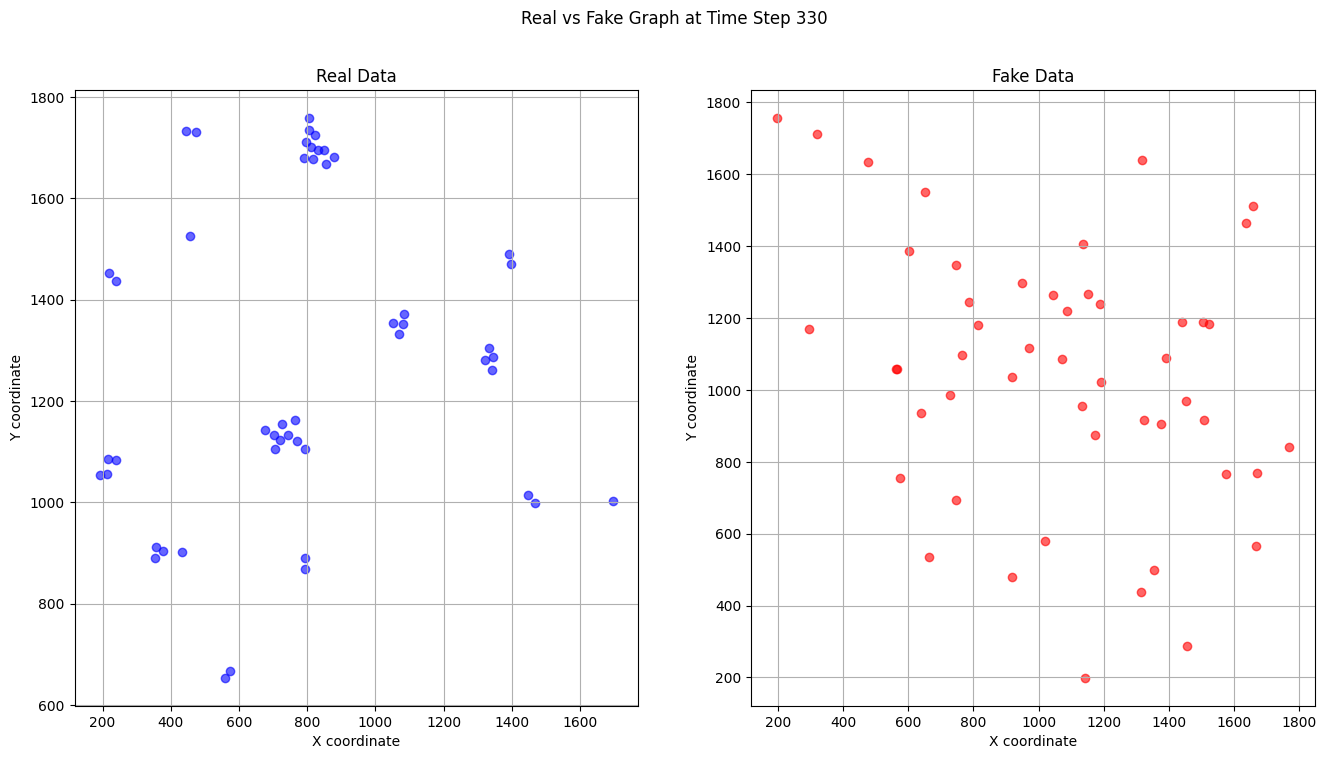

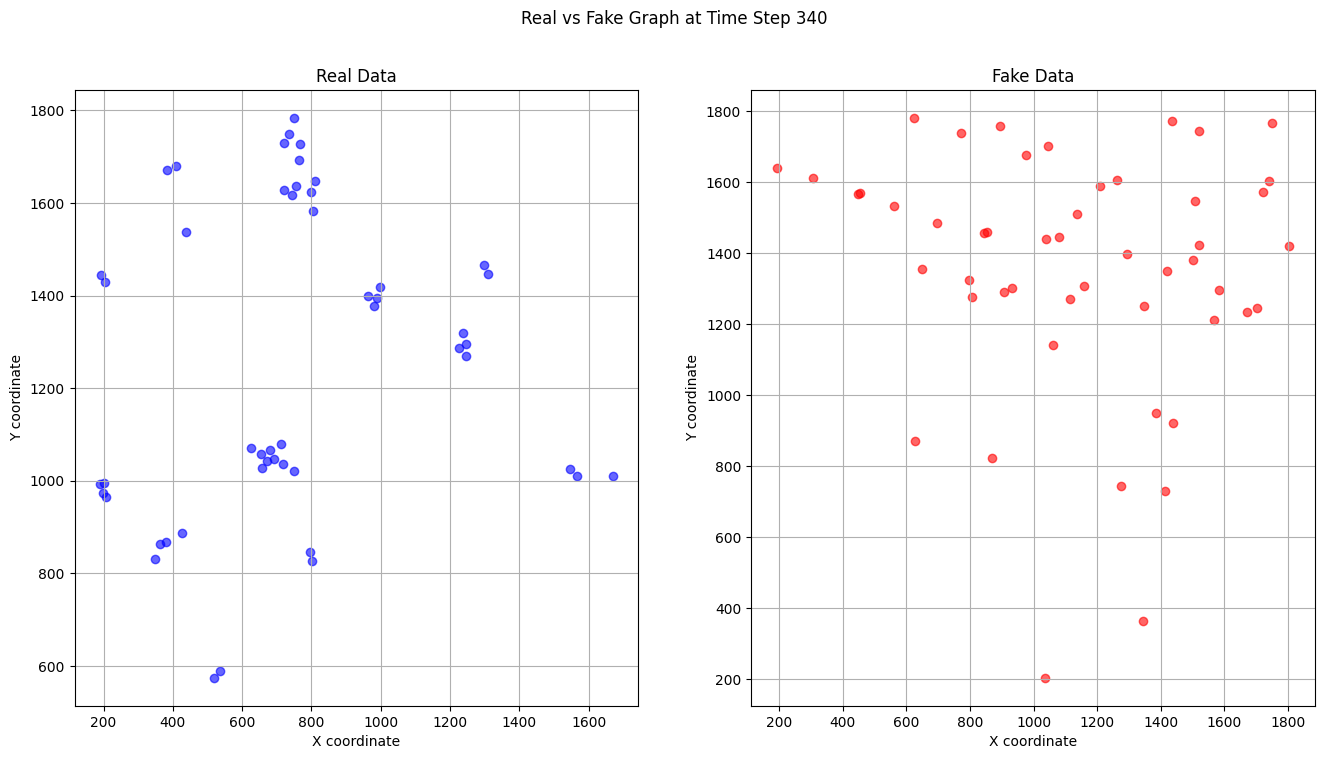

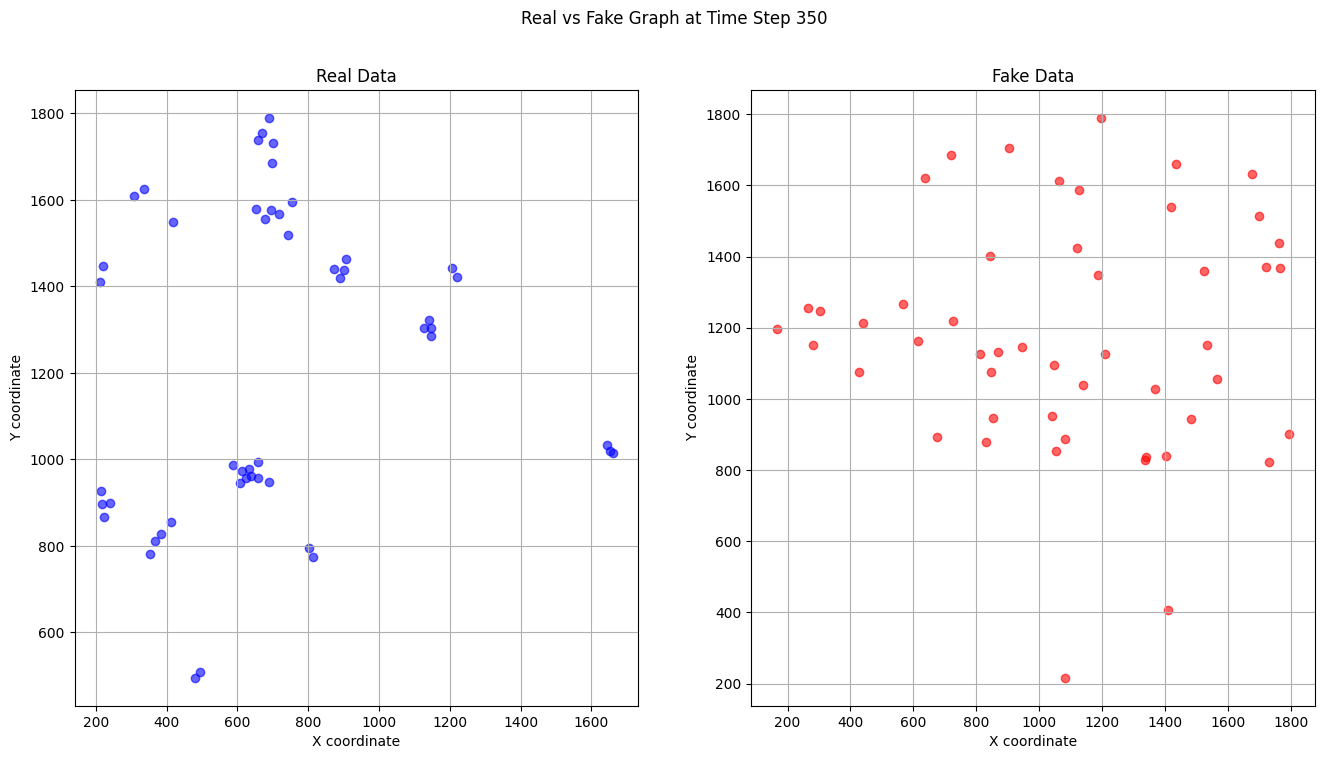

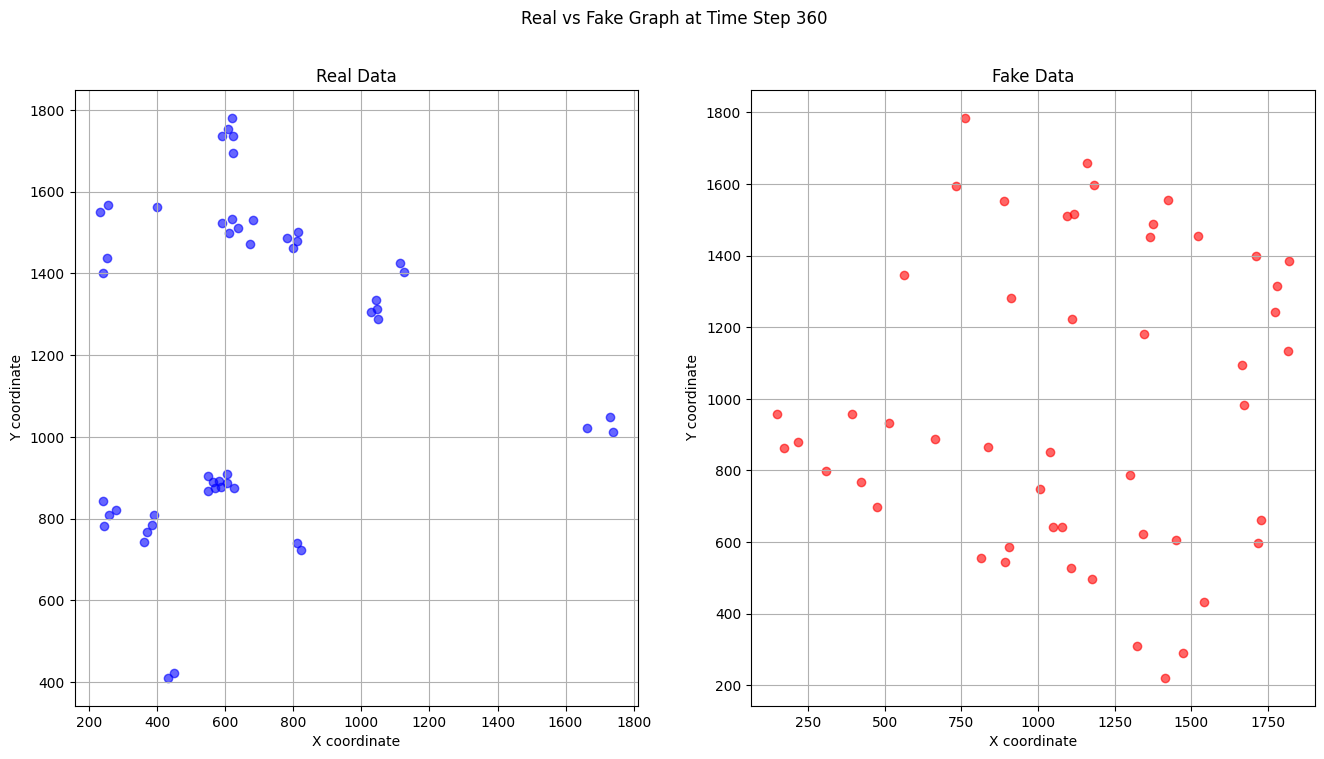

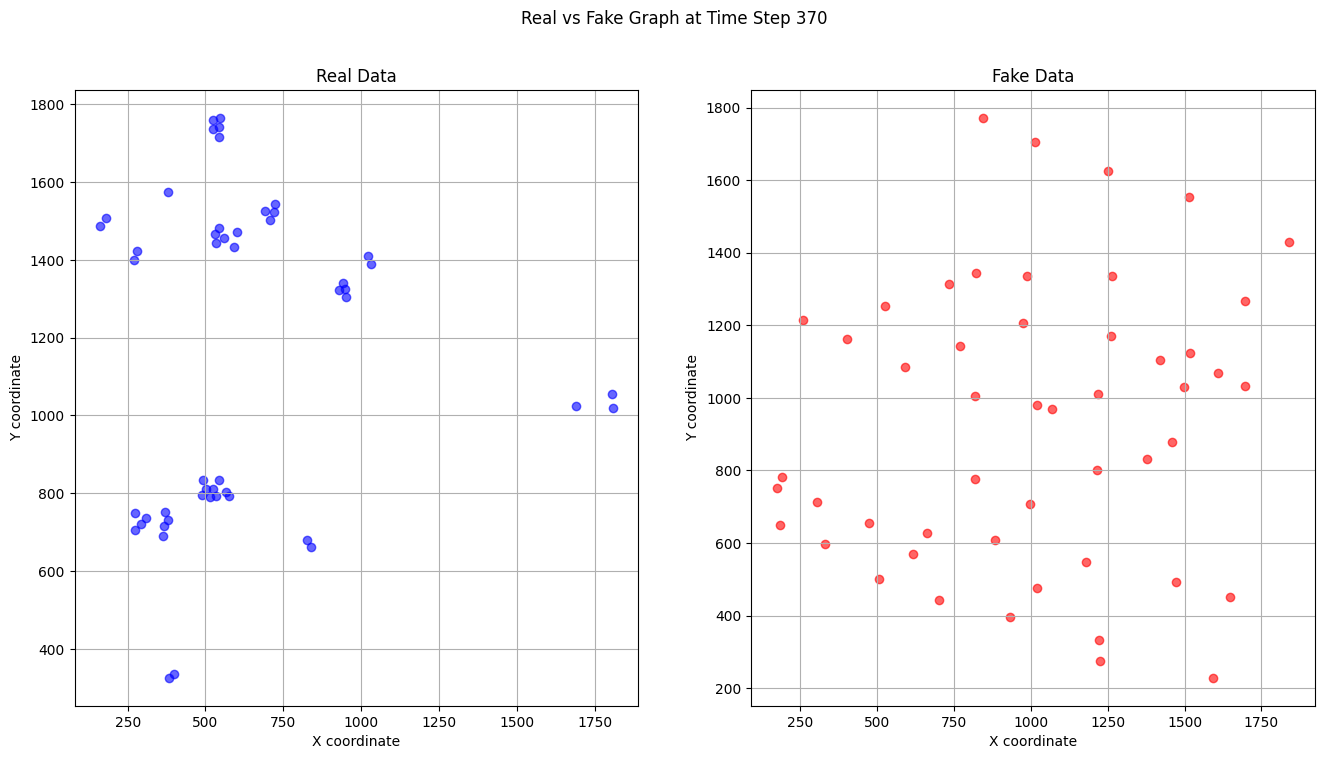

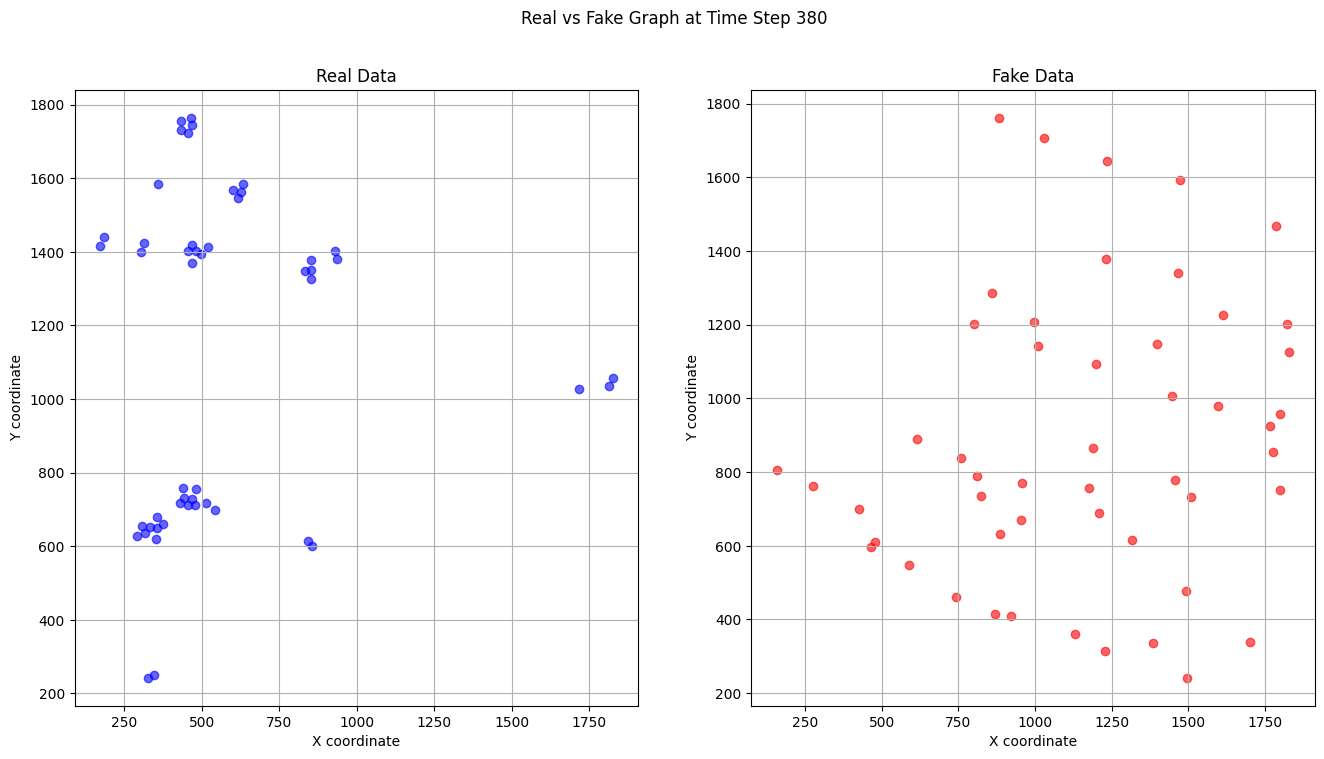

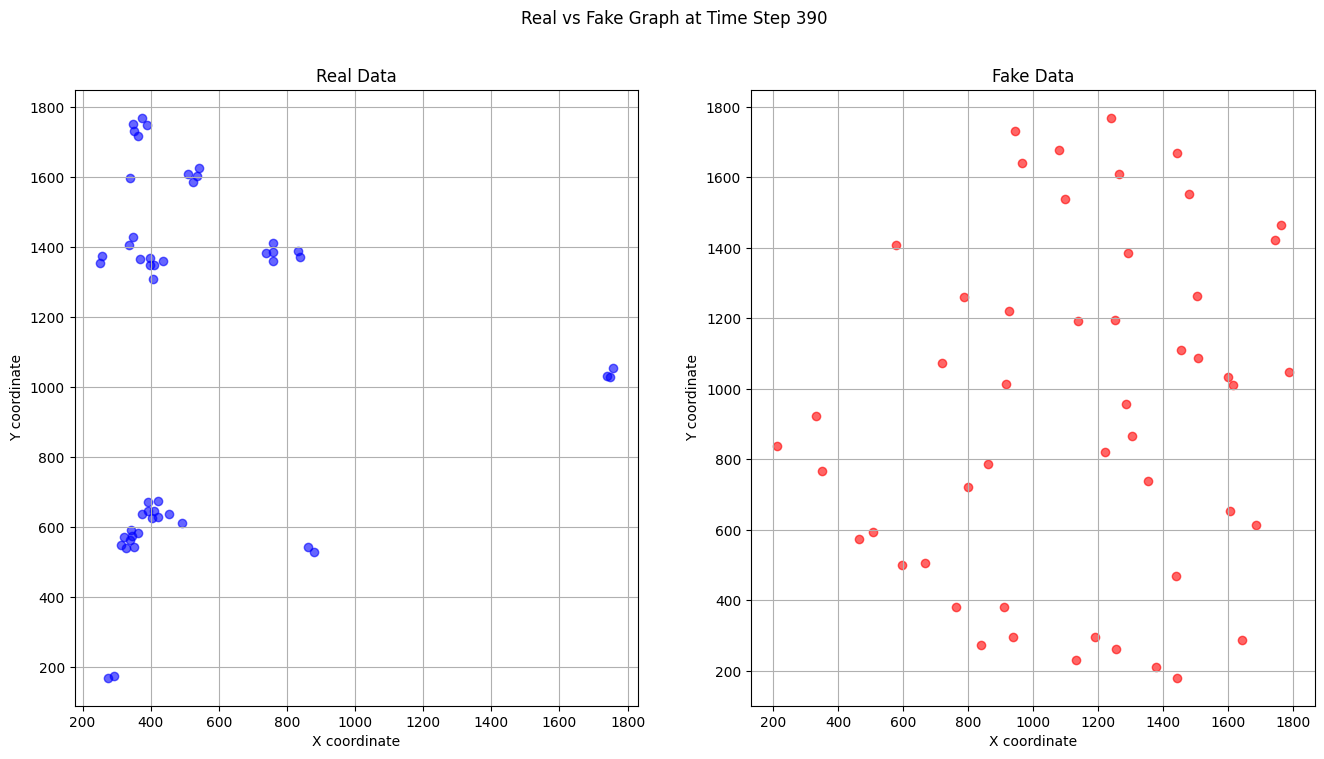

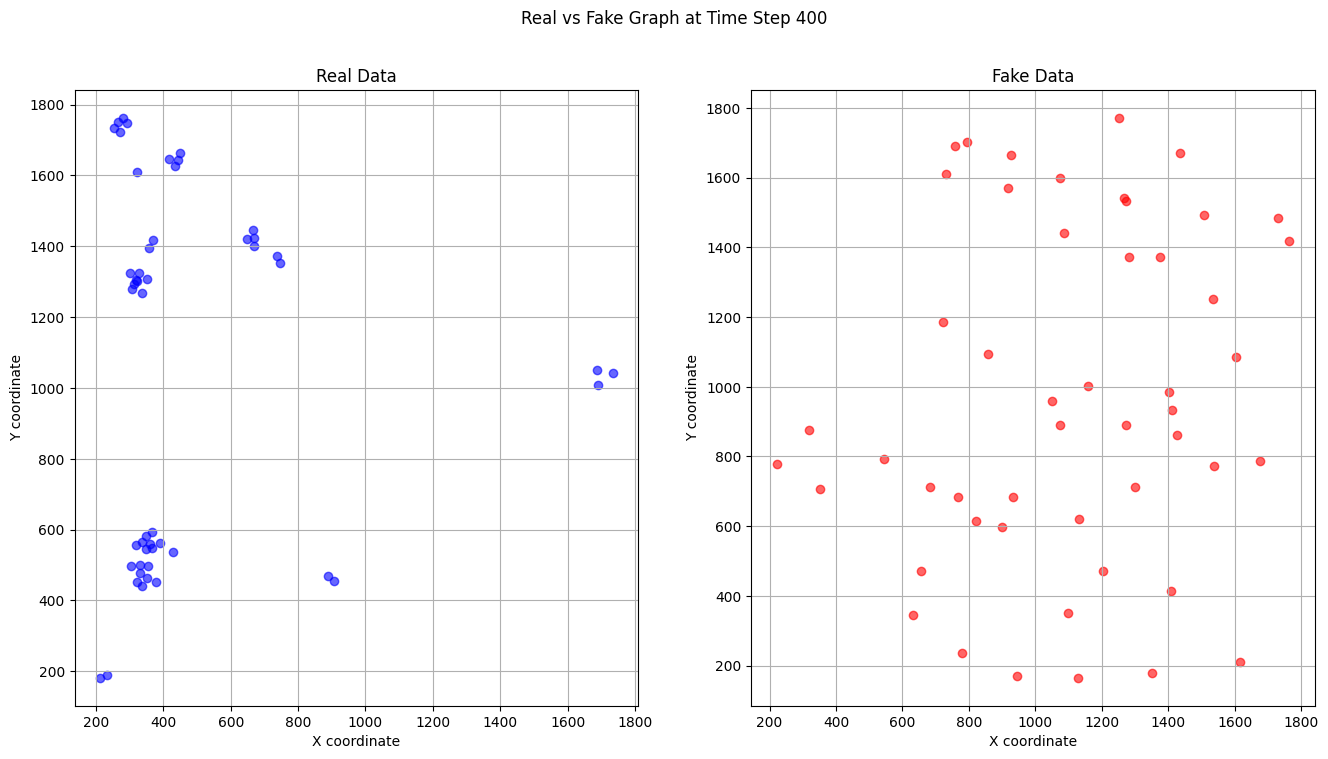

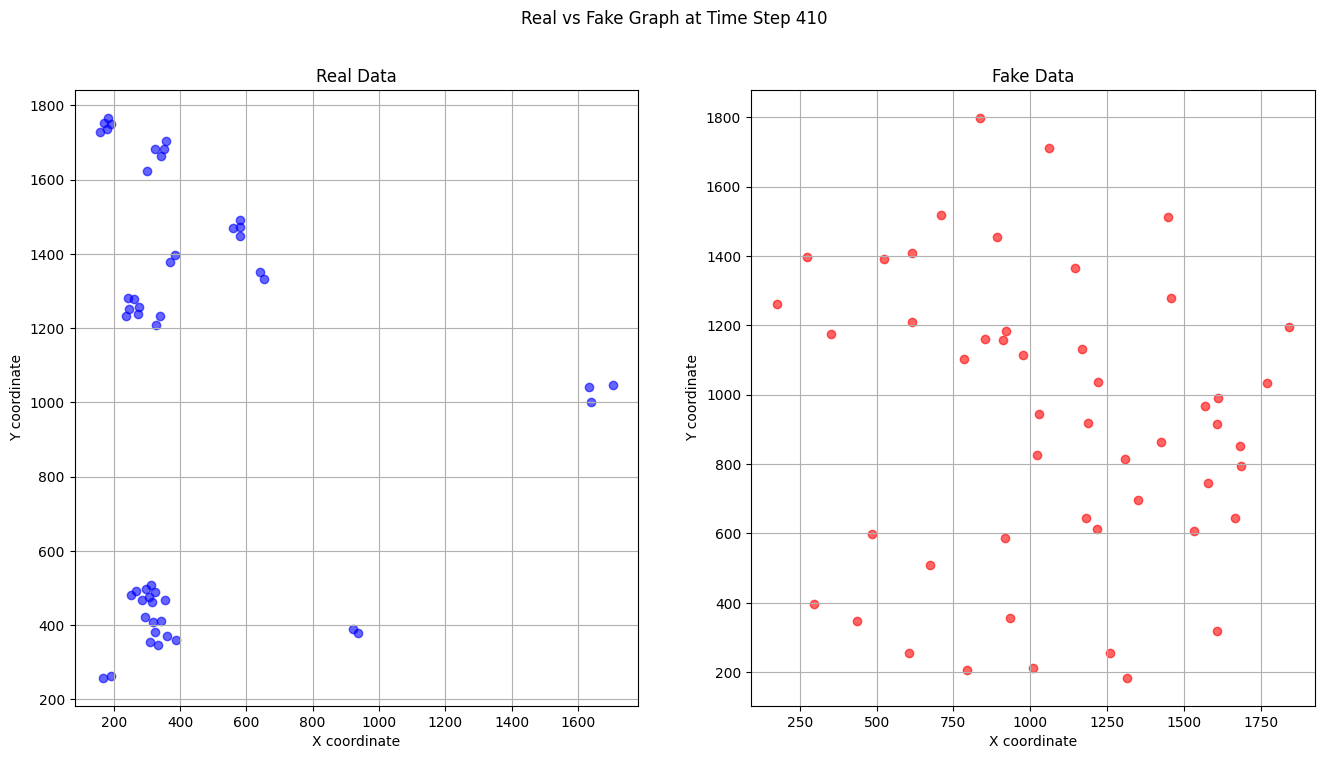

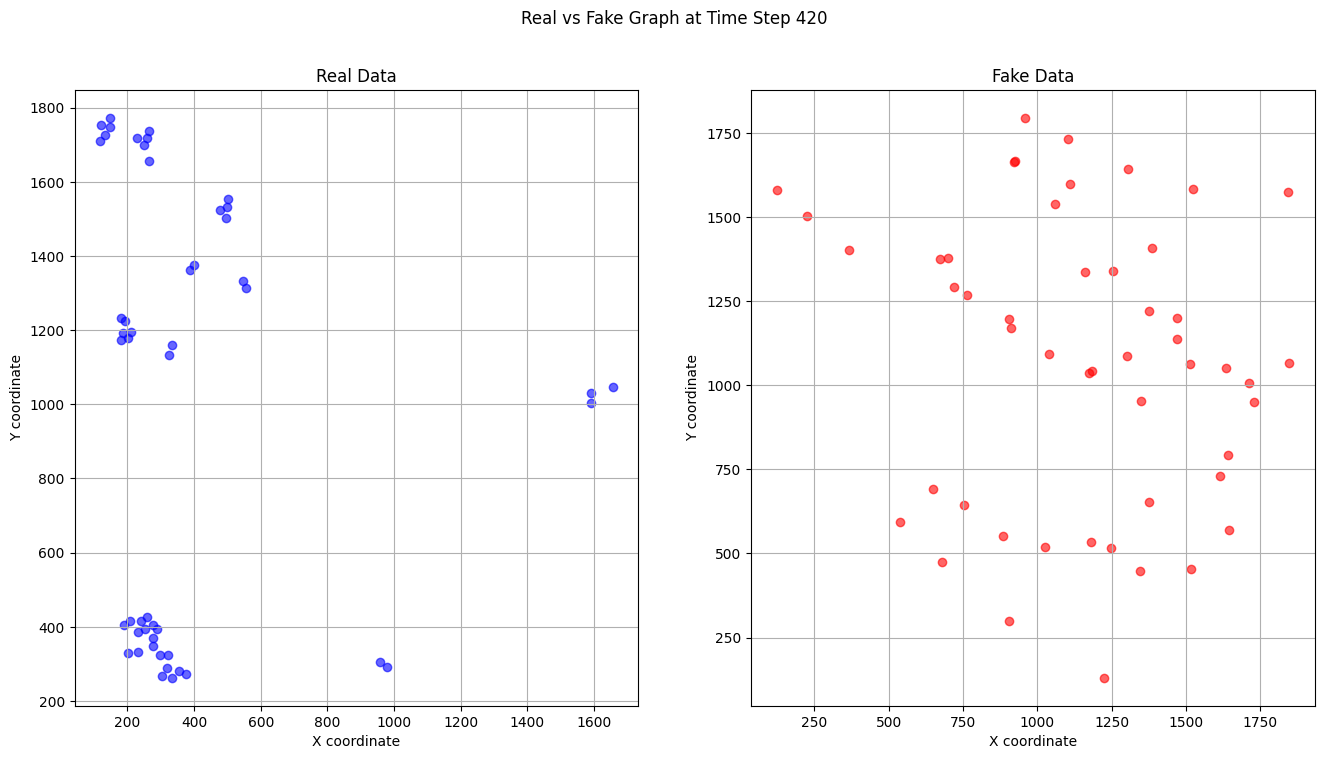

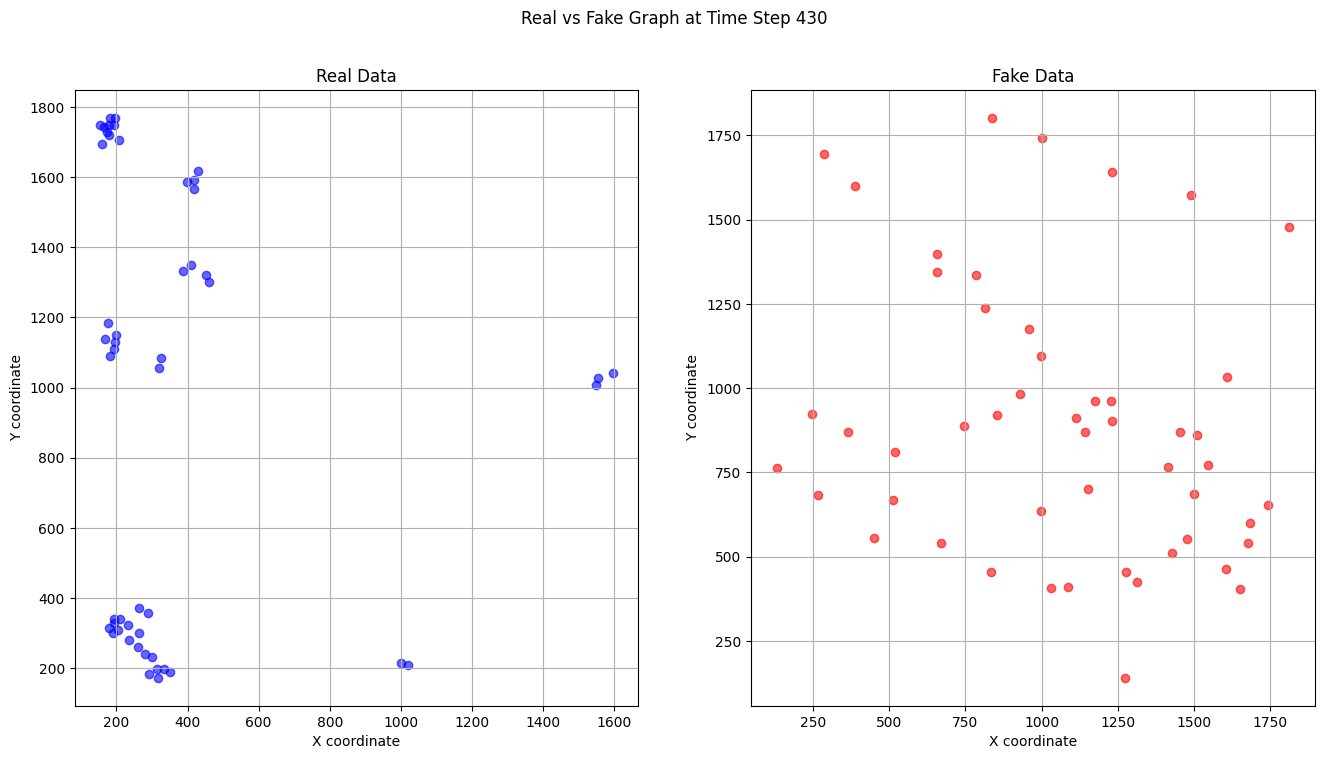

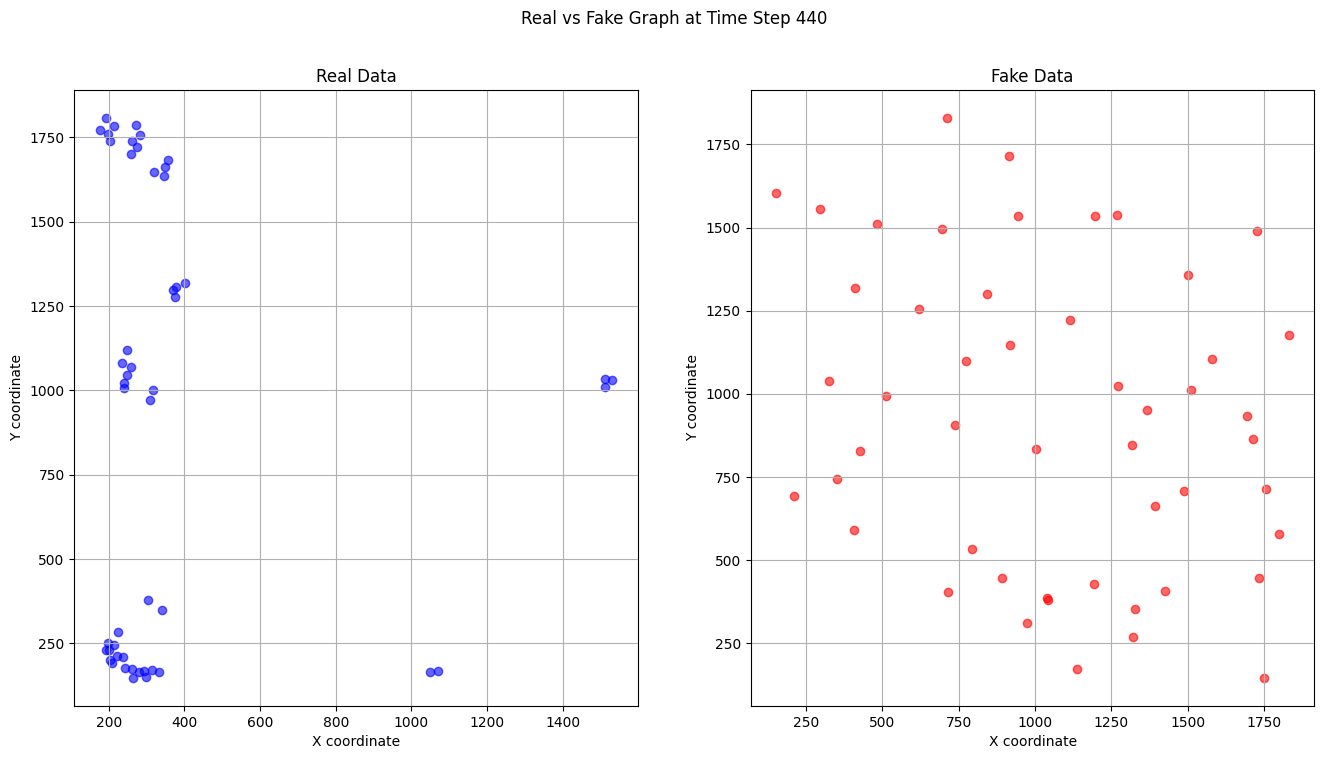

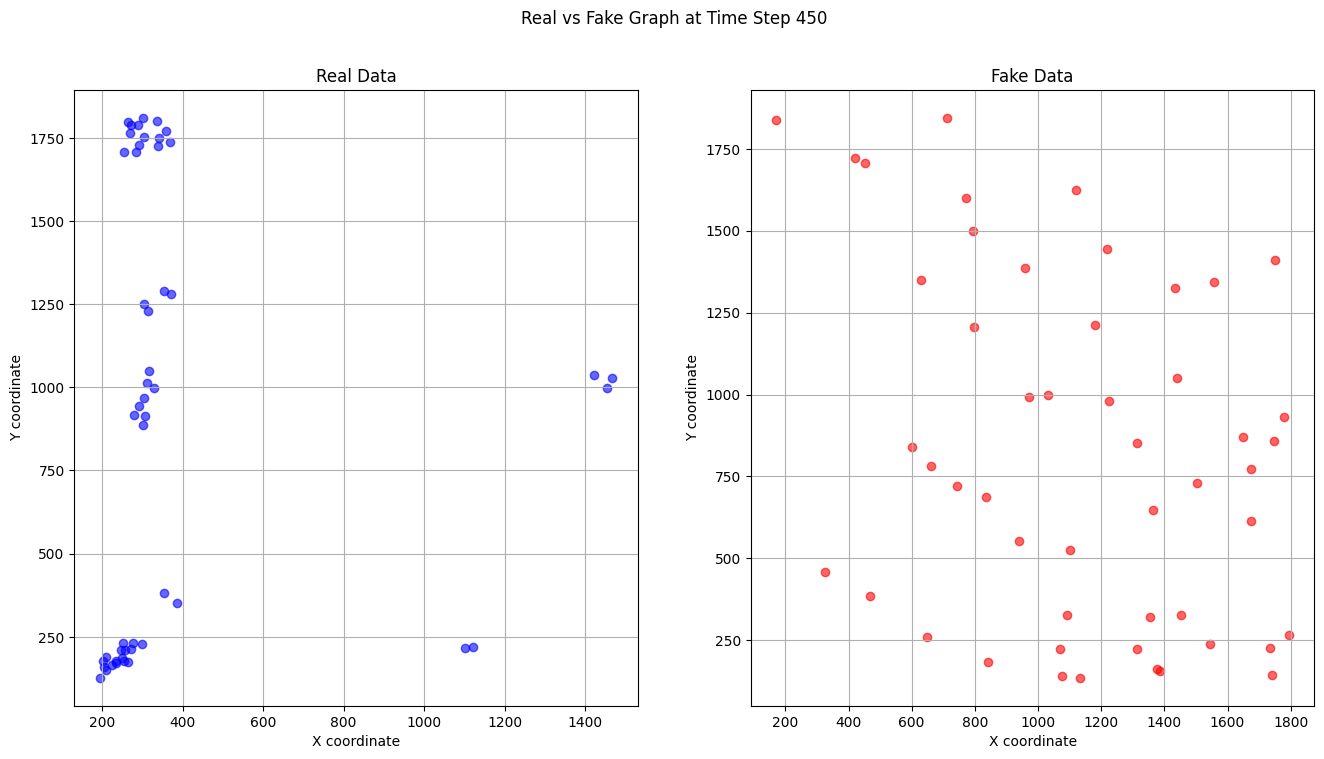

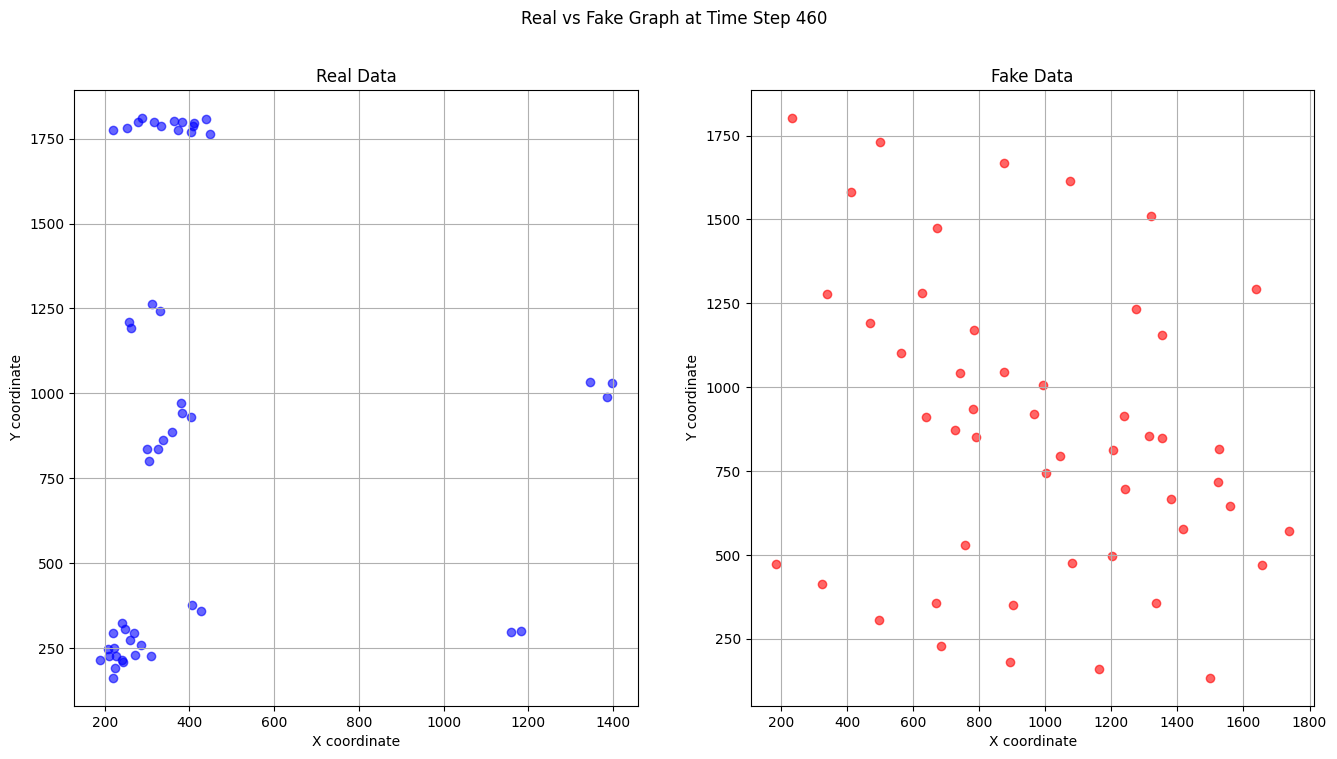

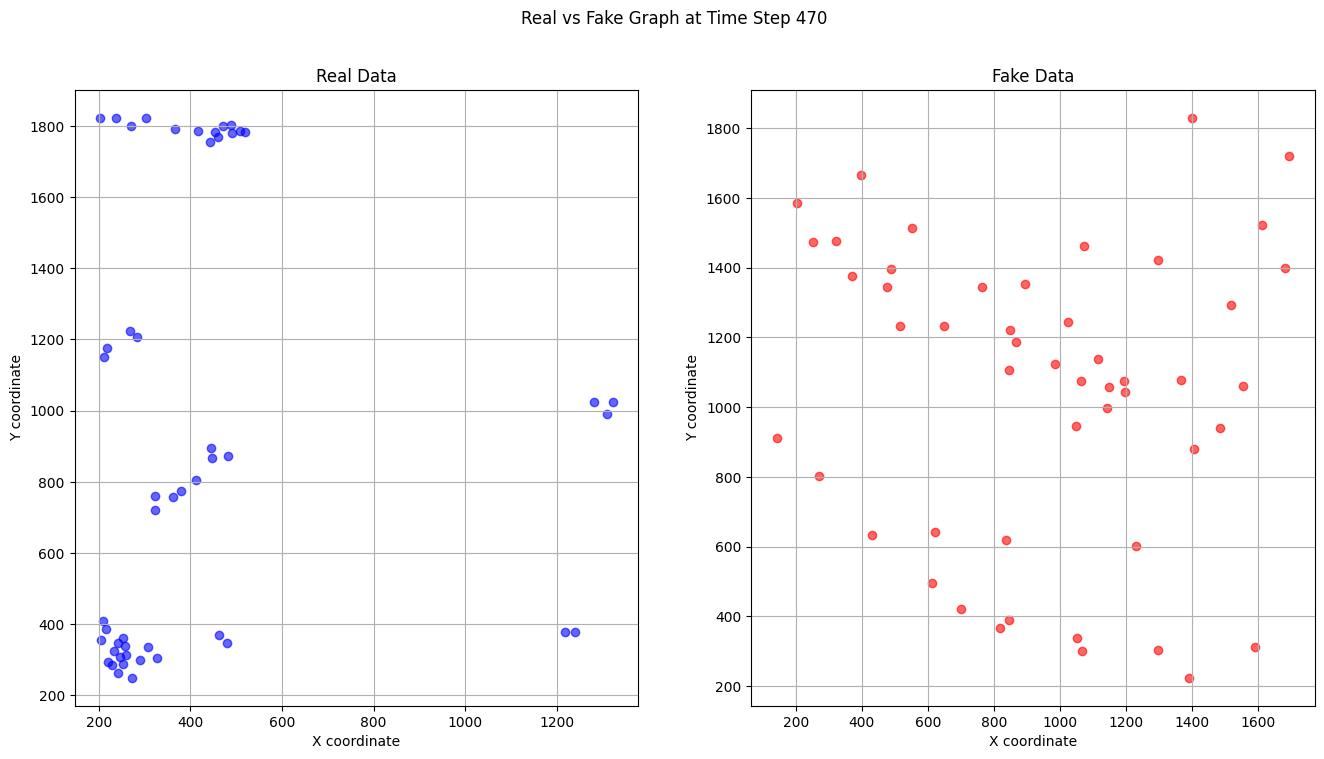

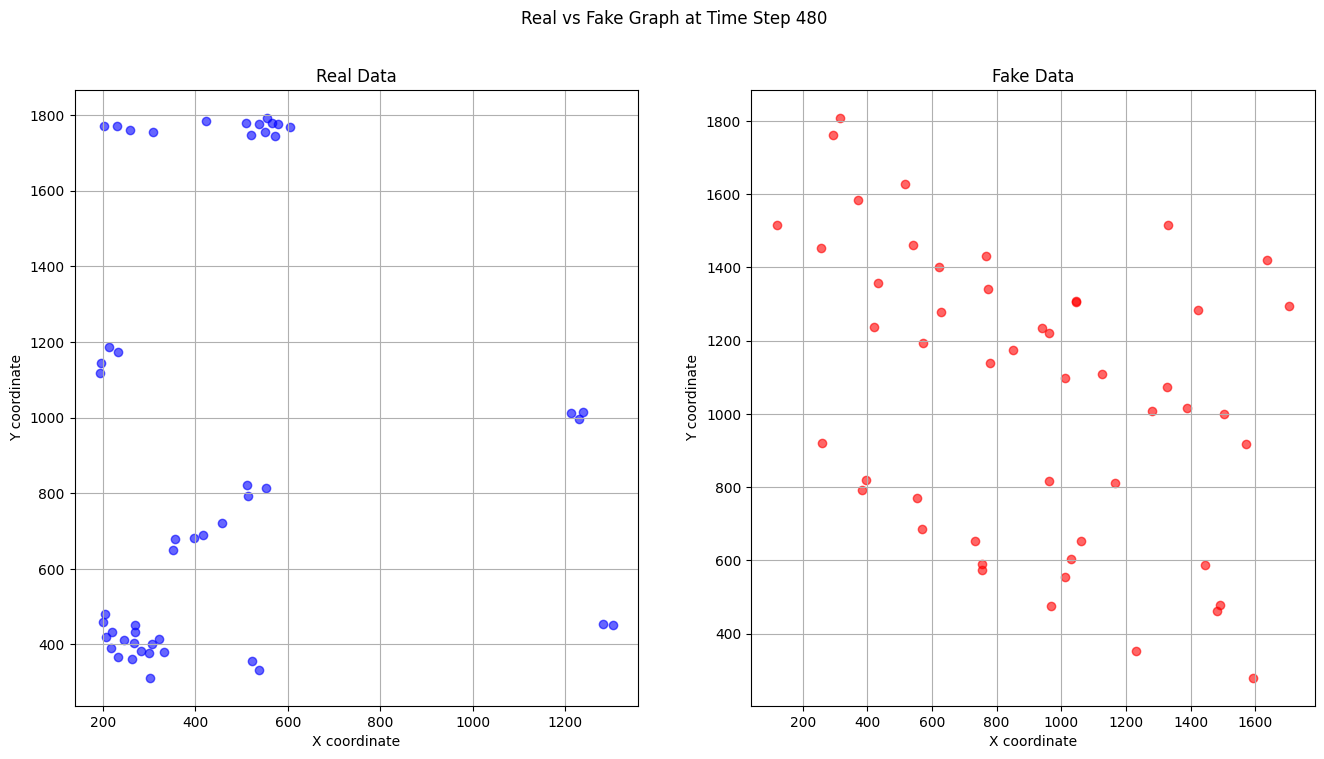

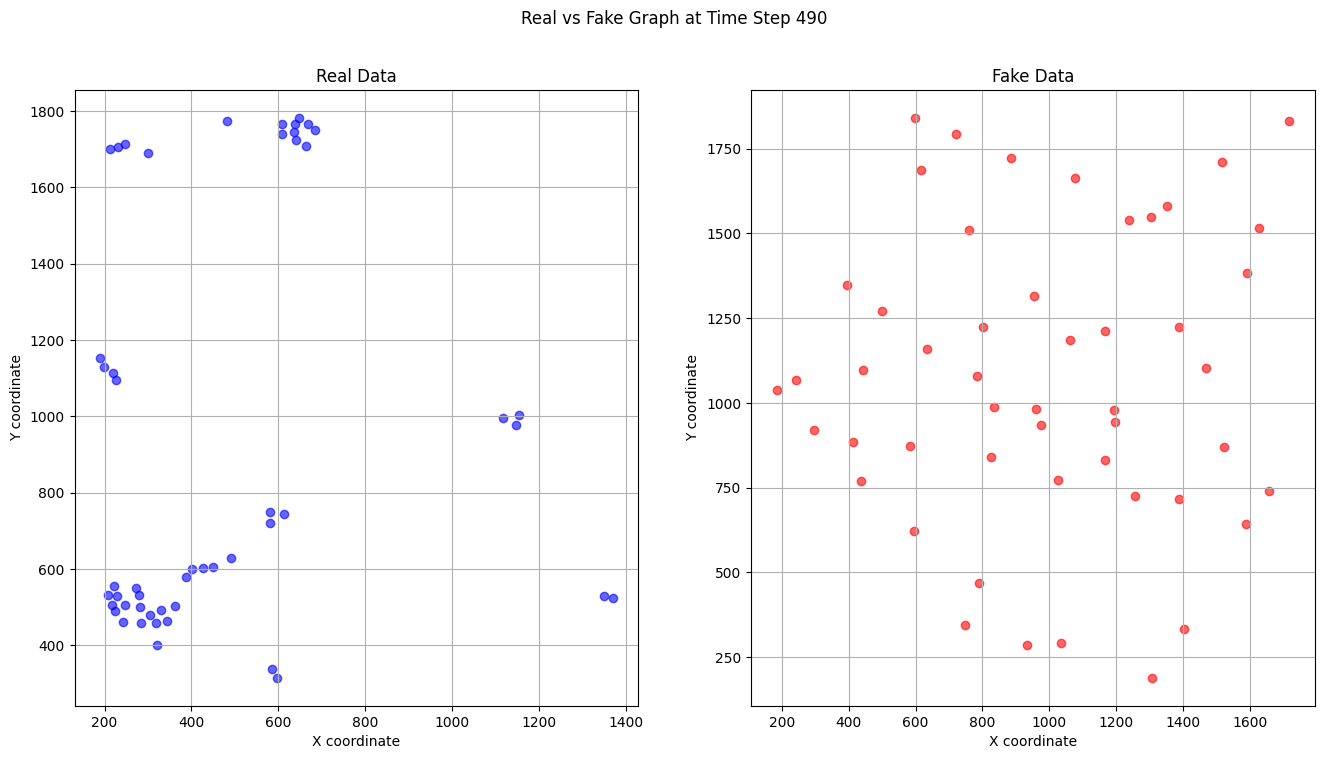

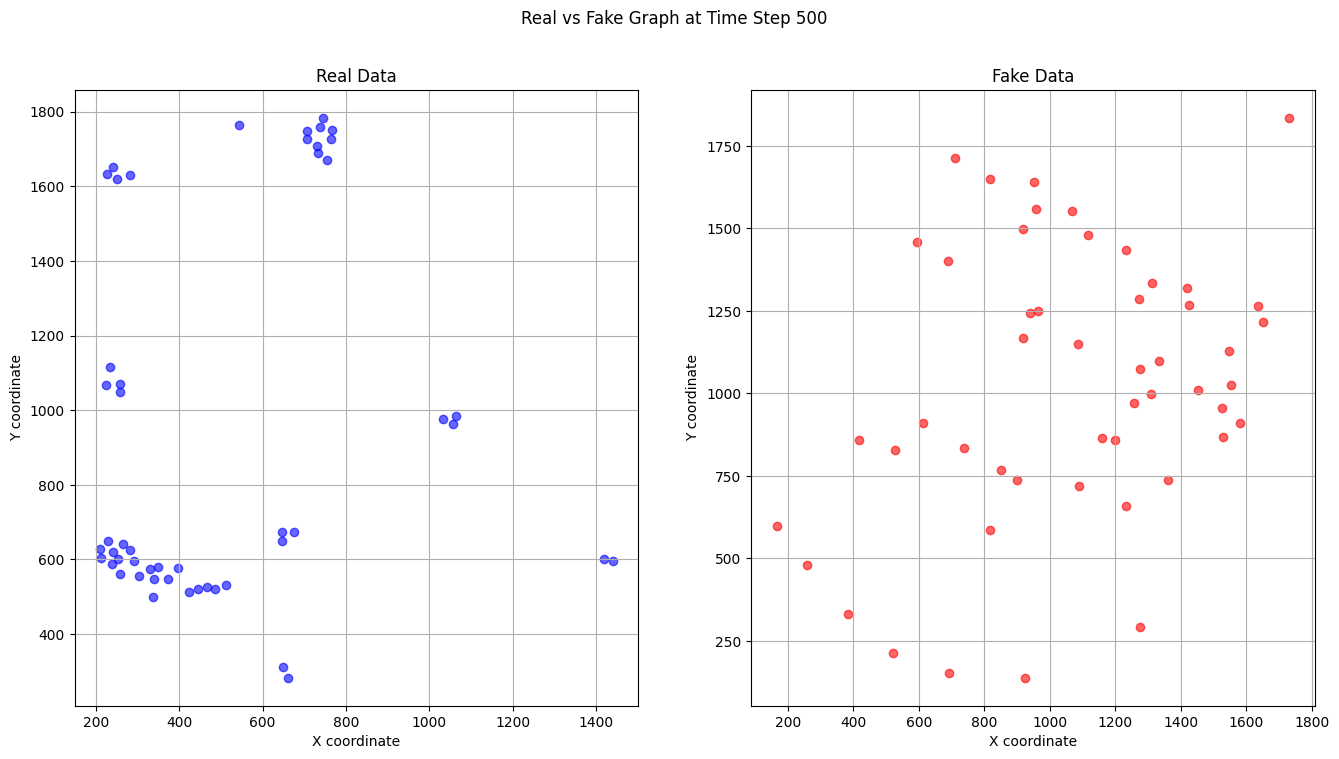

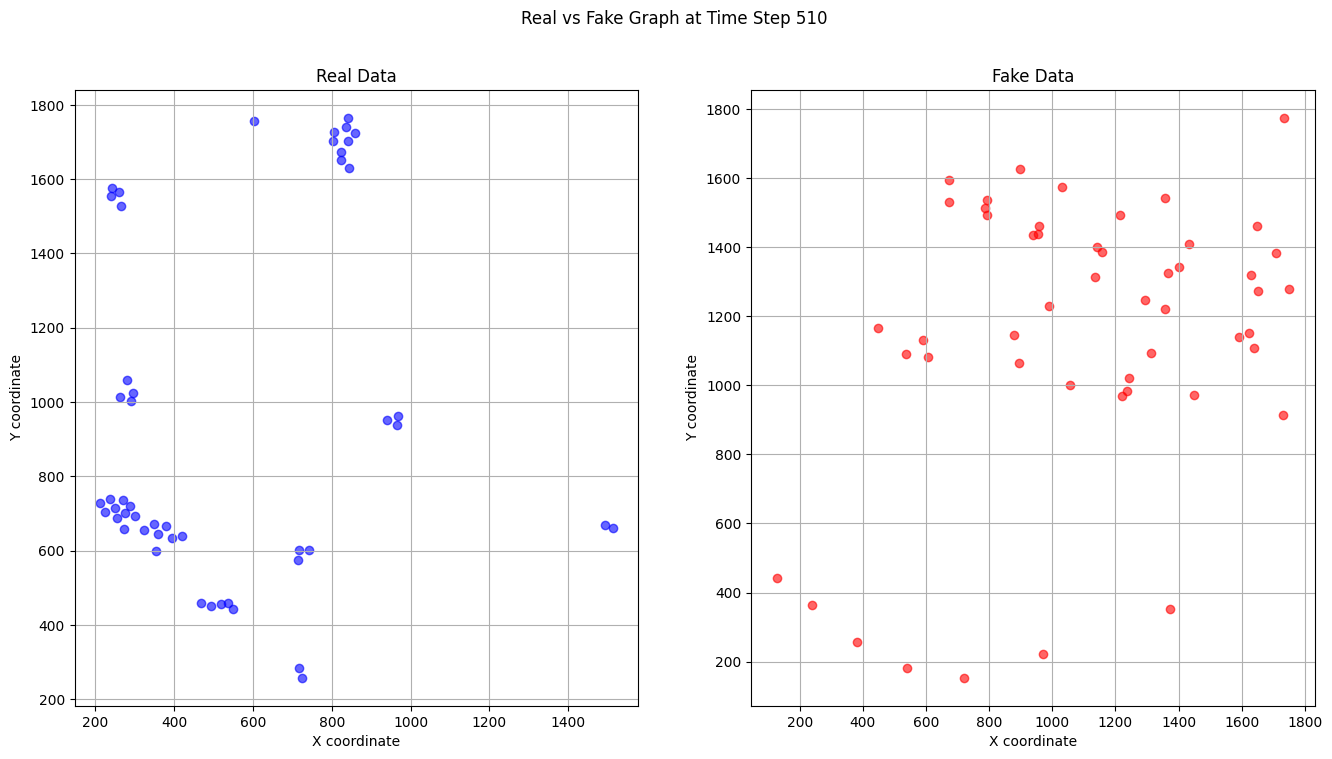

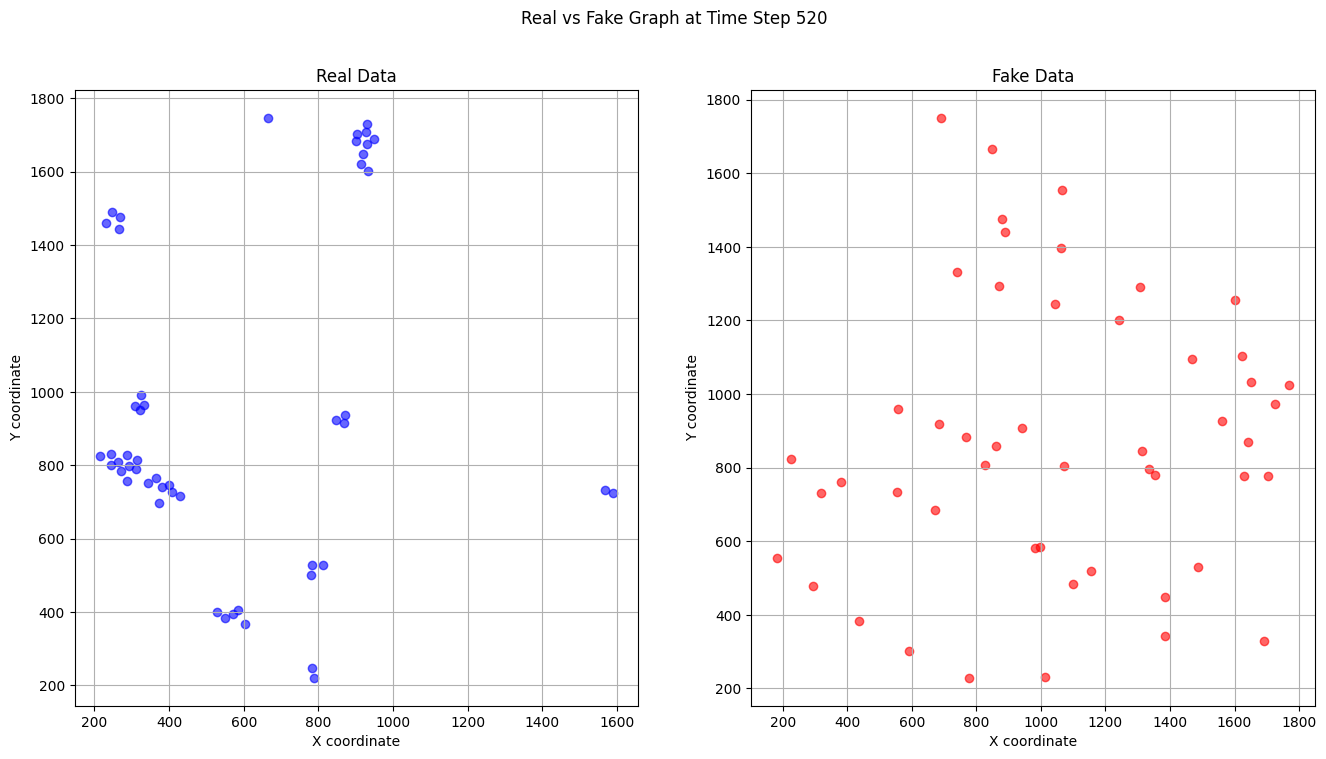

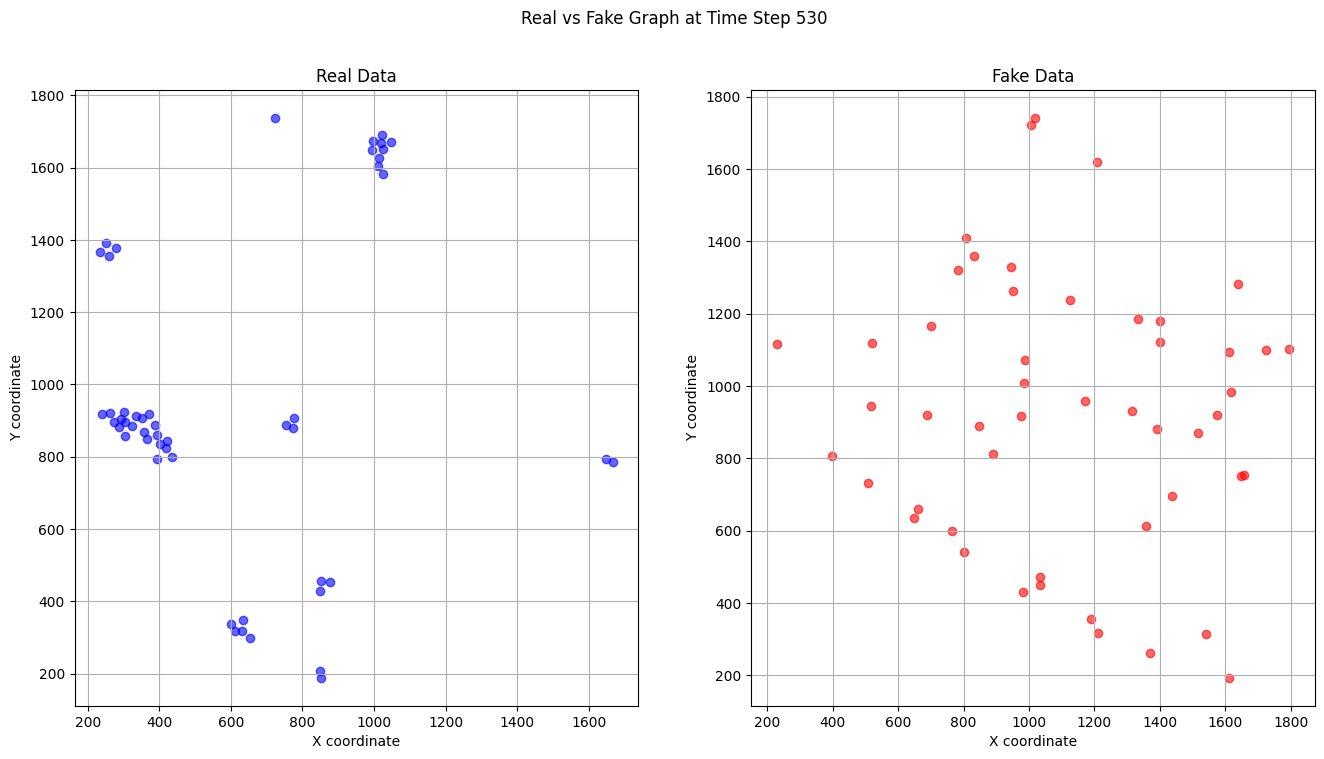

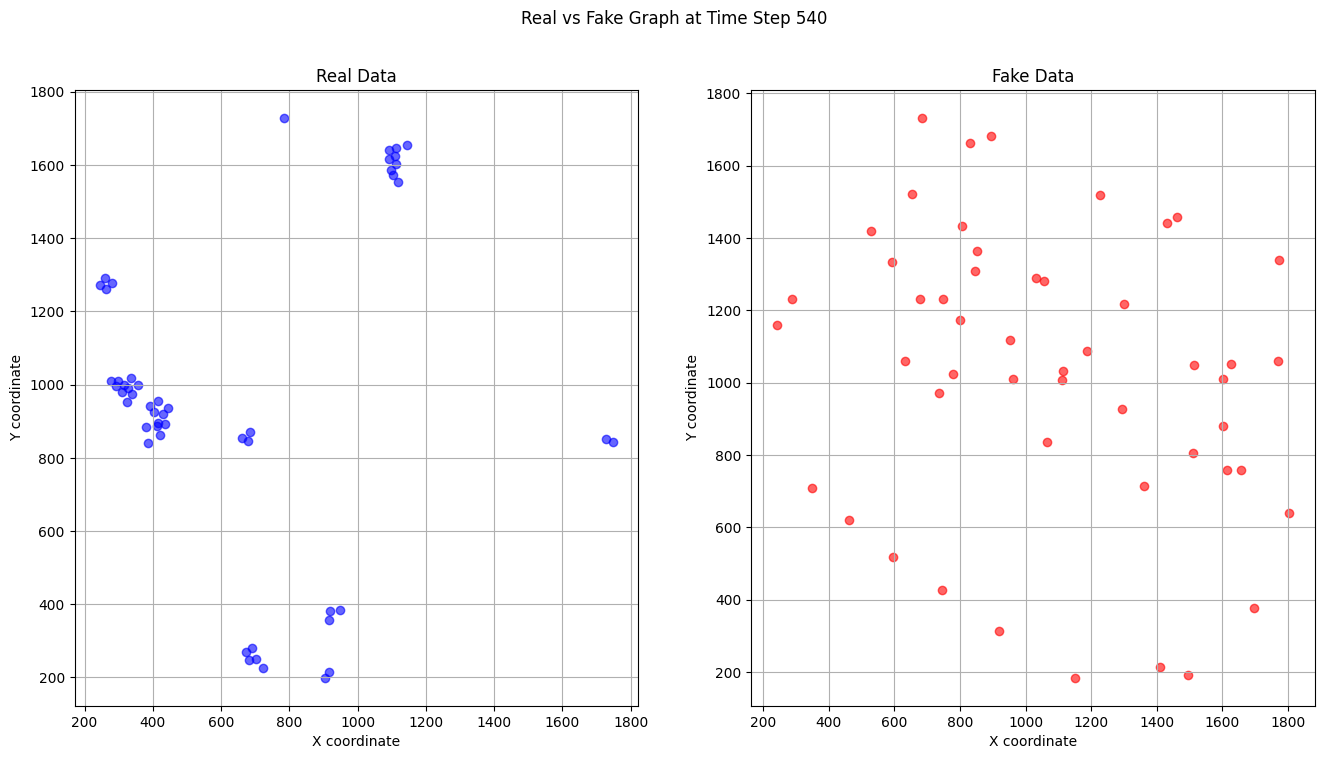

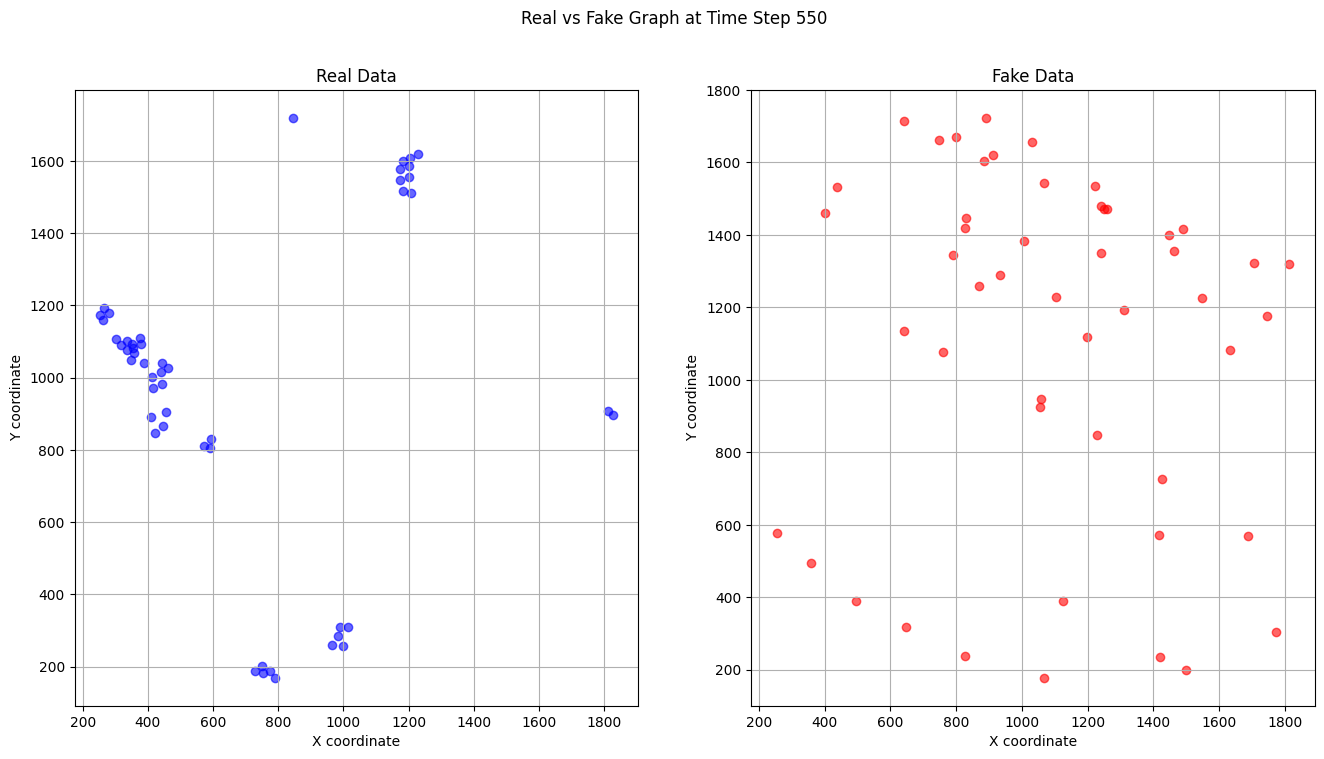

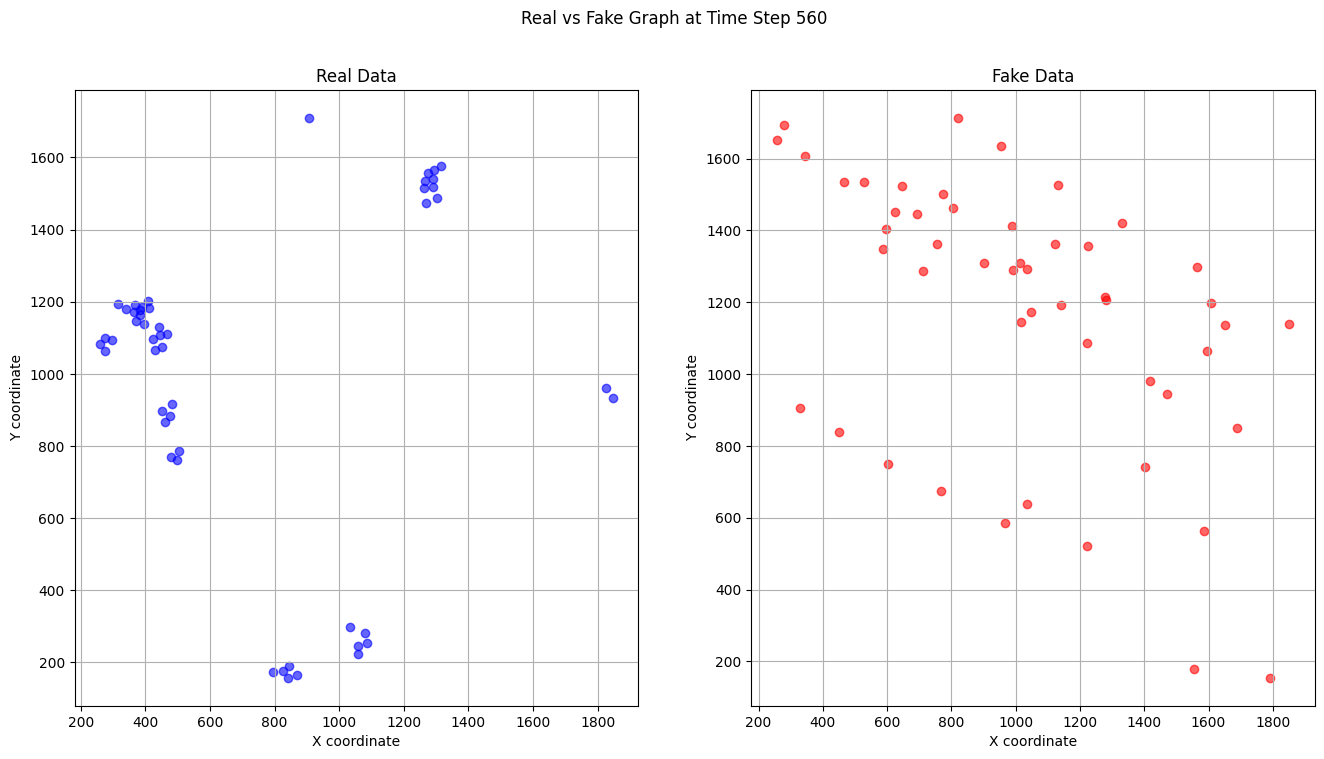

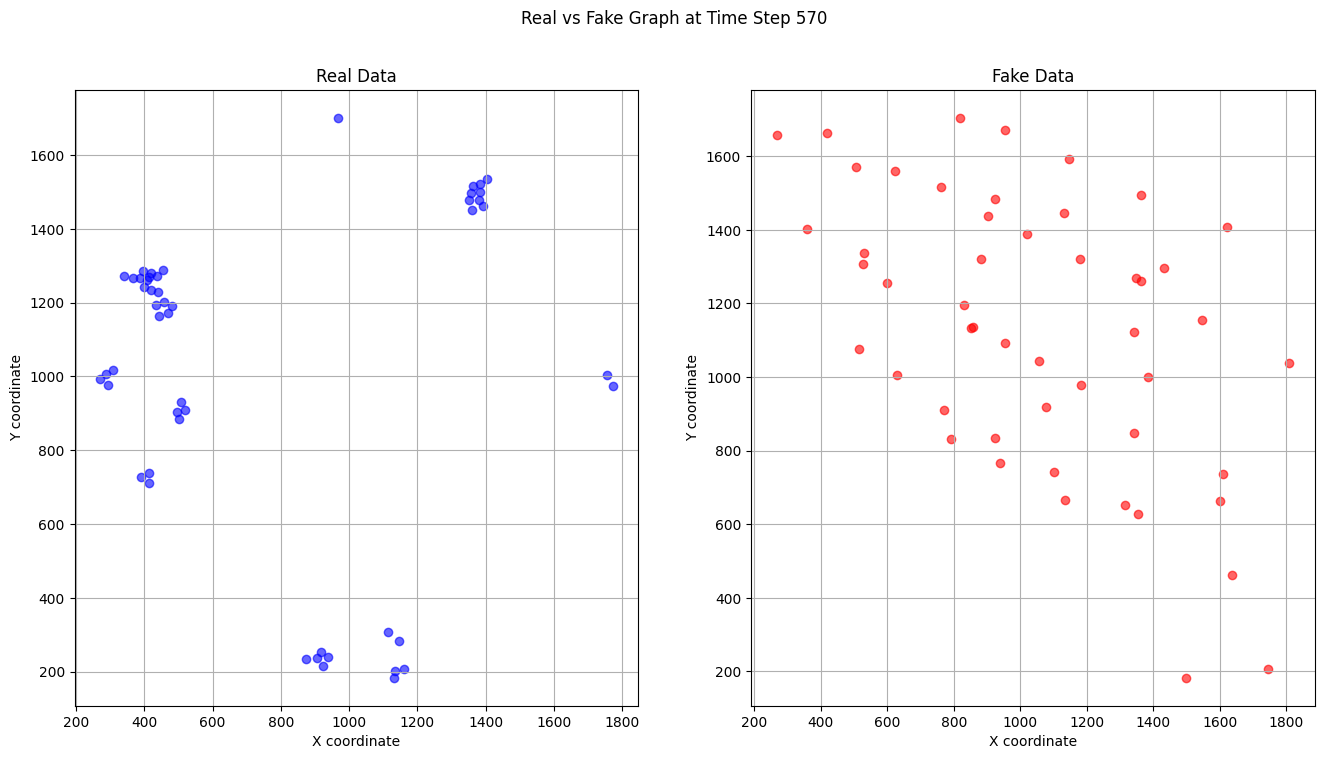

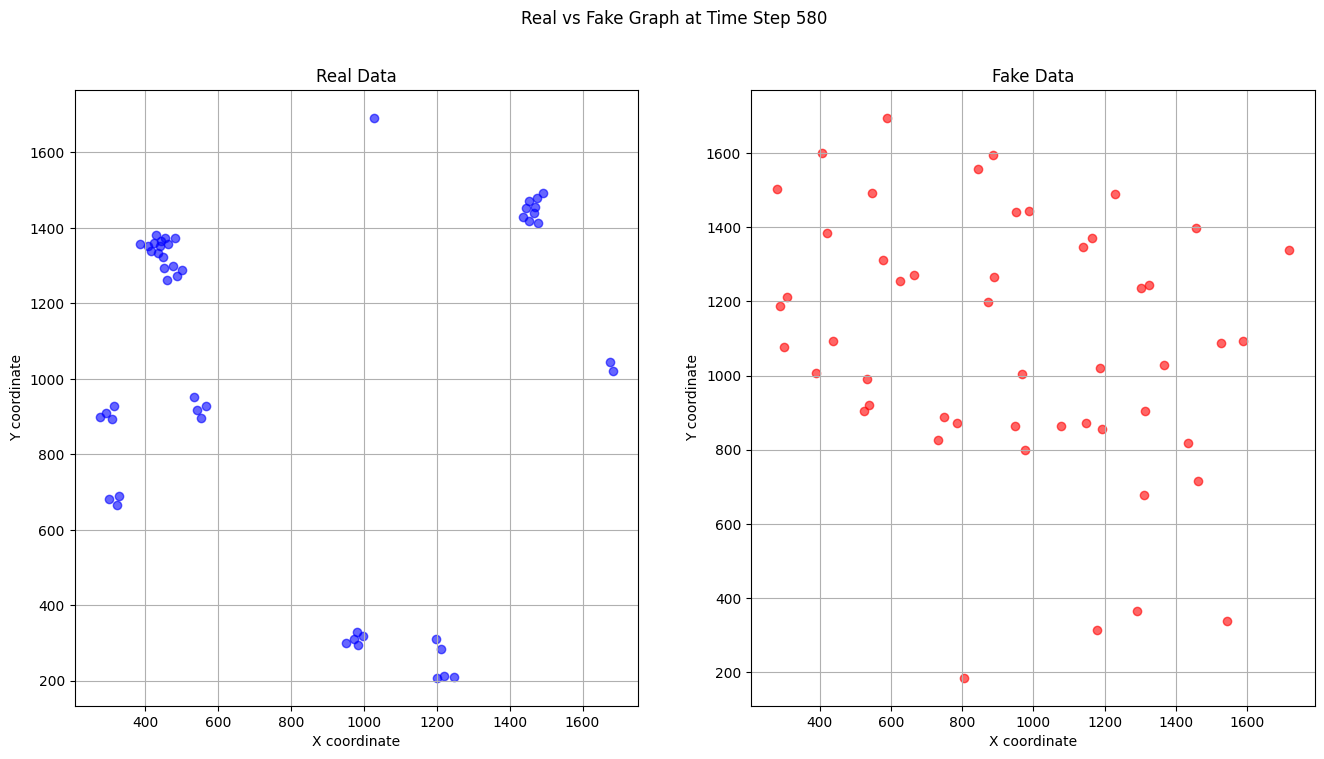

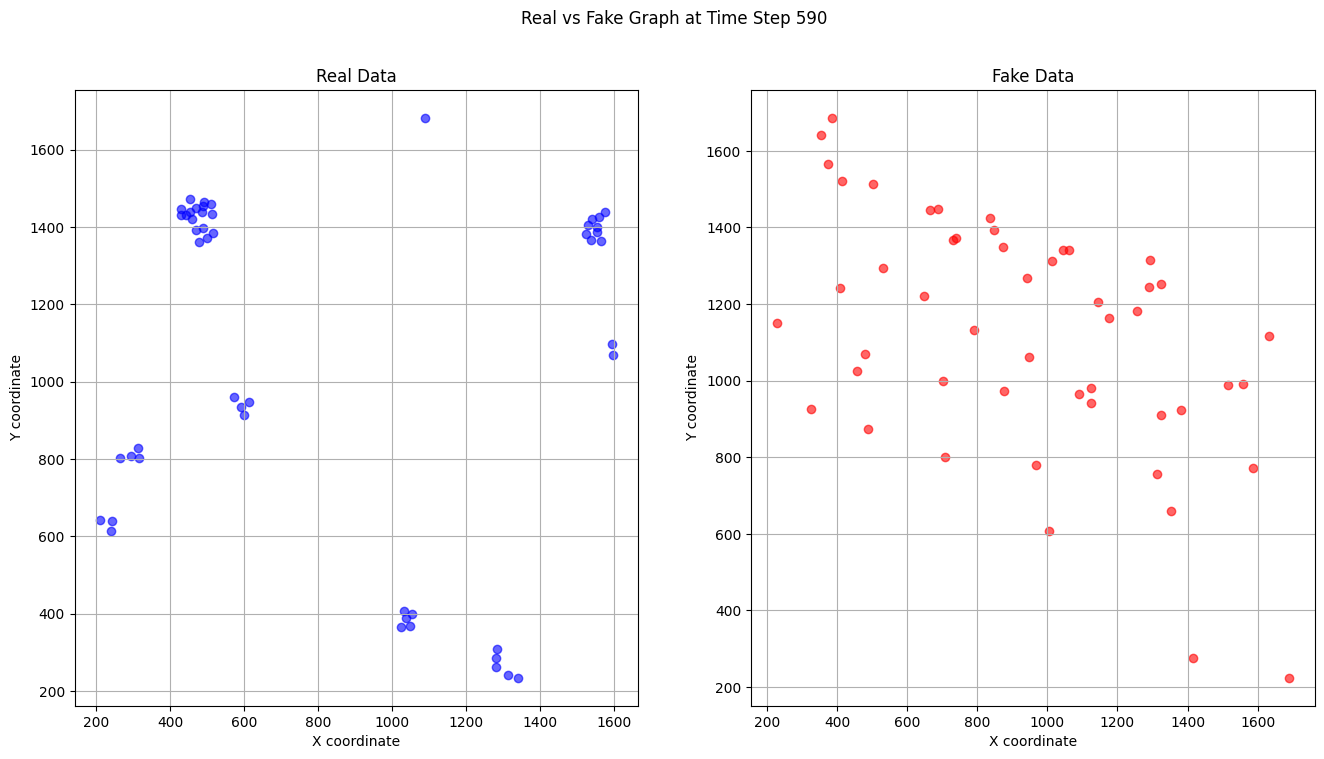

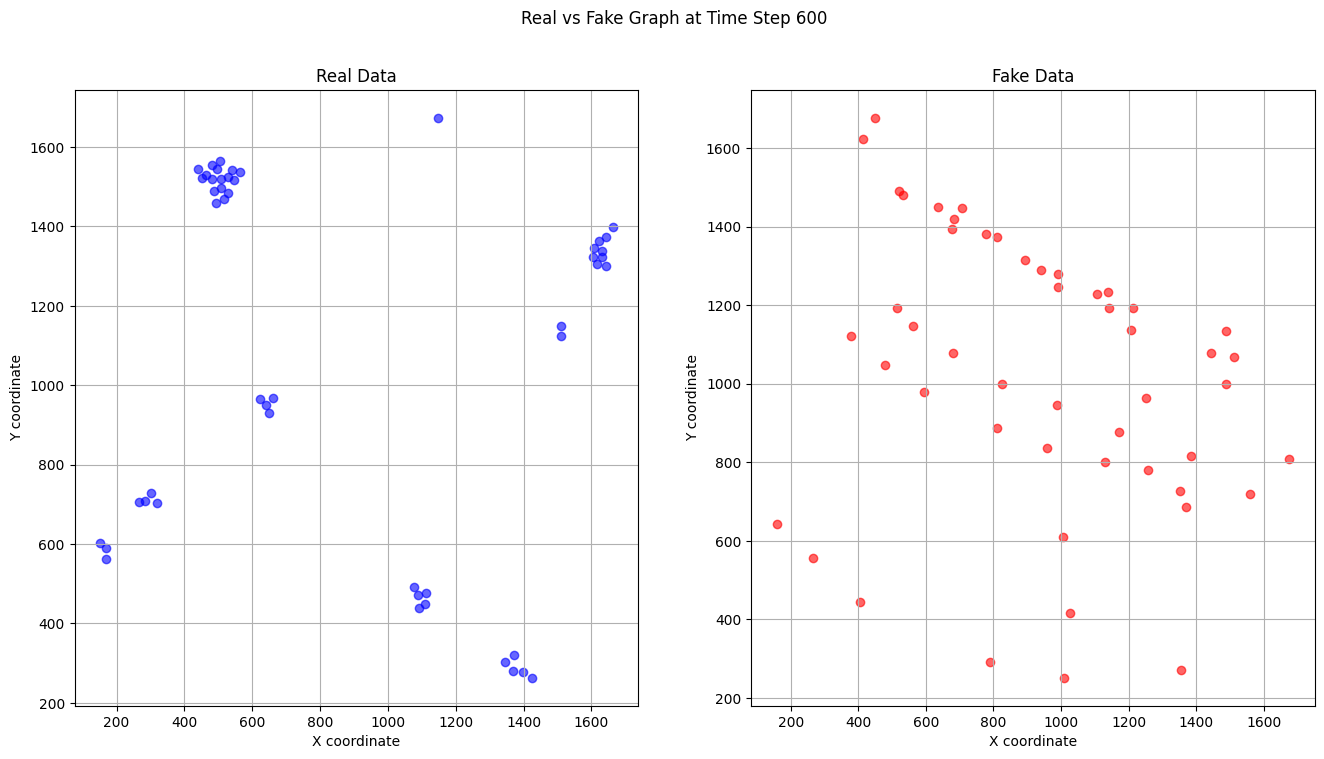

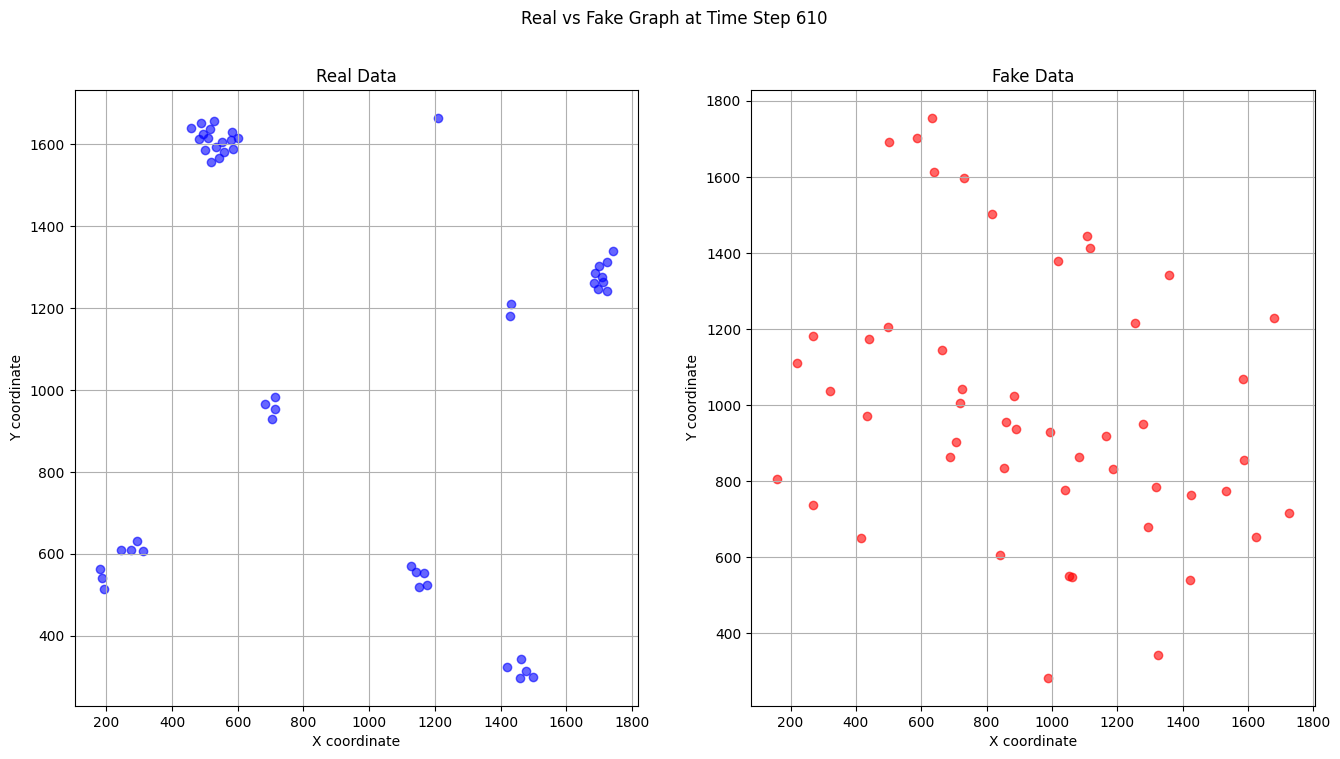

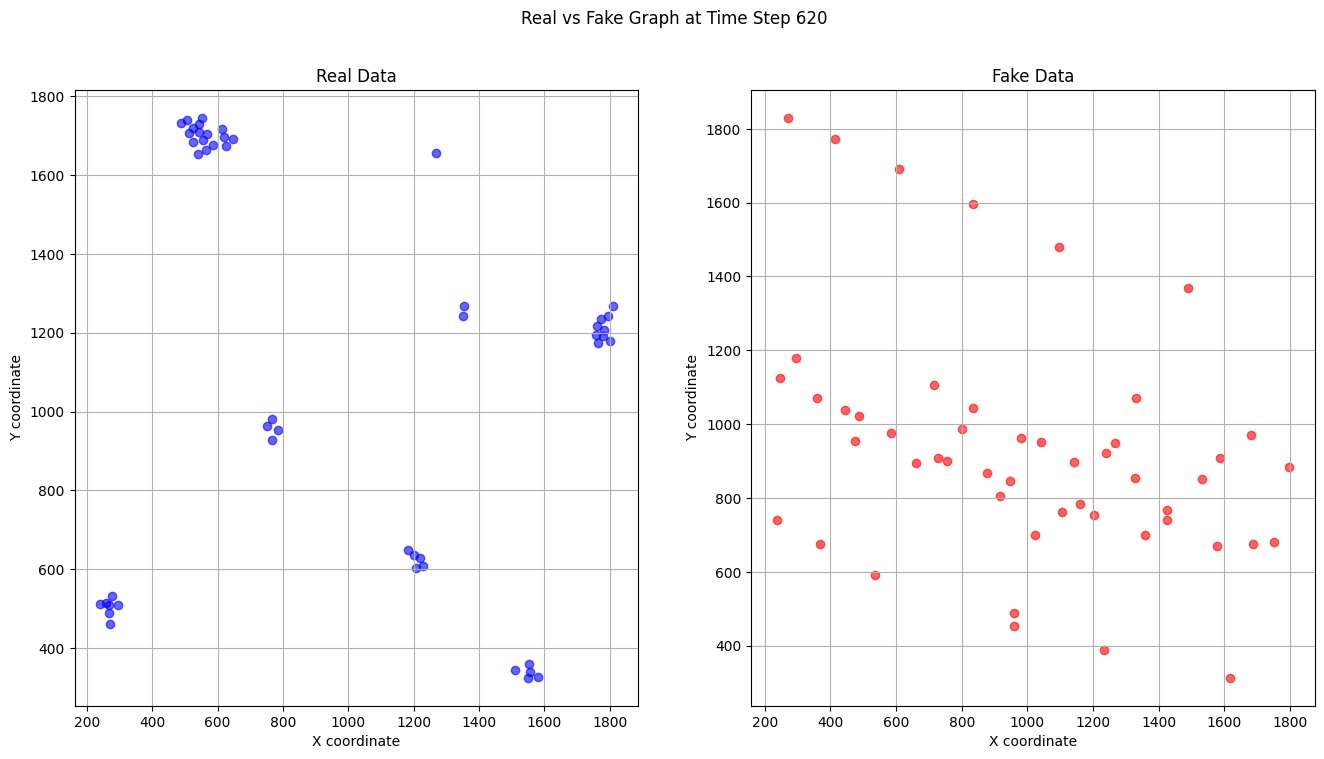

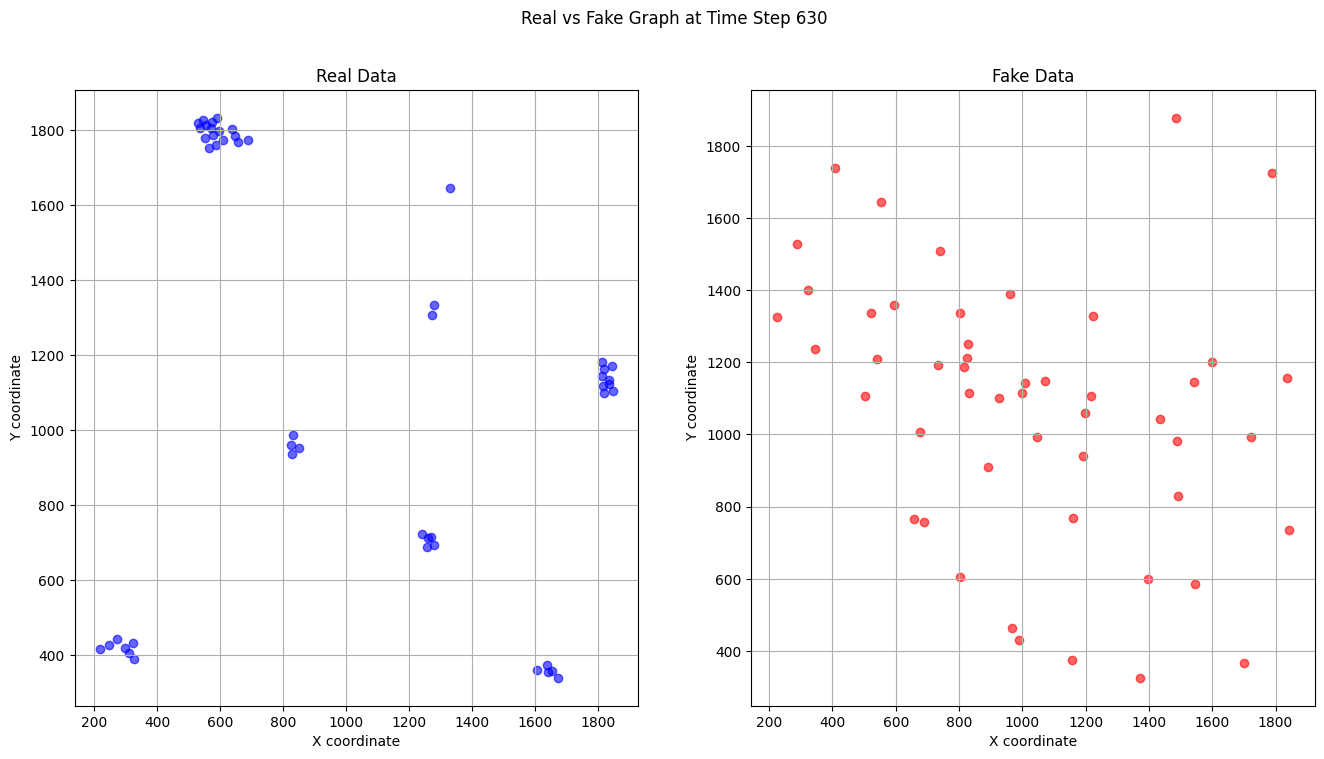

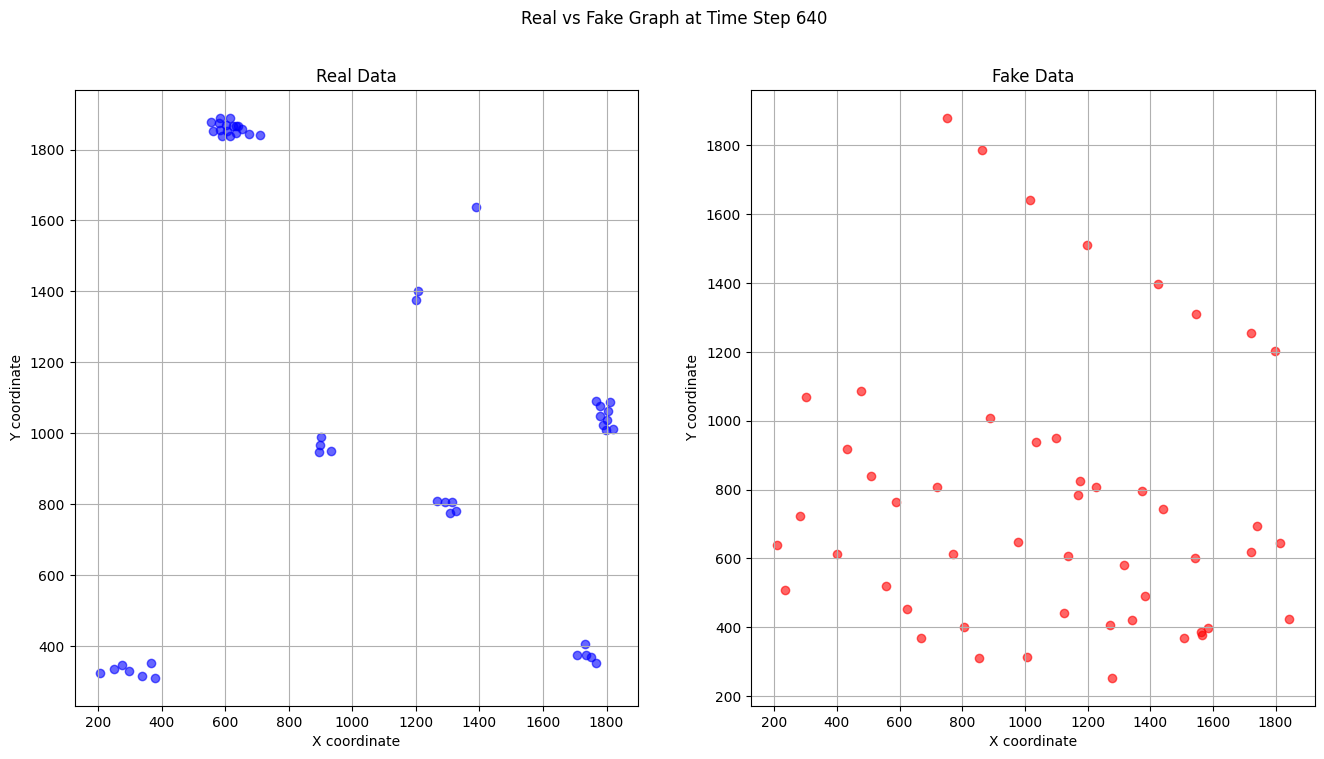

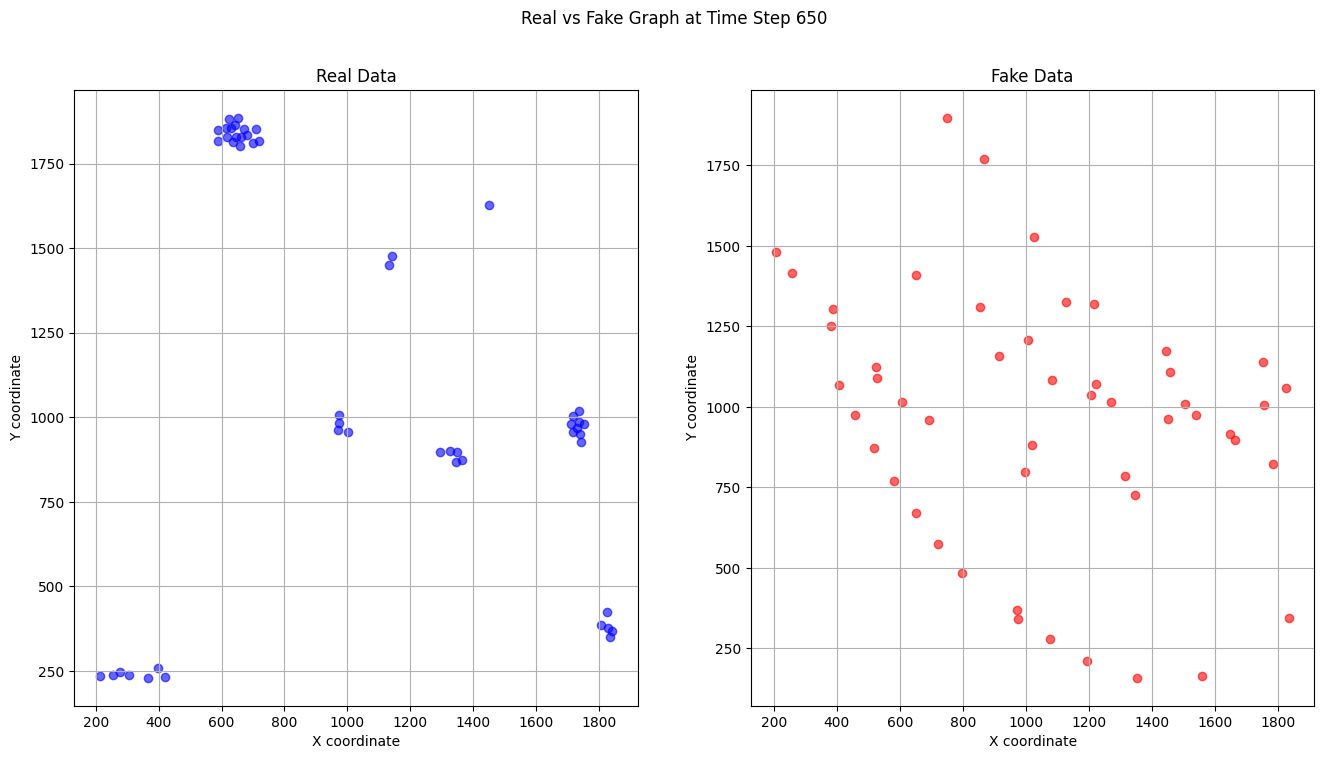

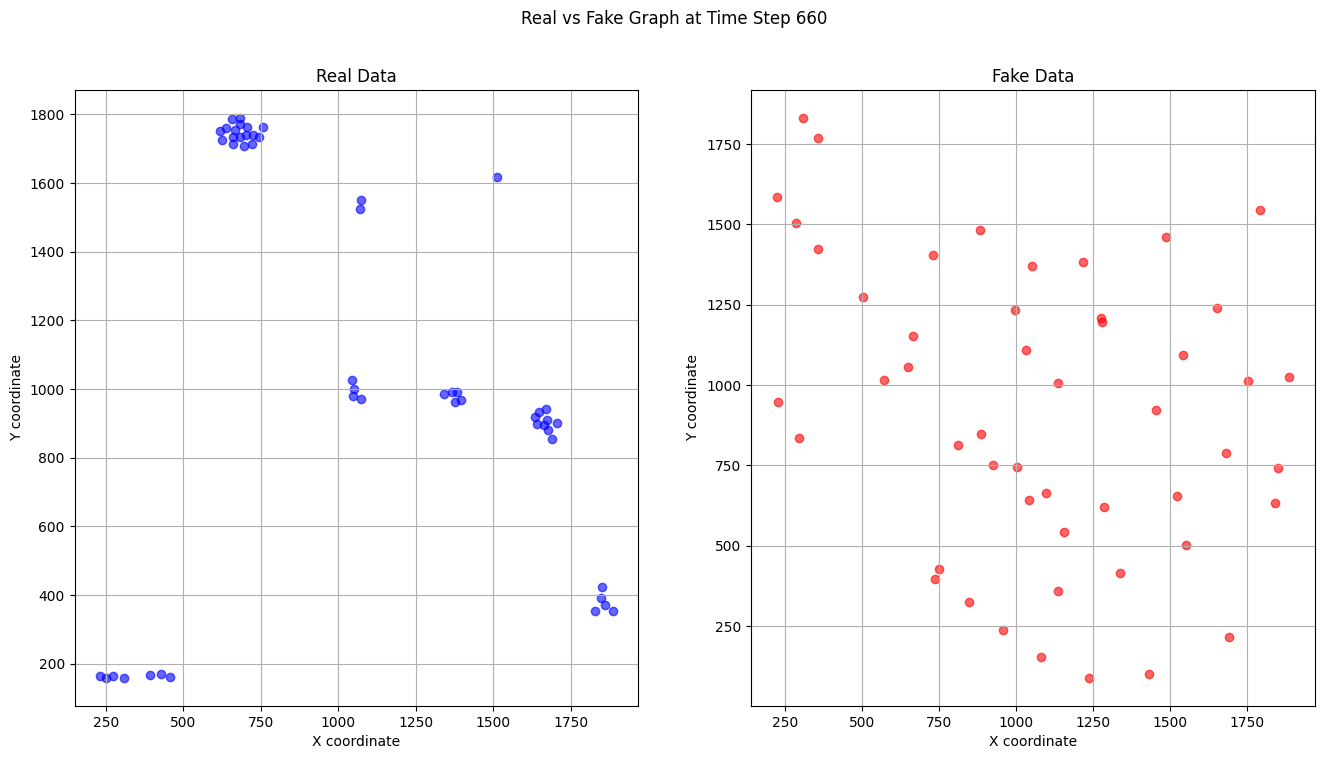

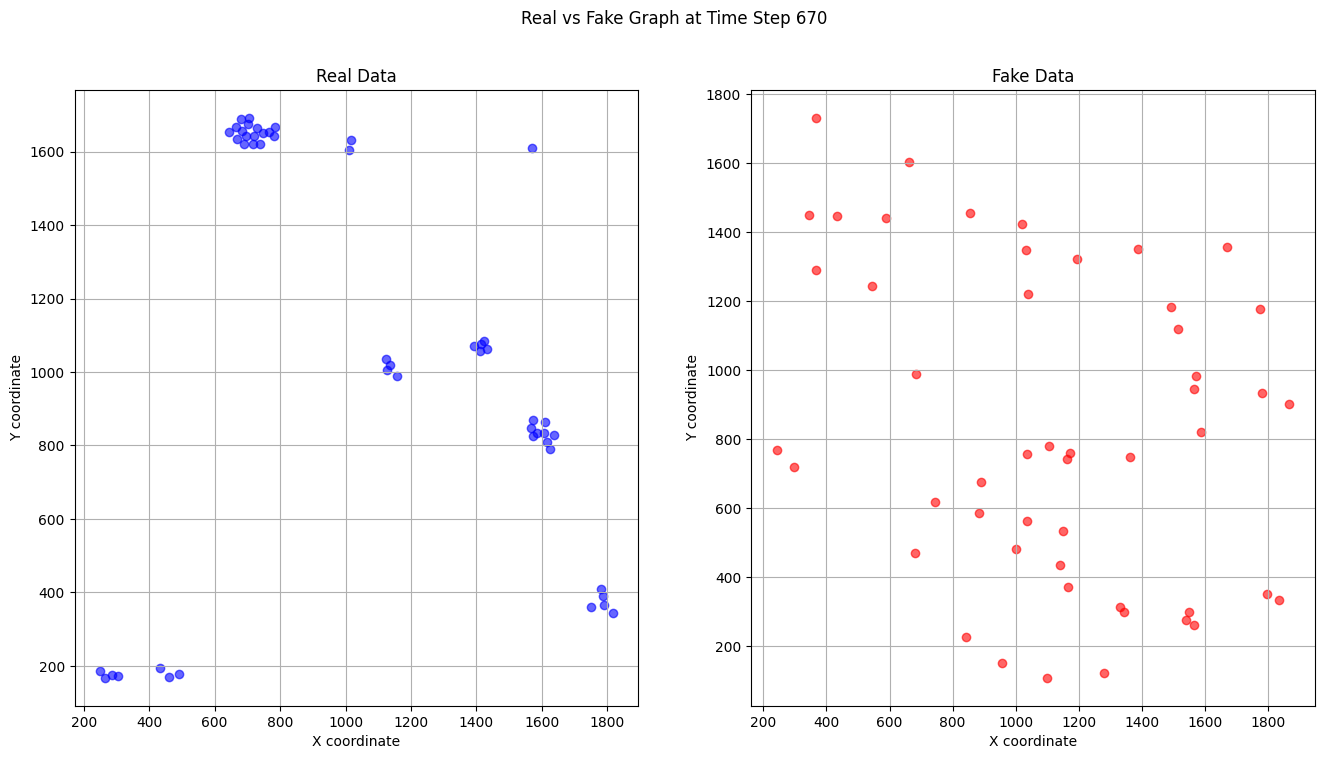

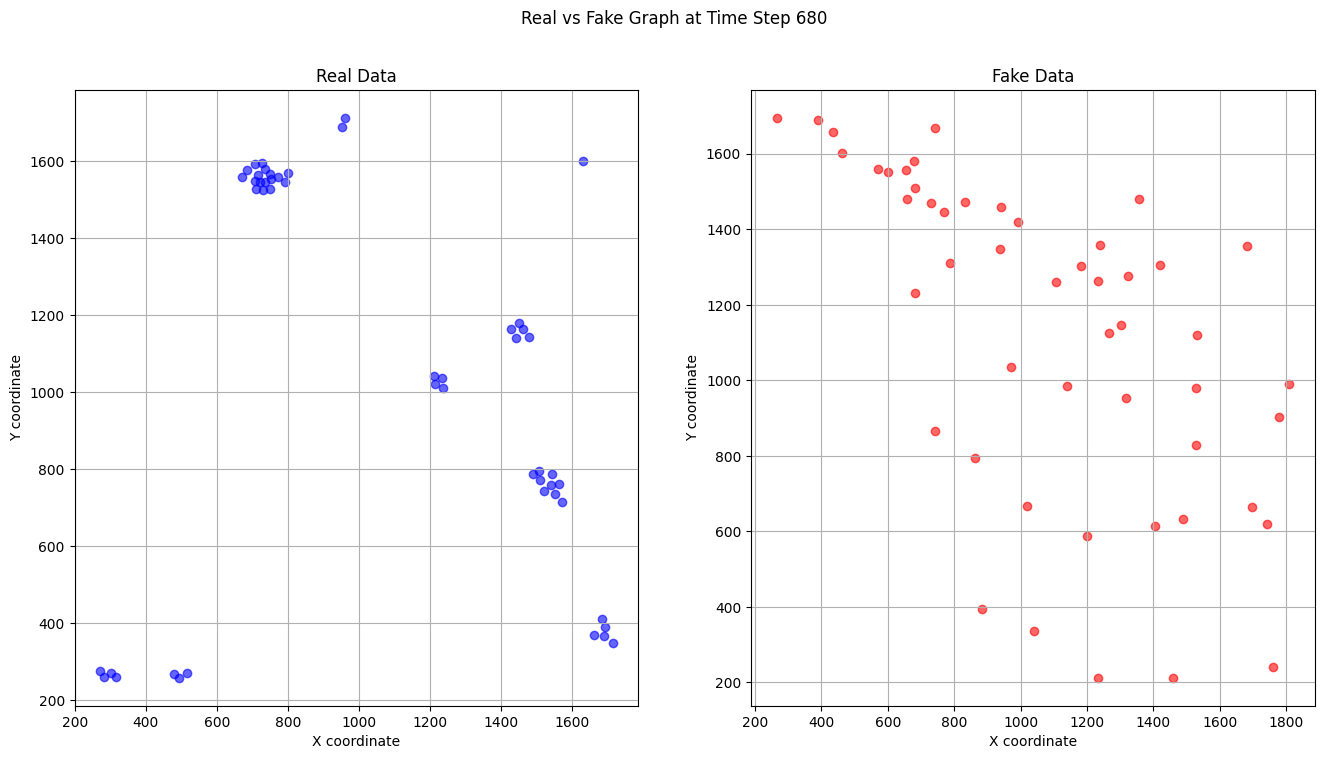

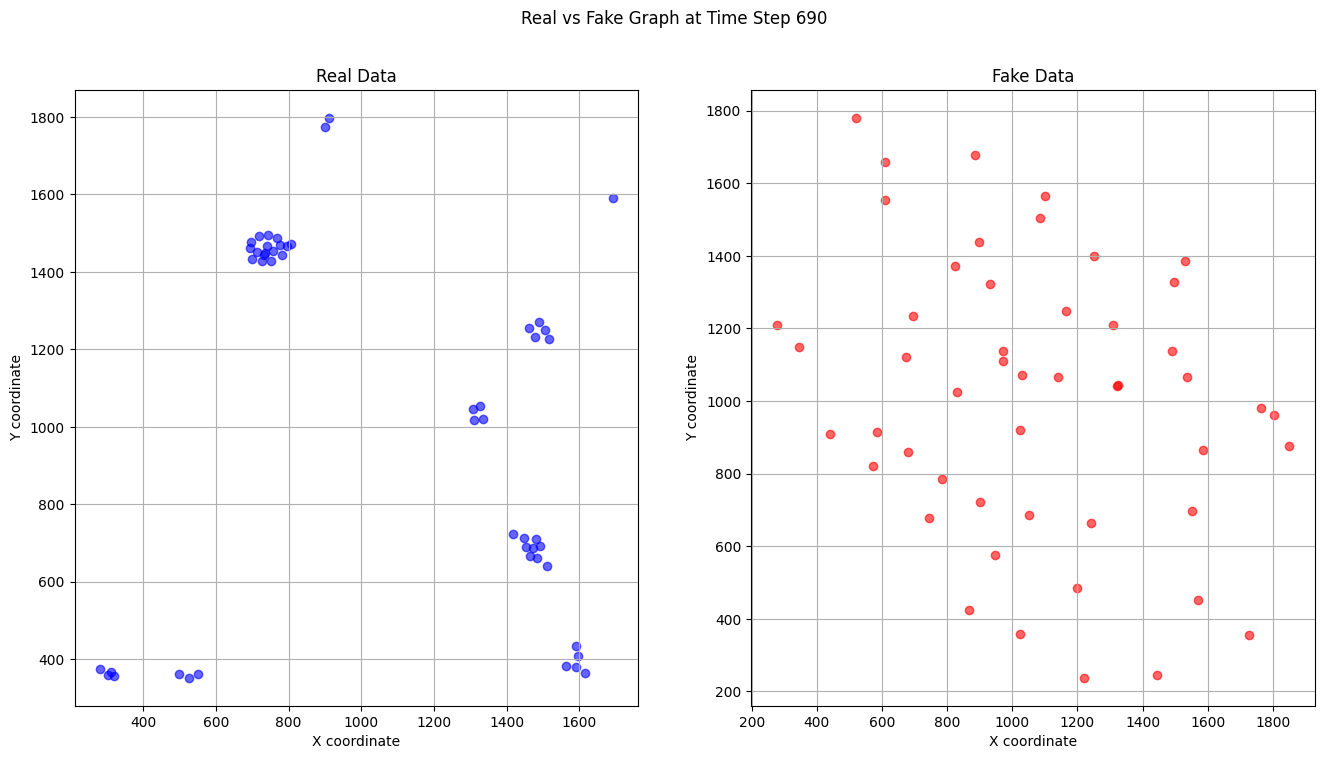

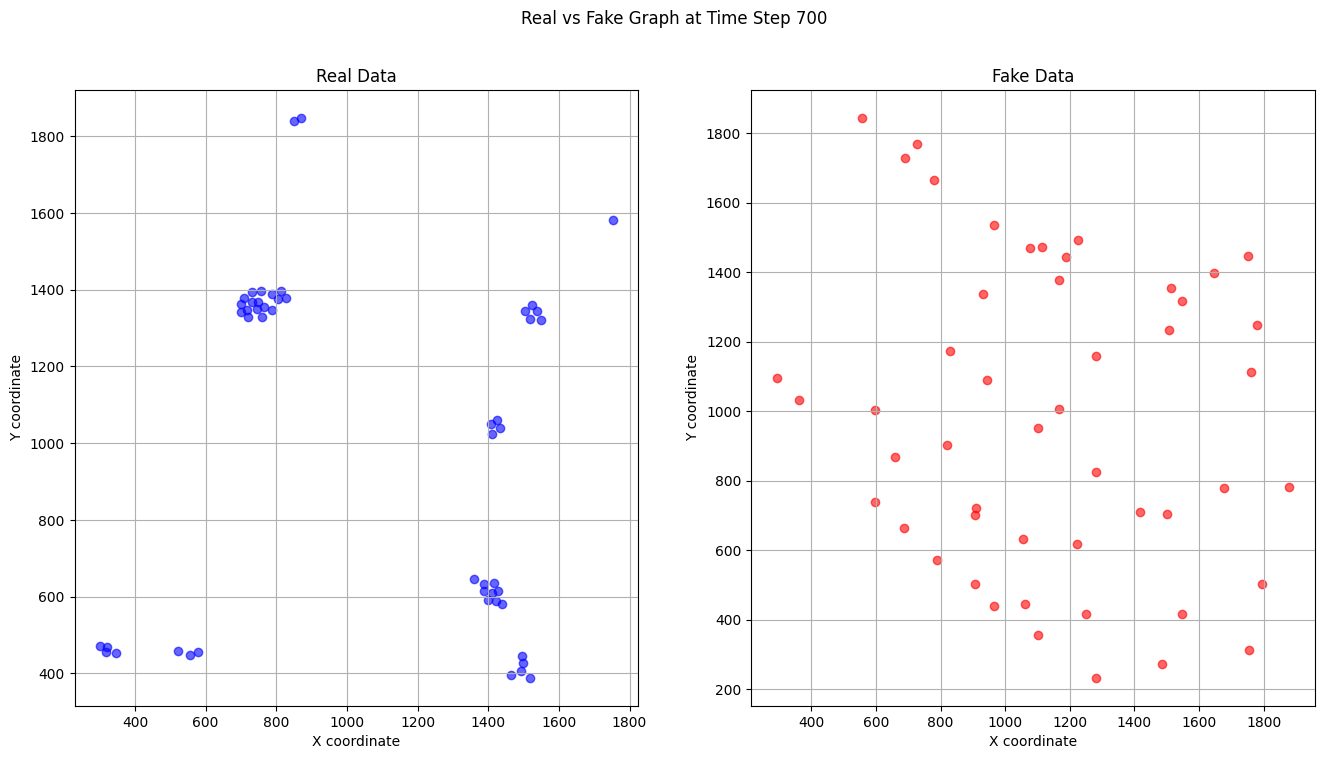

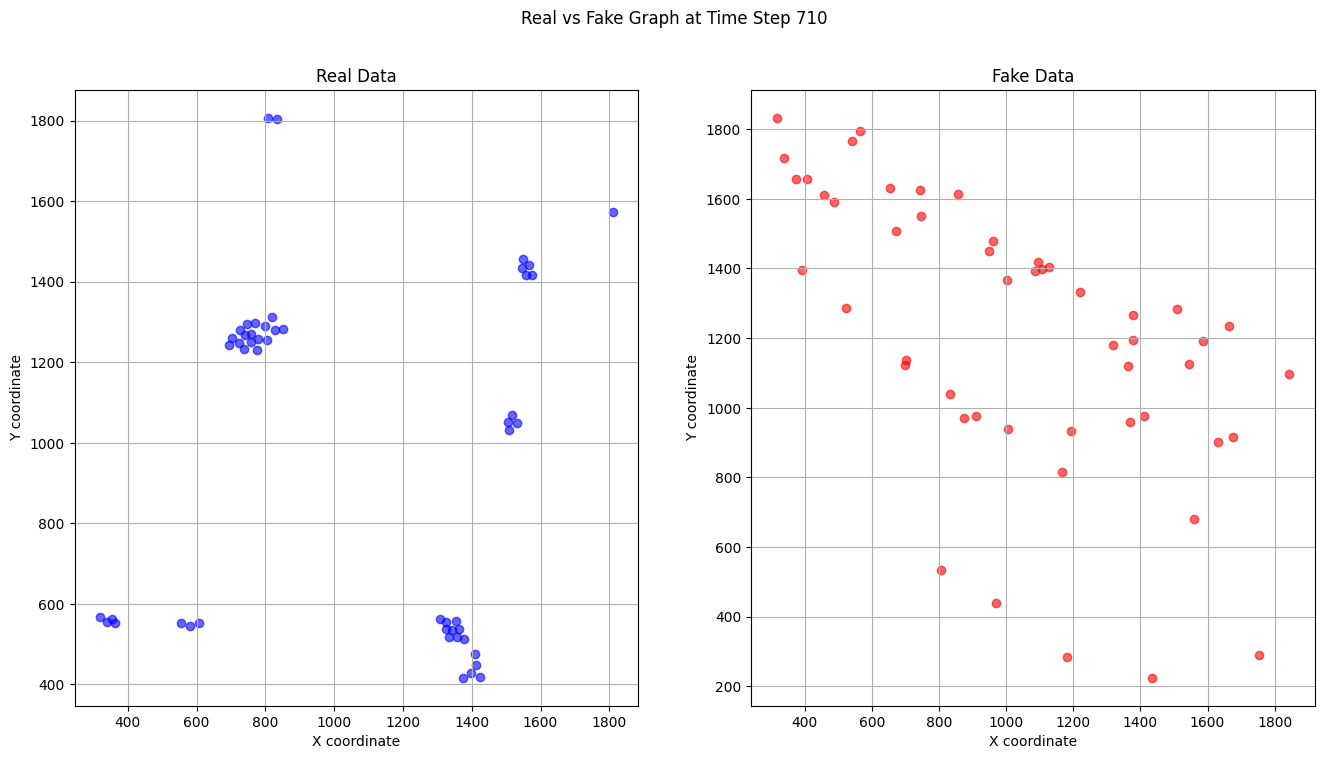

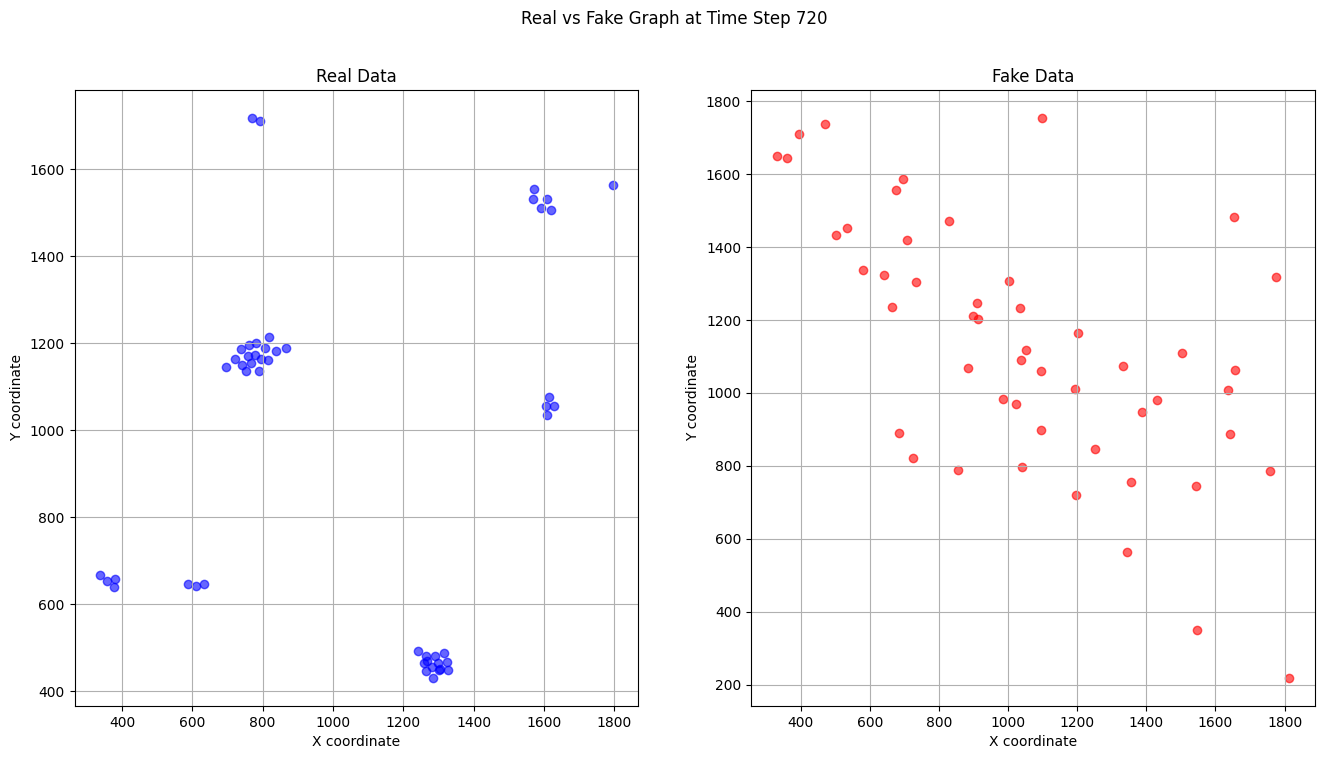

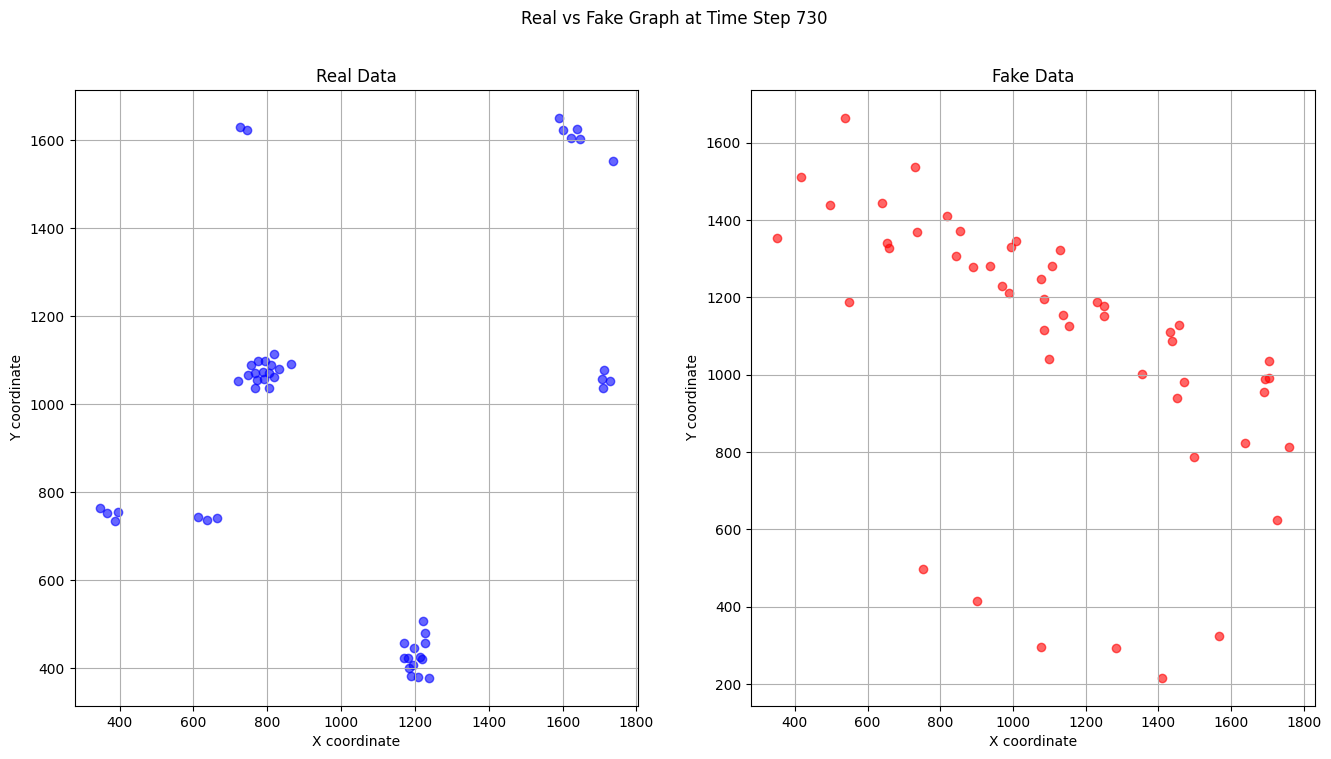

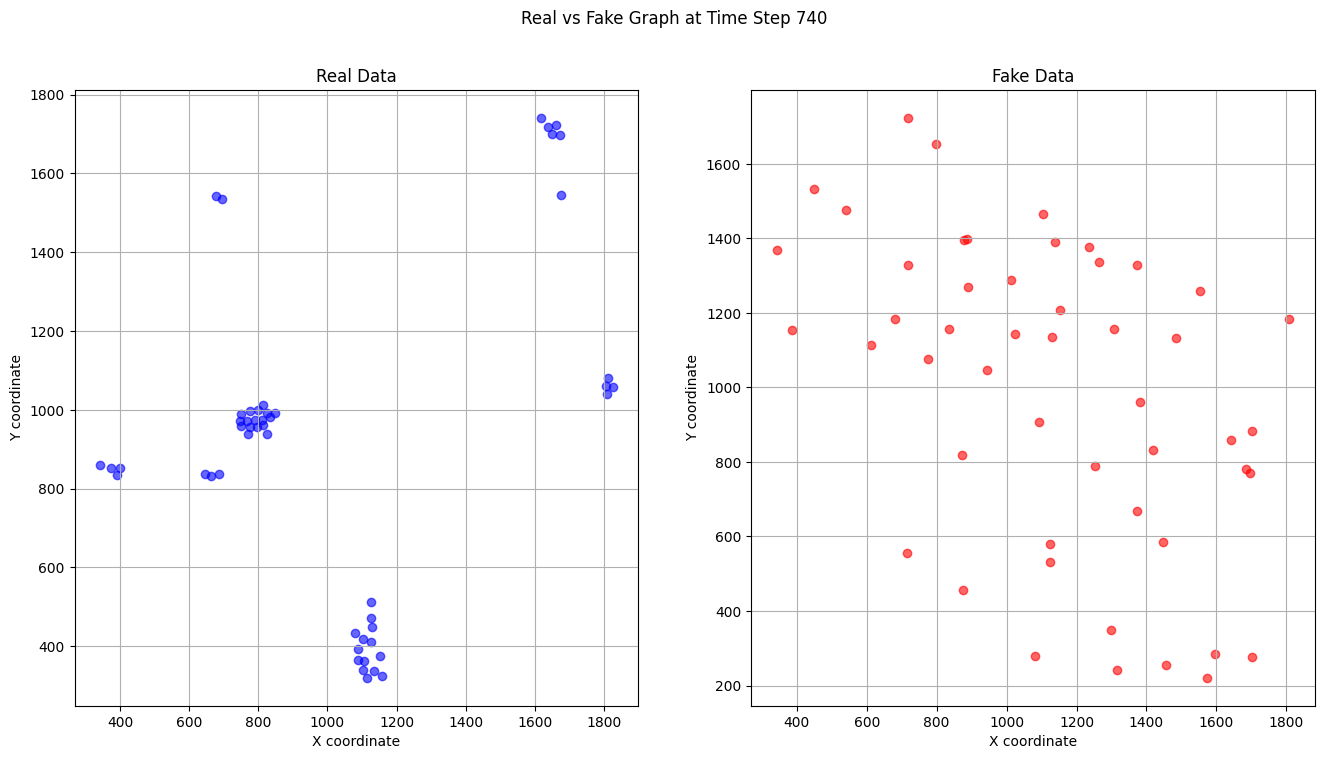

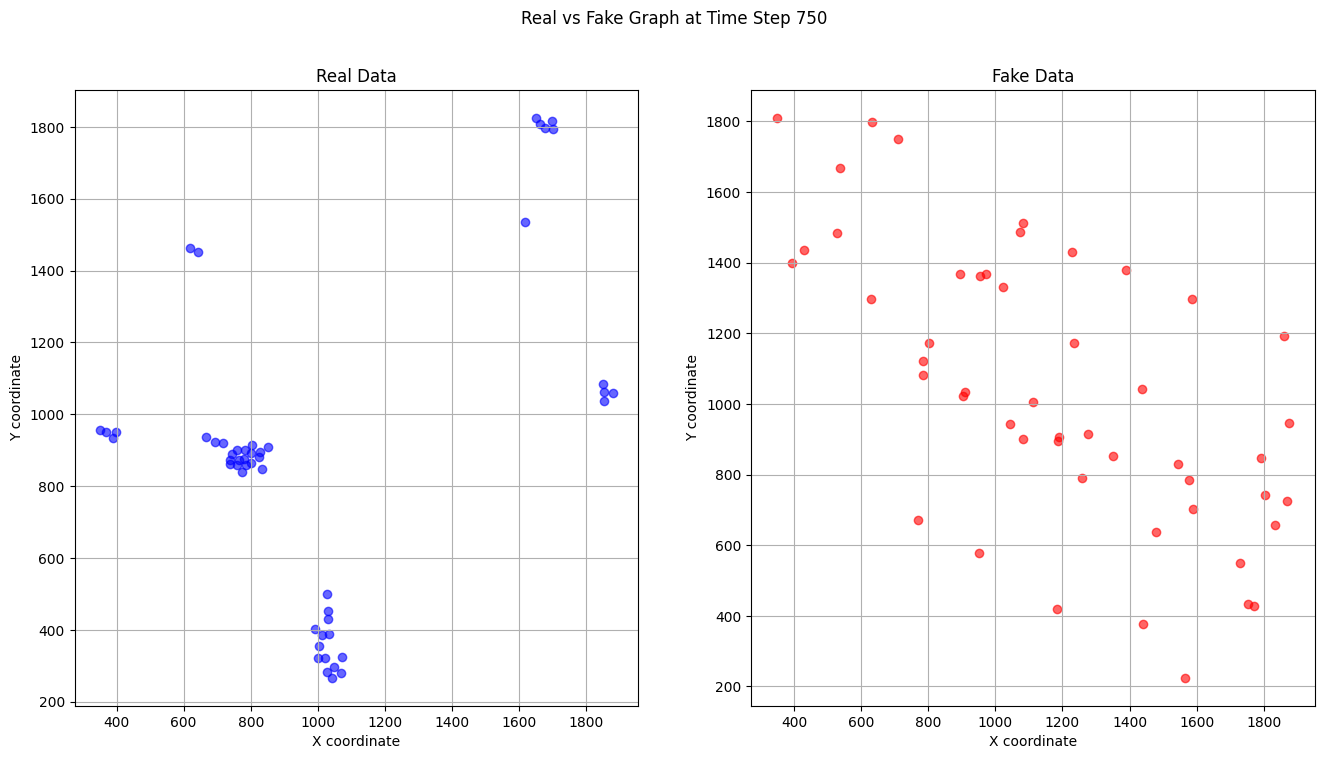

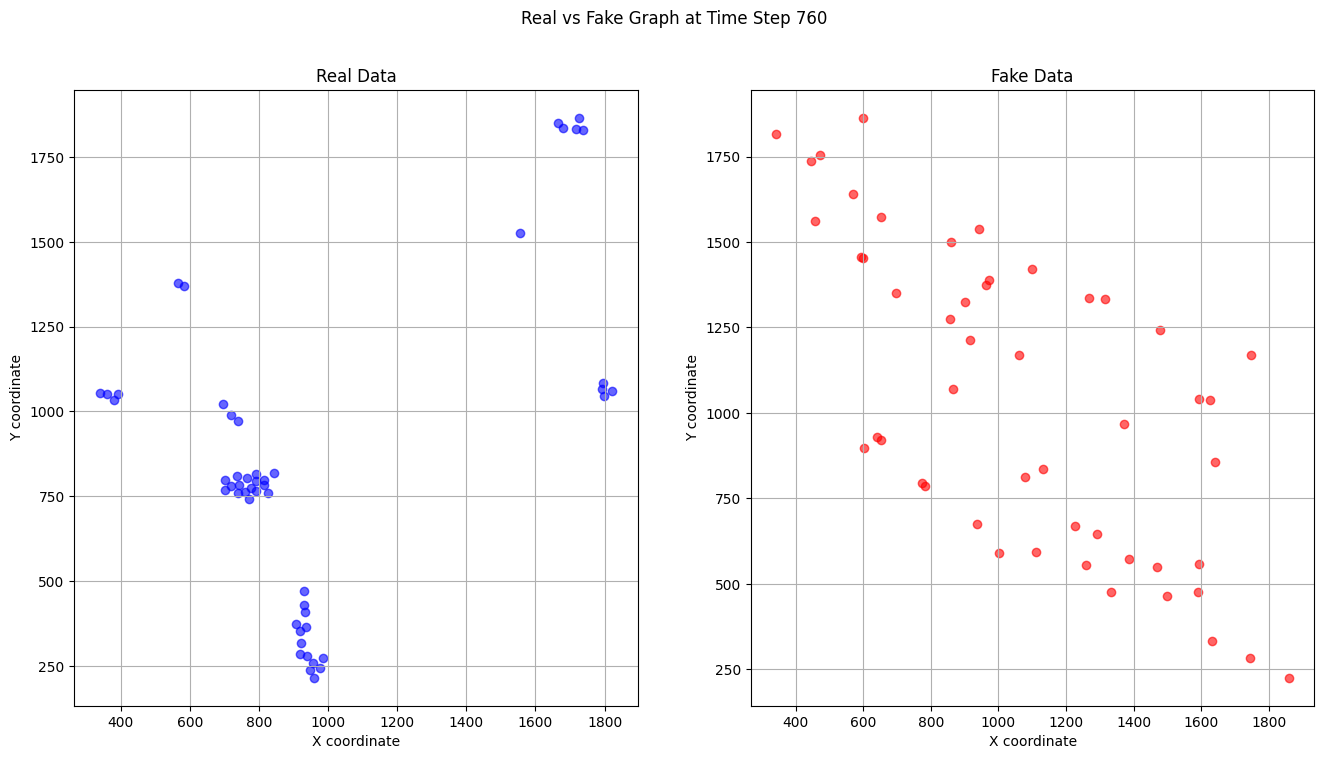

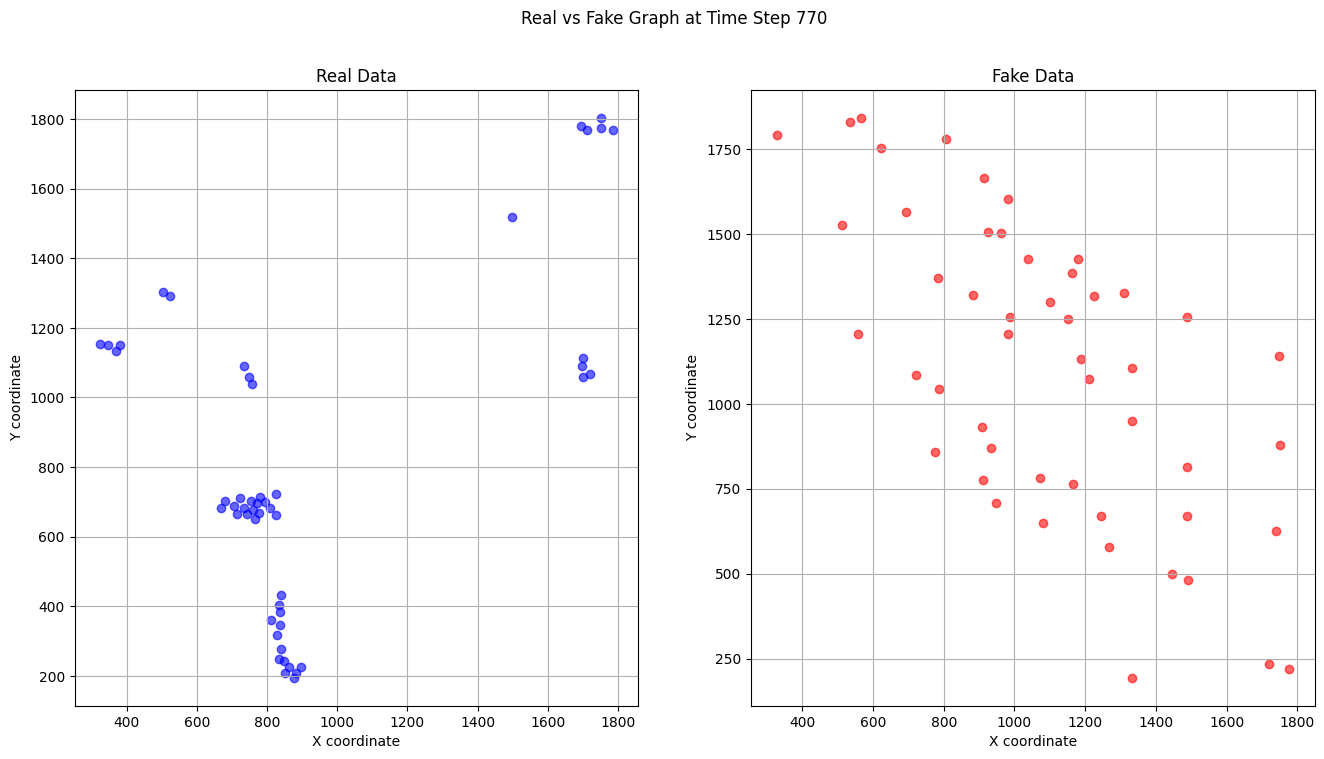

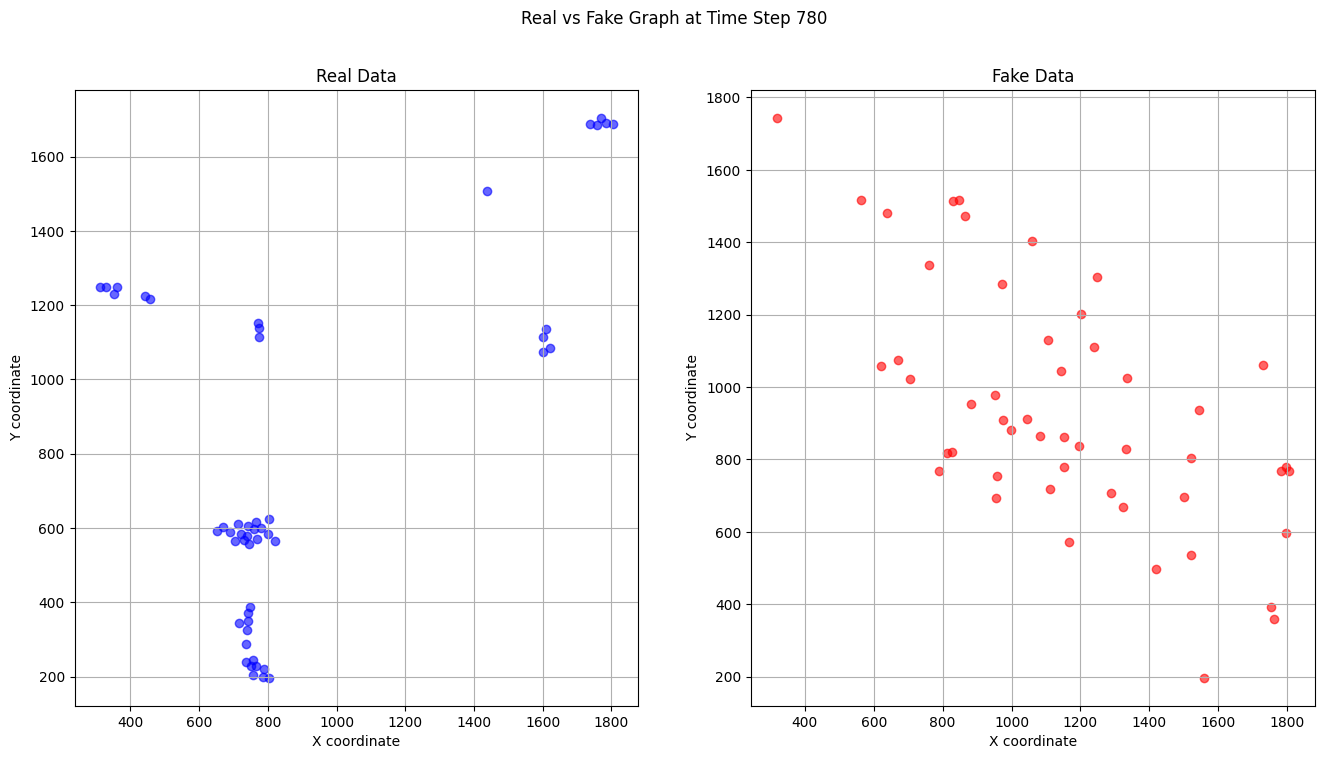

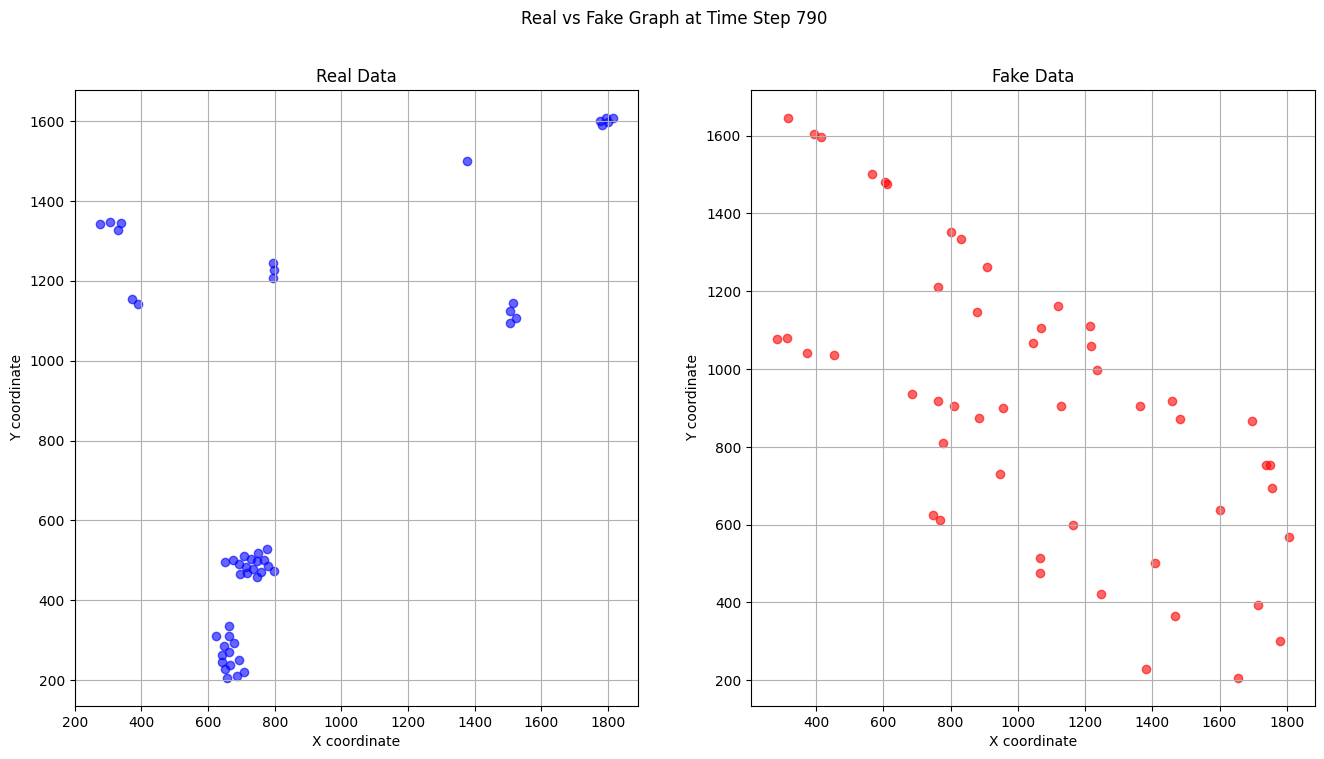

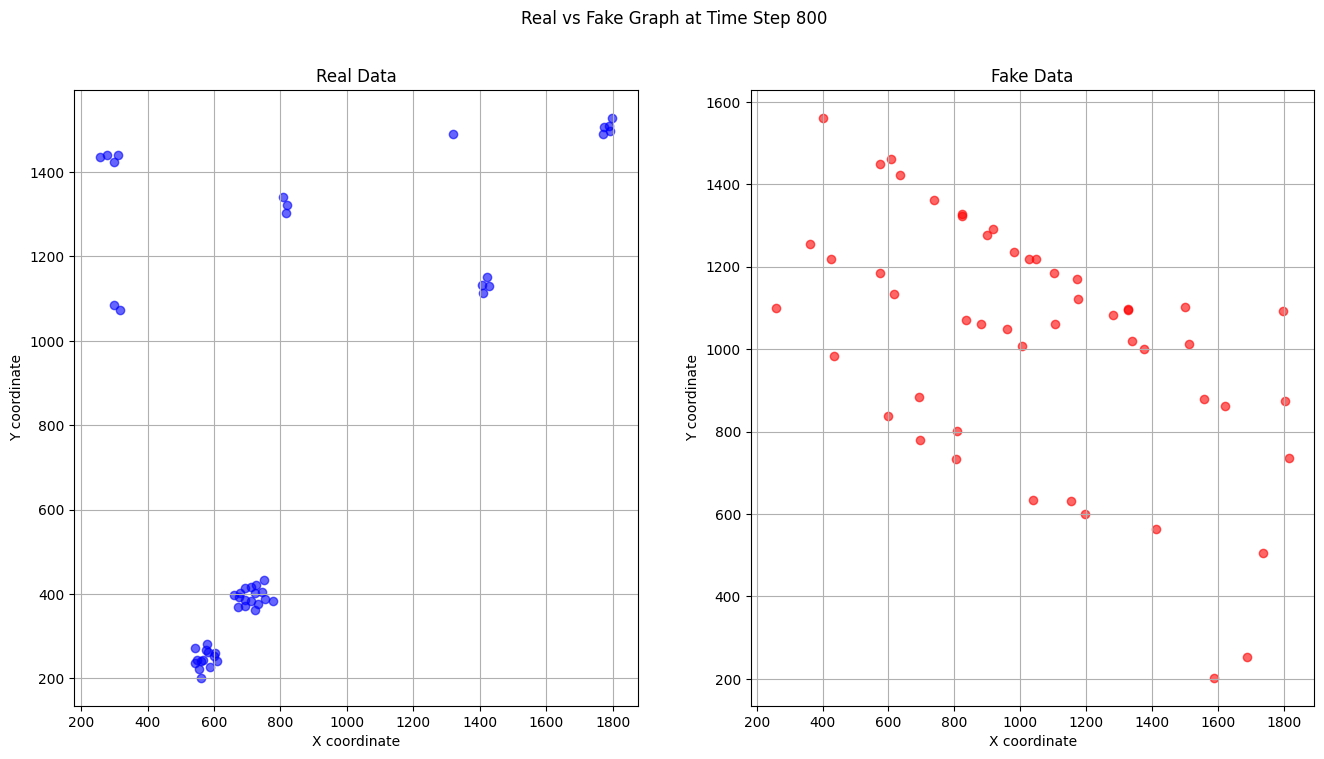

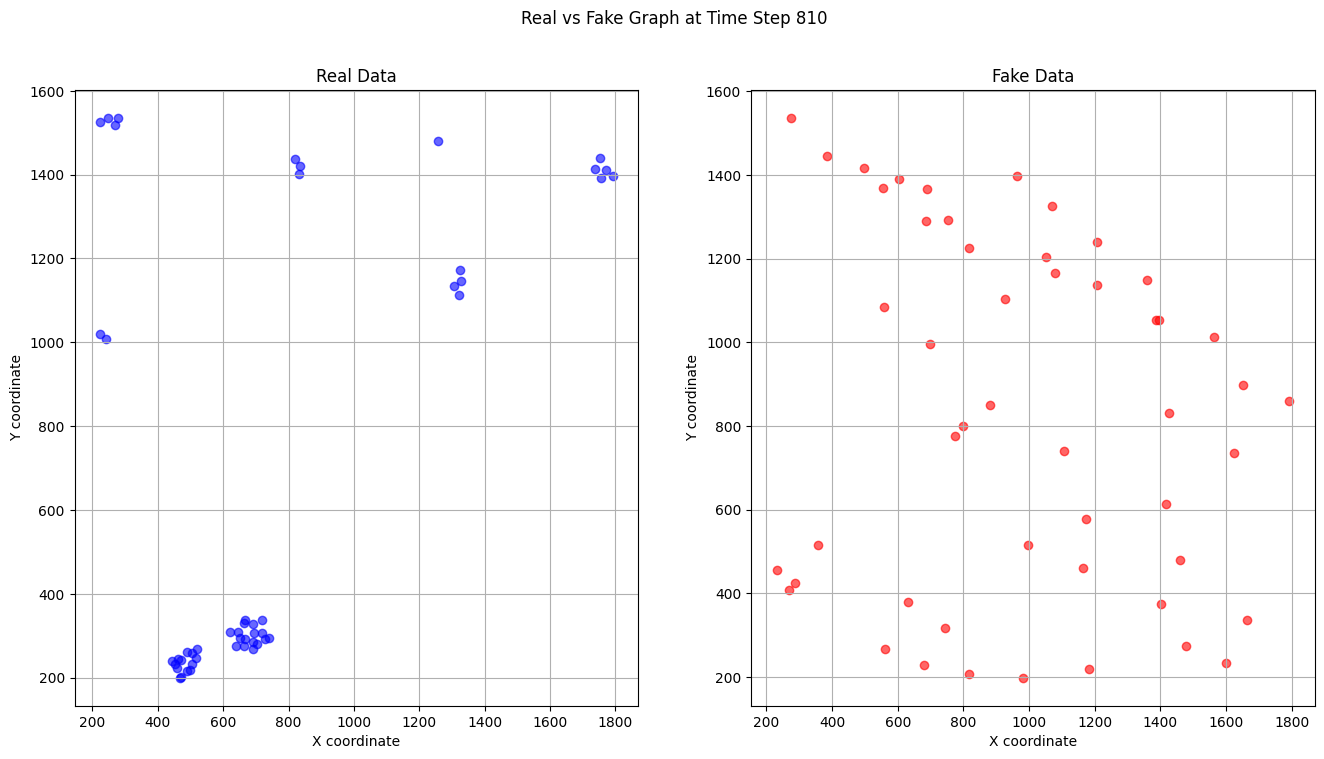

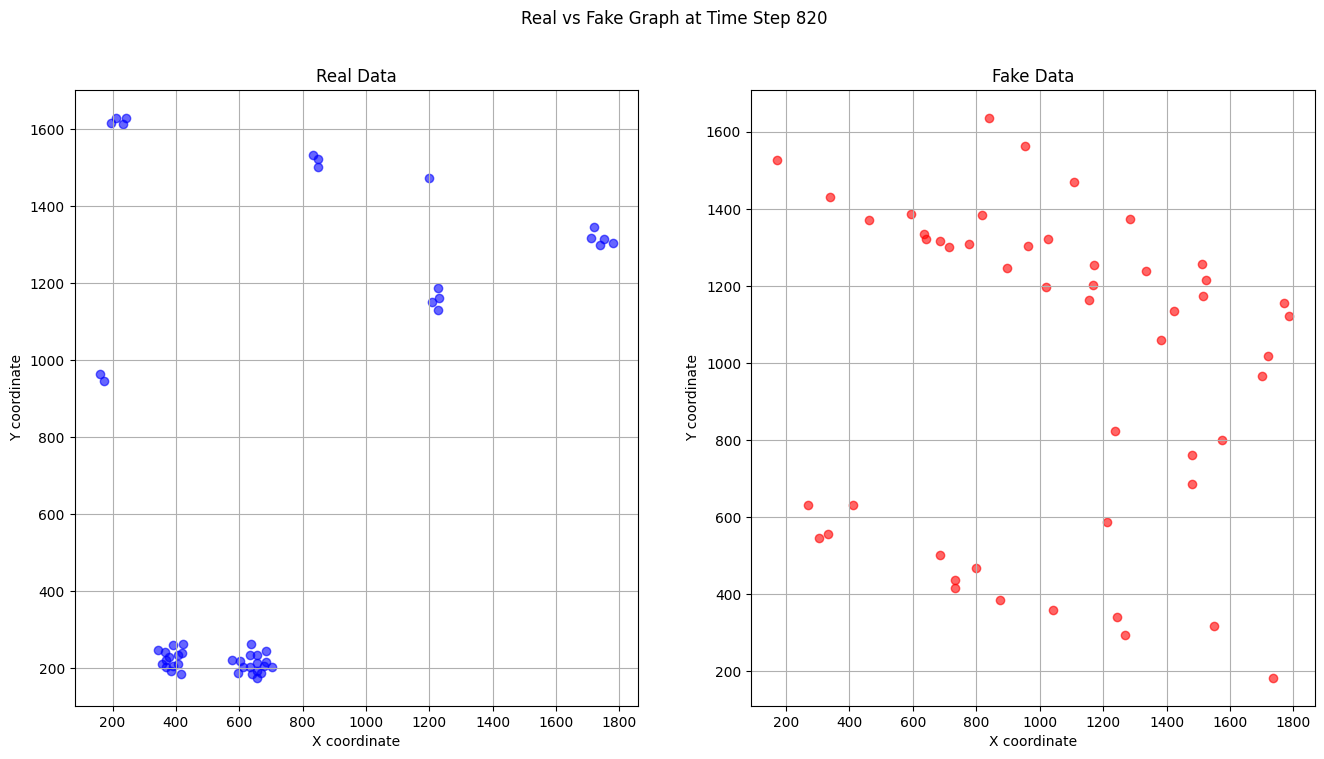

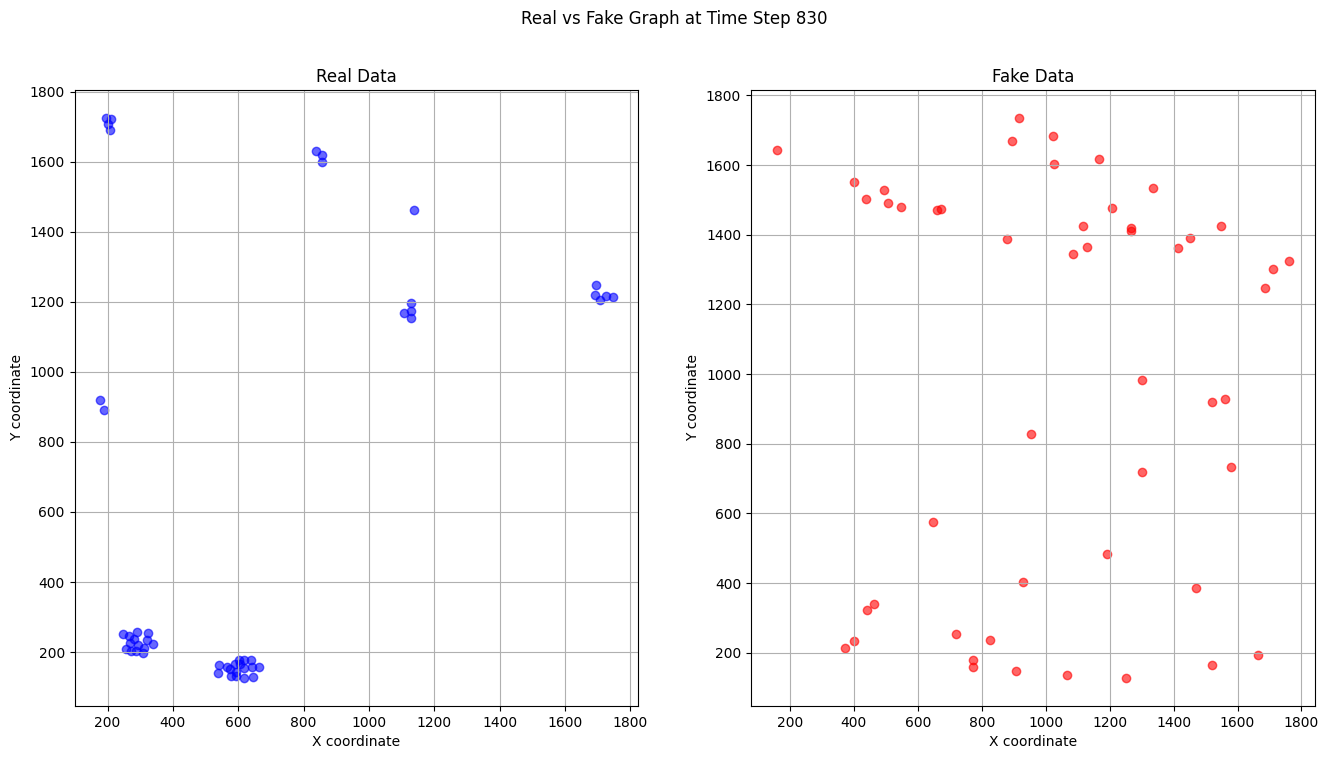

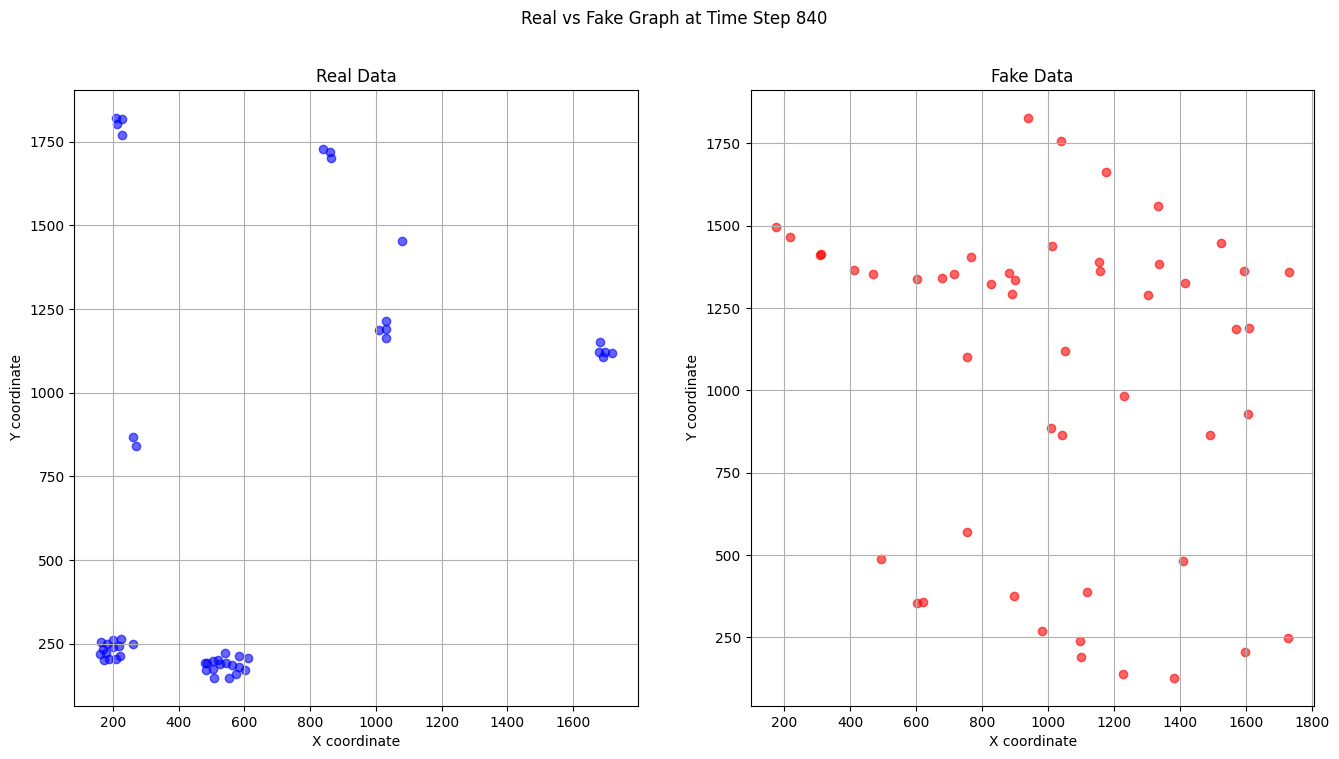

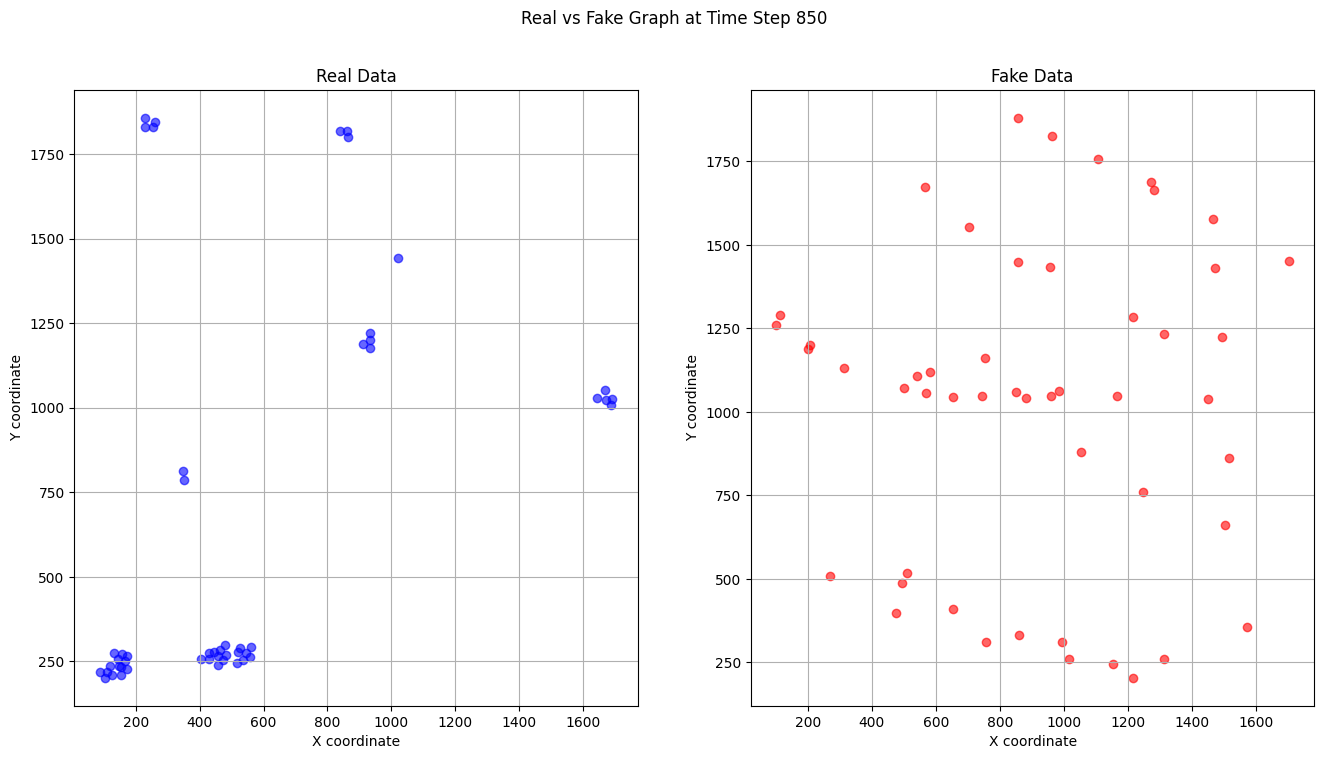

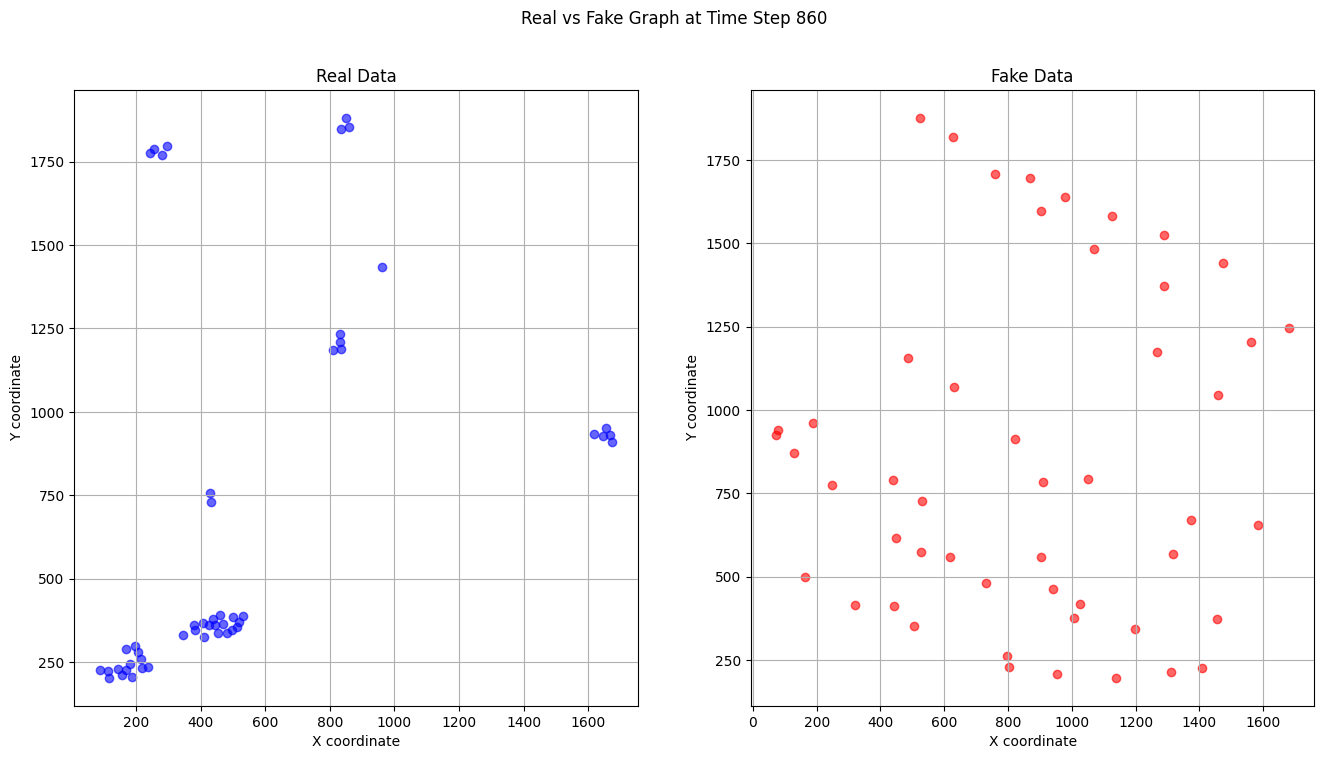

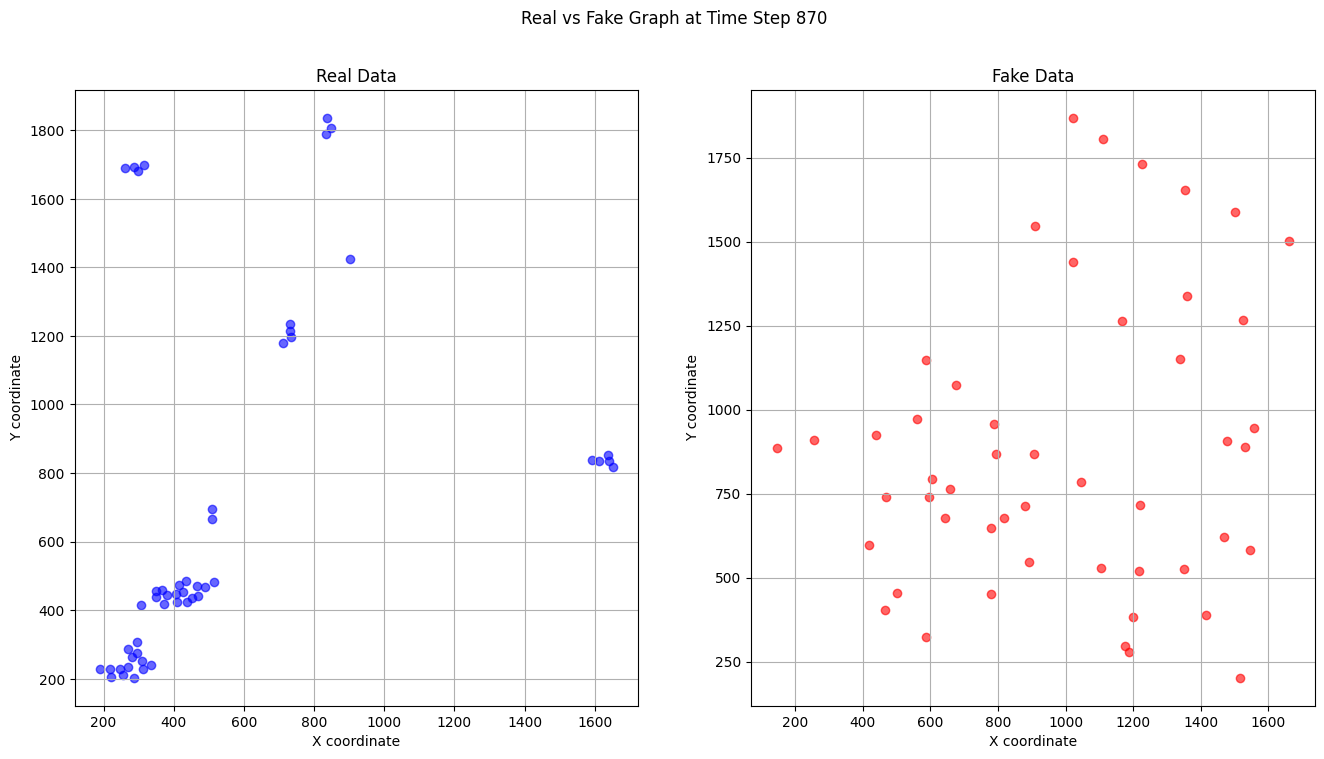

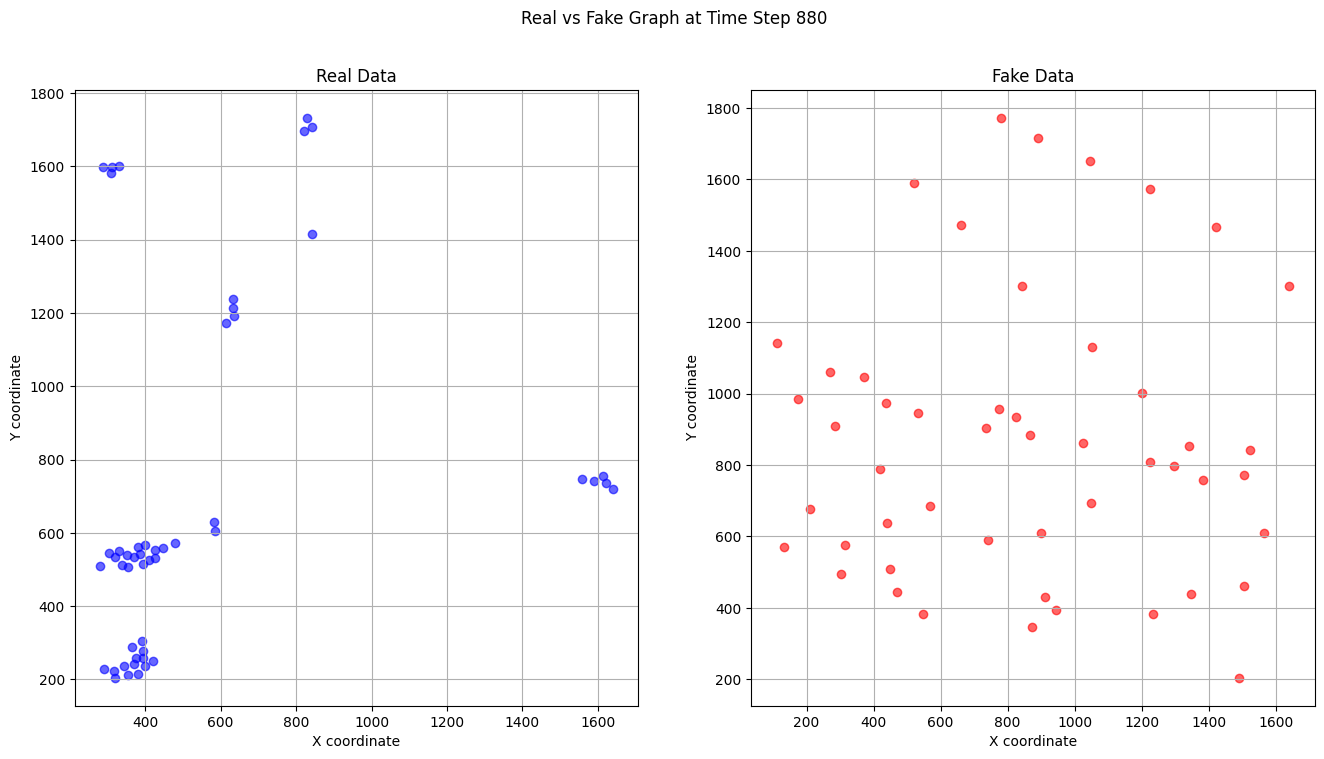

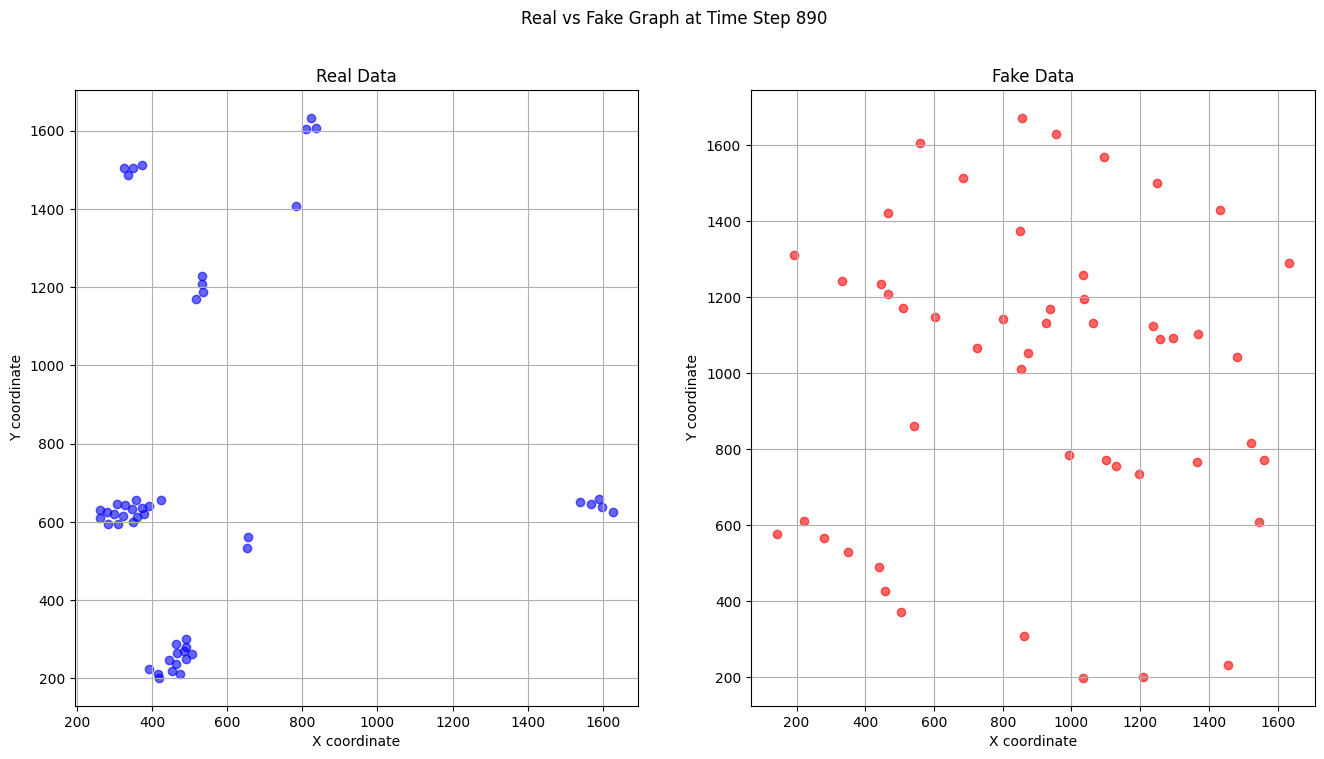

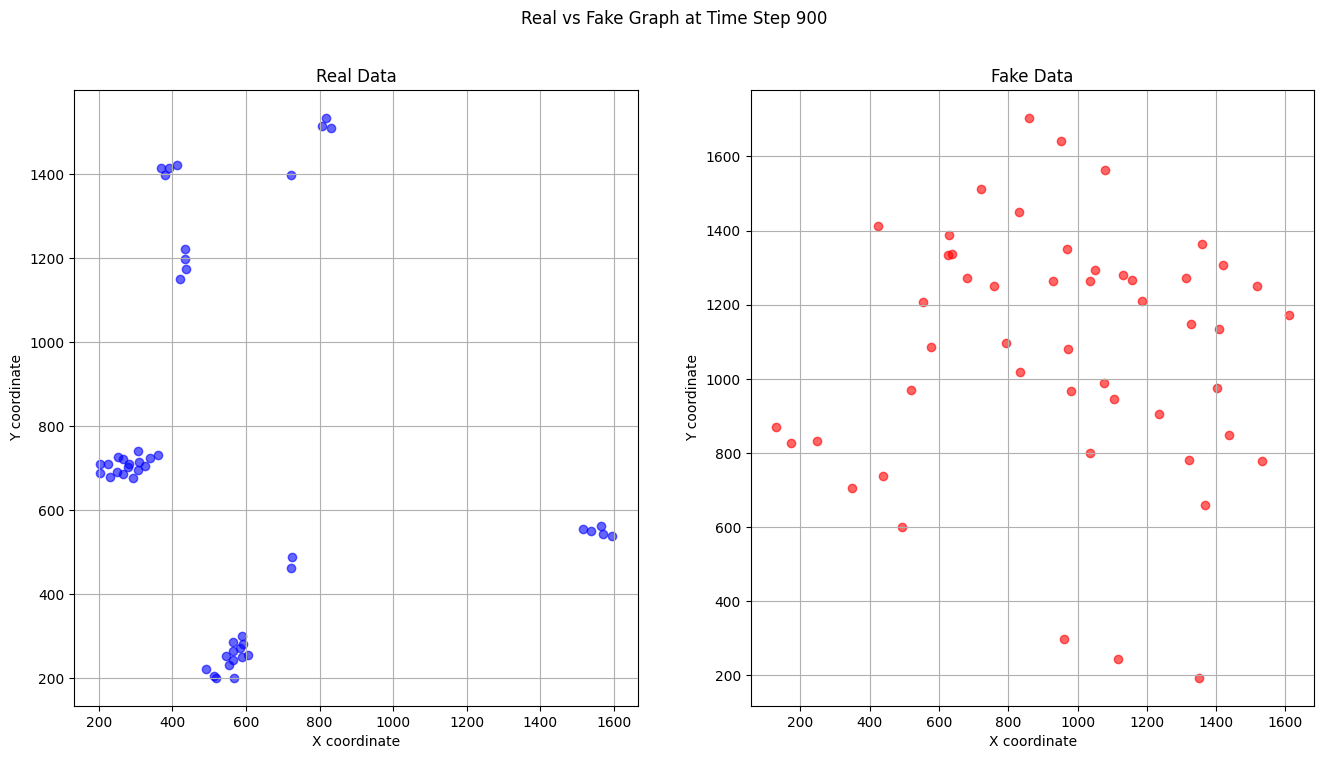

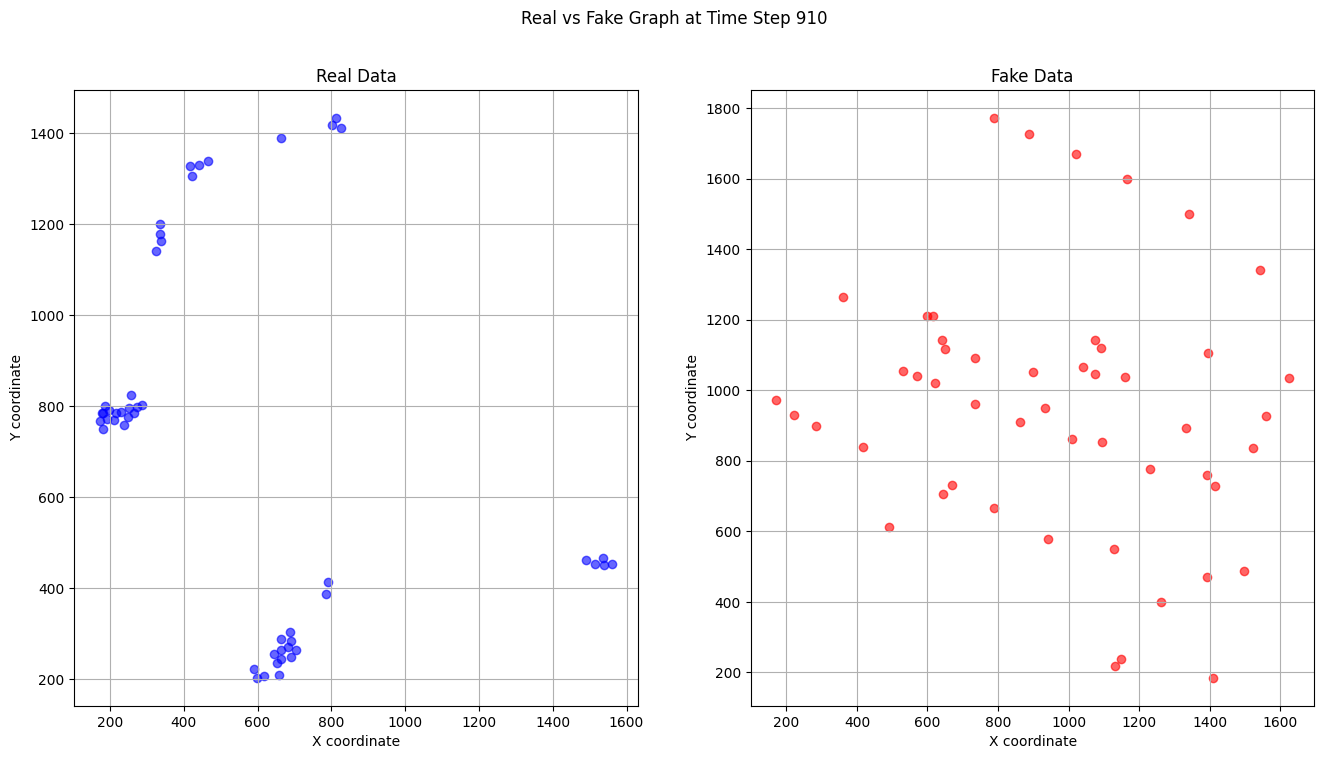

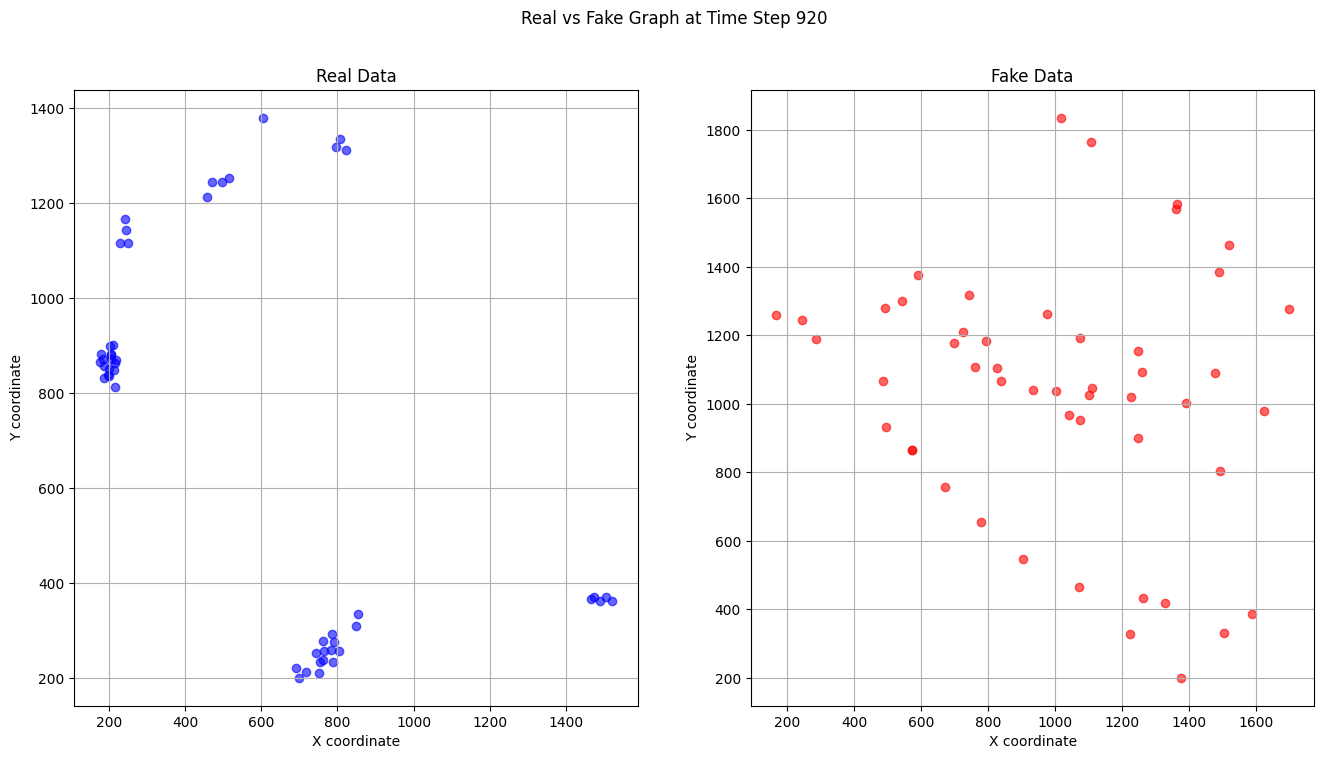

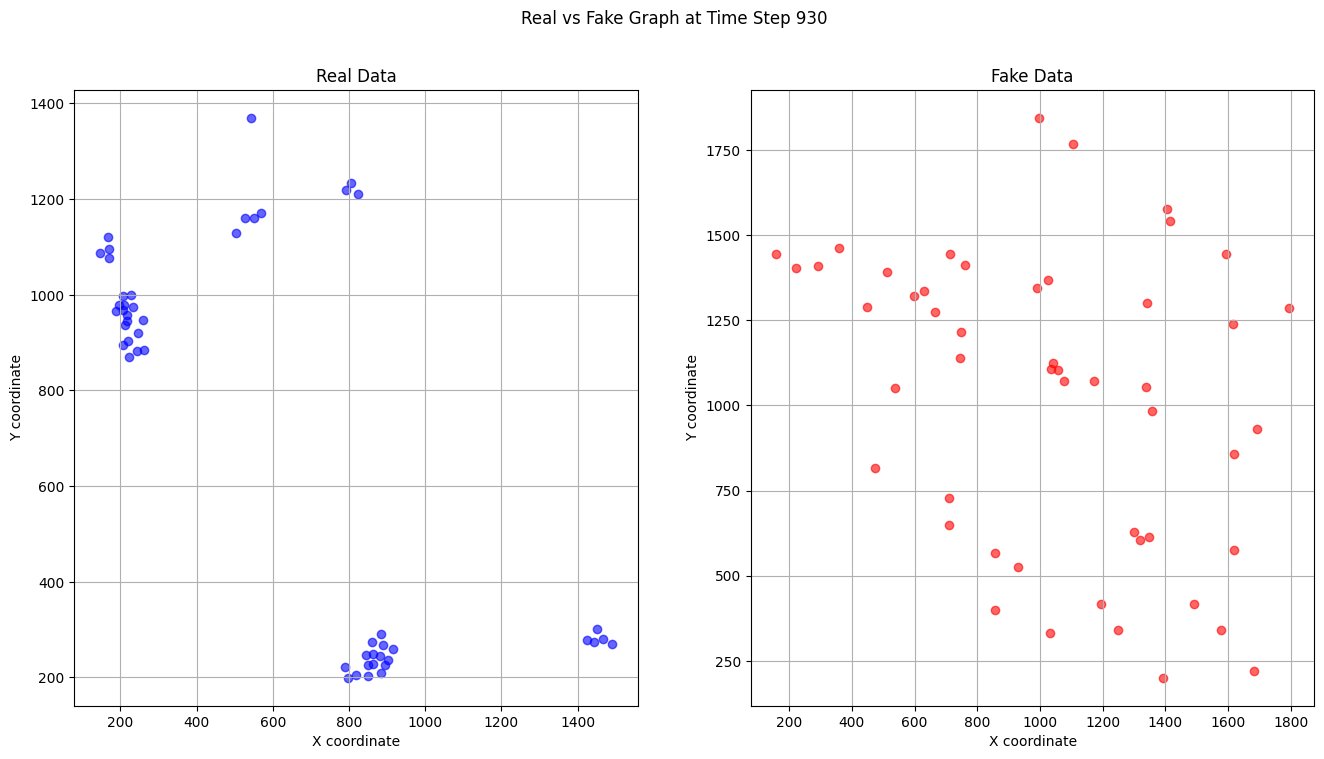

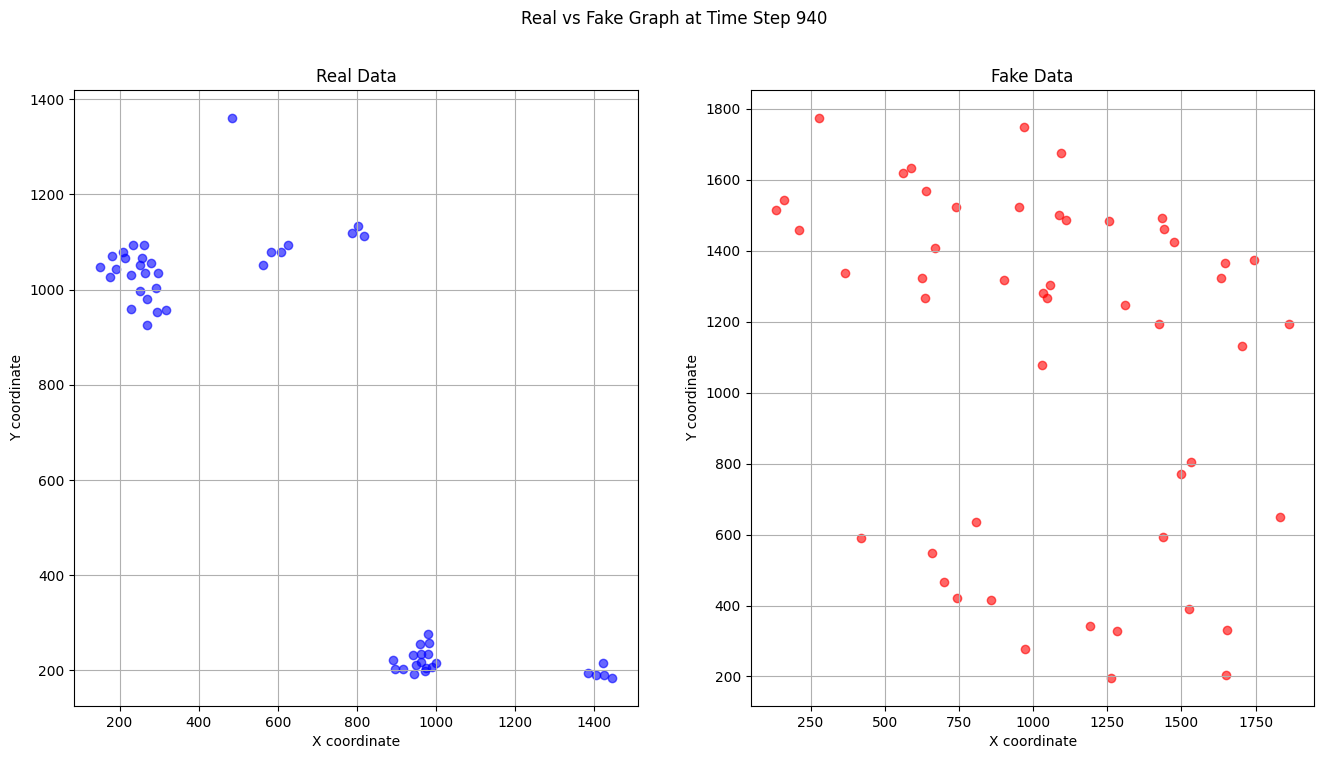

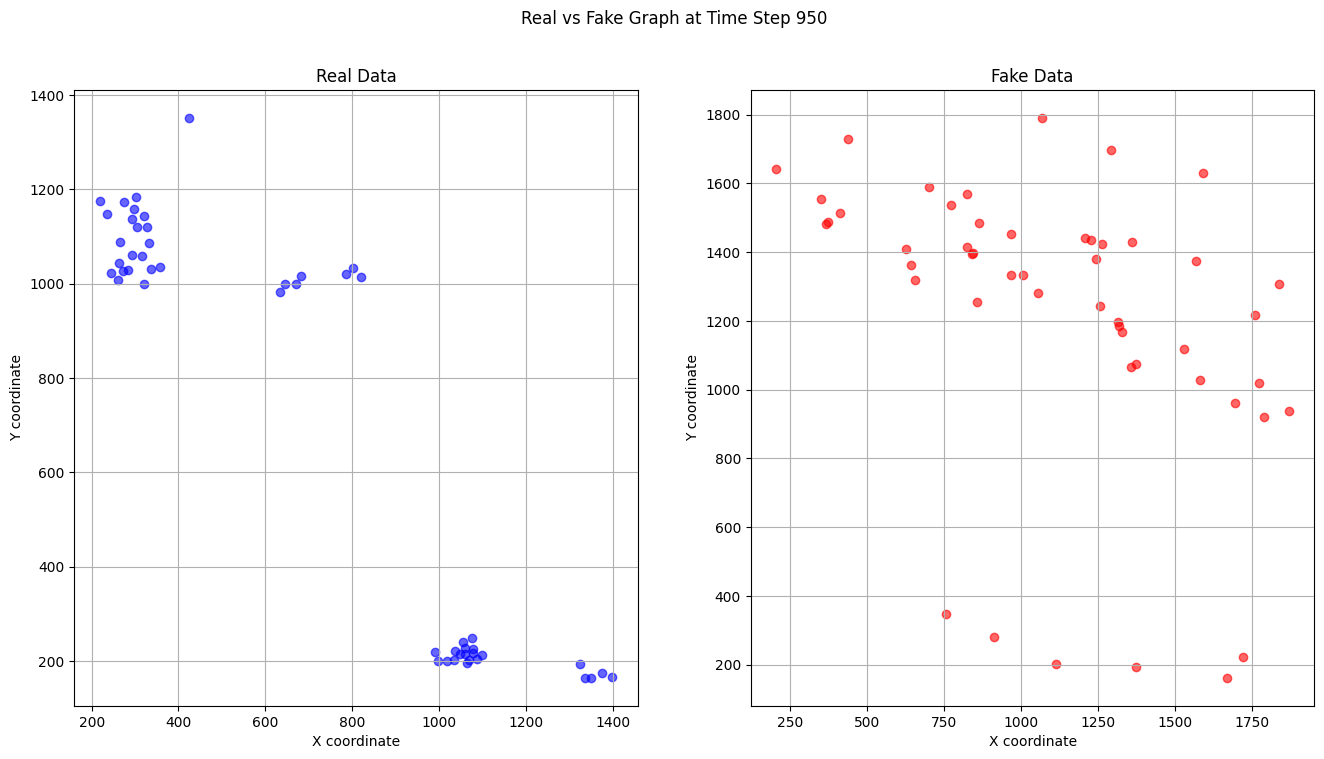

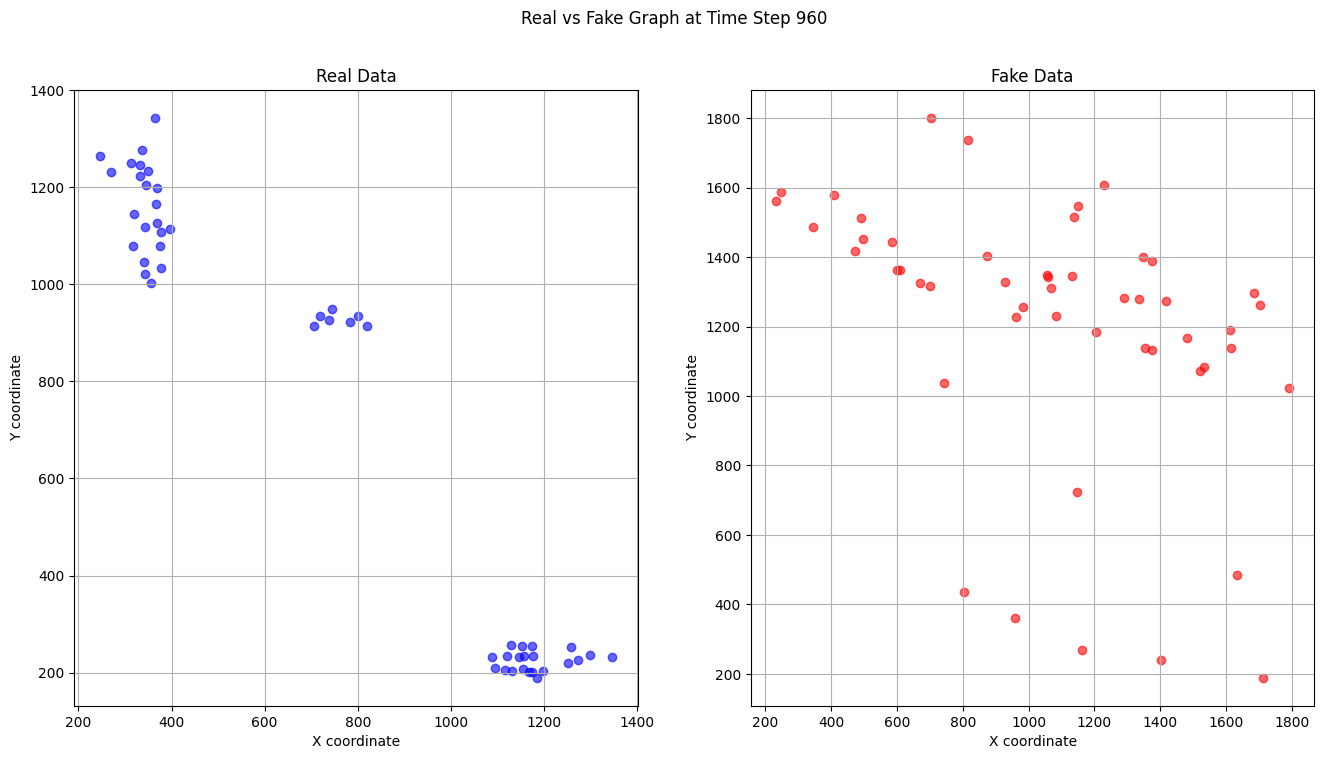

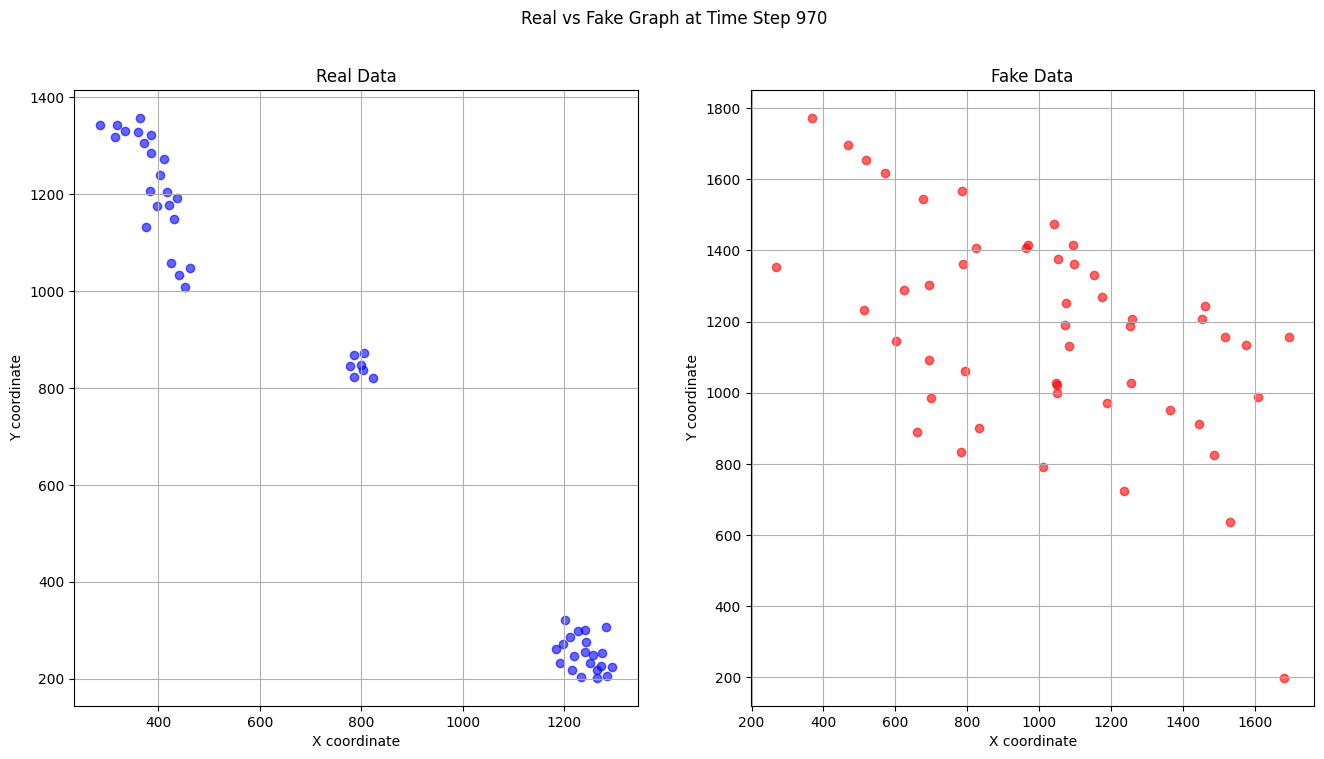

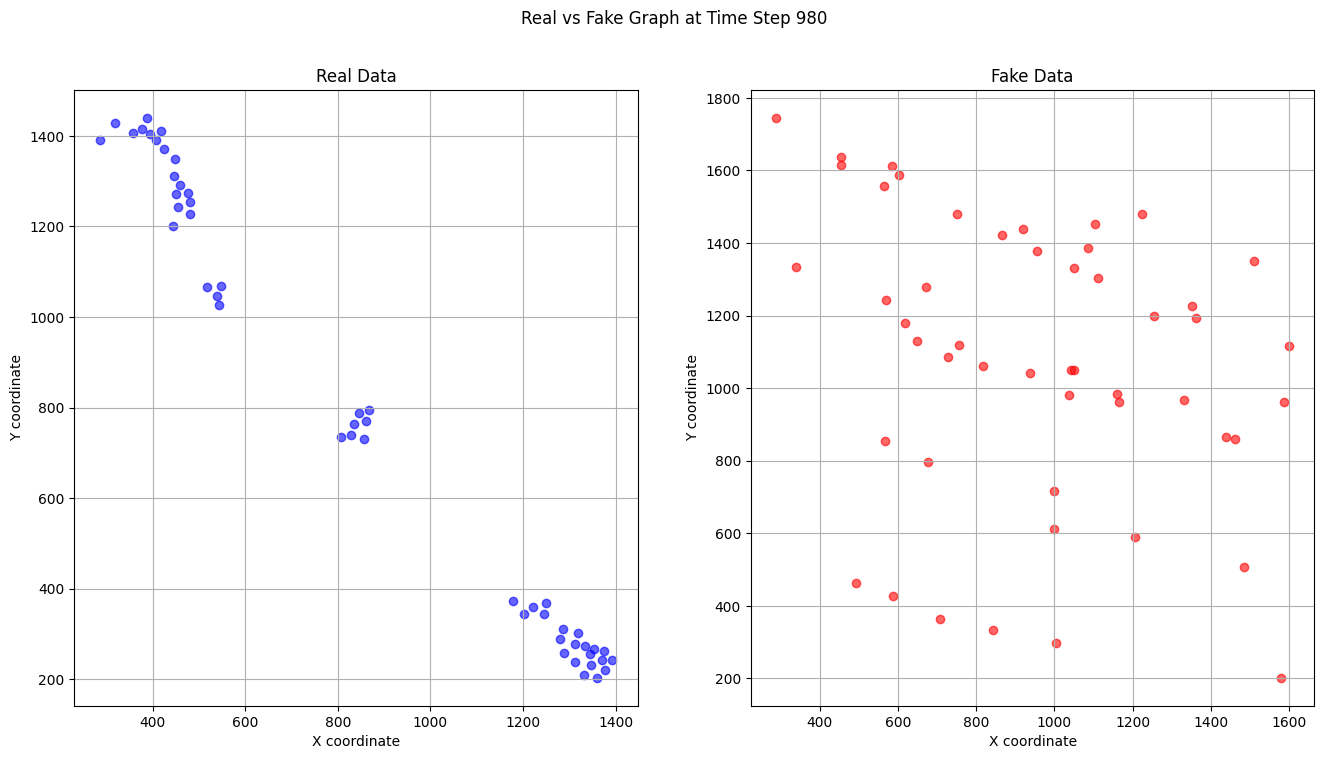

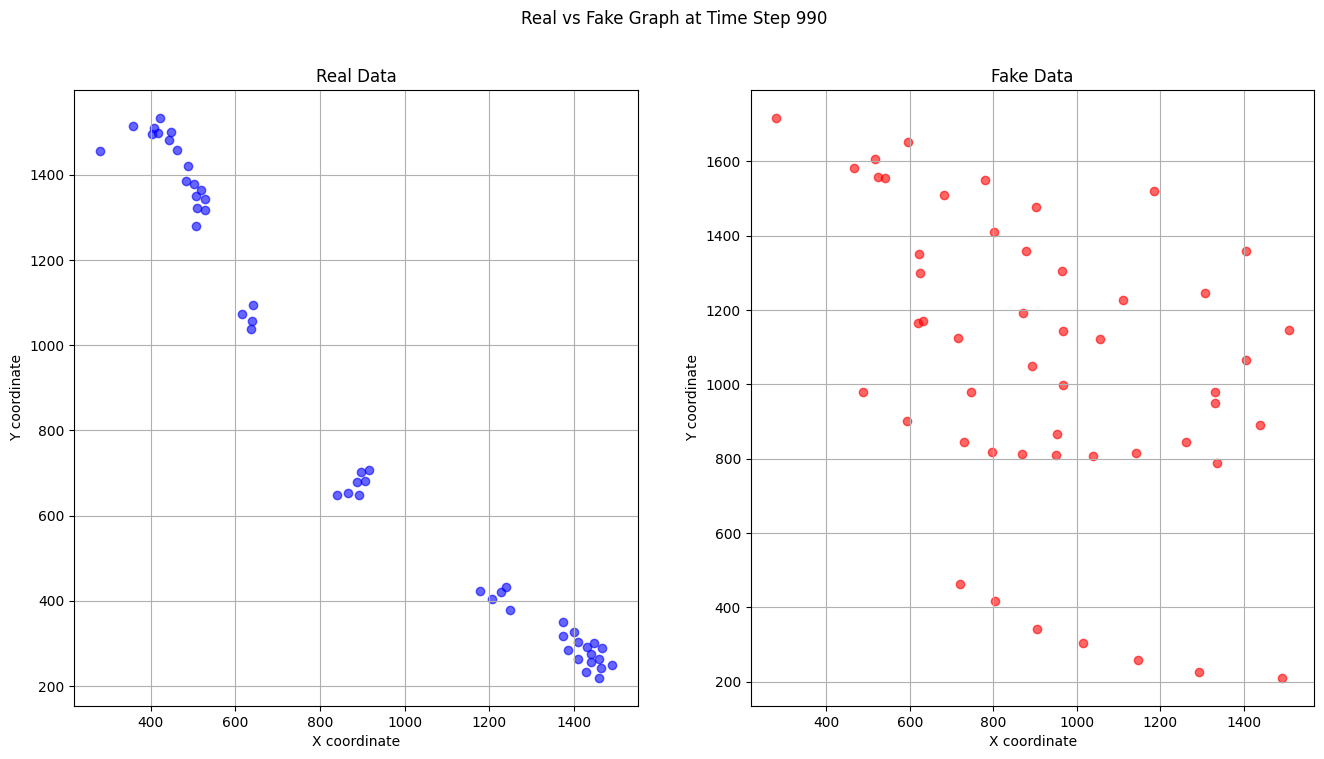

In [612]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from tqdm import tqdm

def evaluate_and_plot(dataset, generator_model, discriminator_model, device, plot_interval=10):
    """
    Evaluates the generator model on the dataset and plots real vs. fake graph node features.
    Collects all graphs during evaluation and plots them separately.

    Parameters:
    - dataset: The dataset containing graph sequences.
    - generator_model: The trained graph generator model.
    - discriminator_model: The discriminator model (used to get predictions).
    - device: Device (CPU/GPU) to run the models.
    - plot_interval: Interval at which plots are generated.
    """
    generator_model.eval()
    discriminator_model.eval()
    
    # Collect real and fake graph data
    real_graphs = []
    fake_graphs = []

    with torch.no_grad():
        for idx, (seq, next_graph_of_seq) in tqdm(enumerate(dataset), desc='Evaluating', total=len(dataset)):
            seq = [graph.to(device) for graph in seq]
            real_next_graph_of_seq = next_graph_of_seq.to(device)

            # Generate fake graph data
            fake_graph_node_feats = generator_model(seq)
            edge_index = get_edges_tensor(fake_graph_node_feats, threshold=75)
            fake_next_graph_of_seq = Data(x=fake_graph_node_feats, edge_index=edge_index).to(device)

            # Store graphs
            real_graphs.append(real_next_graph_of_seq)
            fake_graphs.append(fake_next_graph_of_seq)

    # Plot results
    num_graphs = len(real_graphs)
    for i in range(0, num_graphs, plot_interval):
        real_graph = real_graphs[i]
        fake_graph = fake_graphs[i]
        plot_graphs_side_by_side(real_graph, fake_graph, title=f'Real vs Fake Graph at Time Step {i}')

def plot_graphs_side_by_side(real_graph, fake_graph, title='Graph Visualization'):
    """
    Plots the nodes of real and fake graphs side by side on separate scatter plots.

    Parameters:
    - real_graph: torch_geometric.data.Data object containing the real graph data.
    - fake_graph: torch_geometric.data.Data object containing the generated graph data.
    - title: Title of the plot.
    """
    # Extract node features
    real_node_feats = real_graph.x.cpu().numpy()
    fake_node_feats = fake_graph.x.cpu().numpy()

    # Extract x and y coordinates
    real_x = real_node_feats[:, 0]
    real_y = real_node_feats[:, 1]
    fake_x = fake_node_feats[:, 0]
    fake_y = fake_node_feats[:, 1]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Plot real data
    axs[0].scatter(real_x, real_y, c='blue', label='Real Data', alpha=0.6)
    axs[0].set_title('Real Data')
    axs[0].set_xlabel('X coordinate')
    axs[0].set_ylabel('Y coordinate')
    axs[0].grid(True)

    # Plot fake data
    axs[1].scatter(fake_x, fake_y, c='red', label='Fake Data', alpha=0.6)
    axs[1].set_title('Fake Data')
    axs[1].set_xlabel('X coordinate')
    axs[1].set_ylabel('Y coordinate')
    axs[1].grid(True)

    # Set the overall title and show the plot
    plt.suptitle(title)
    plt.show()

# Example usage
device = torch.device('cpu')

# Evaluate and plot with a plot interval of 10
evaluate_and_plot(dataset, generator_model, discriminator_model, device, plot_interval=10)


Evaluating: 100%|██████████| 996/996 [00:22<00:00, 44.75it/s]


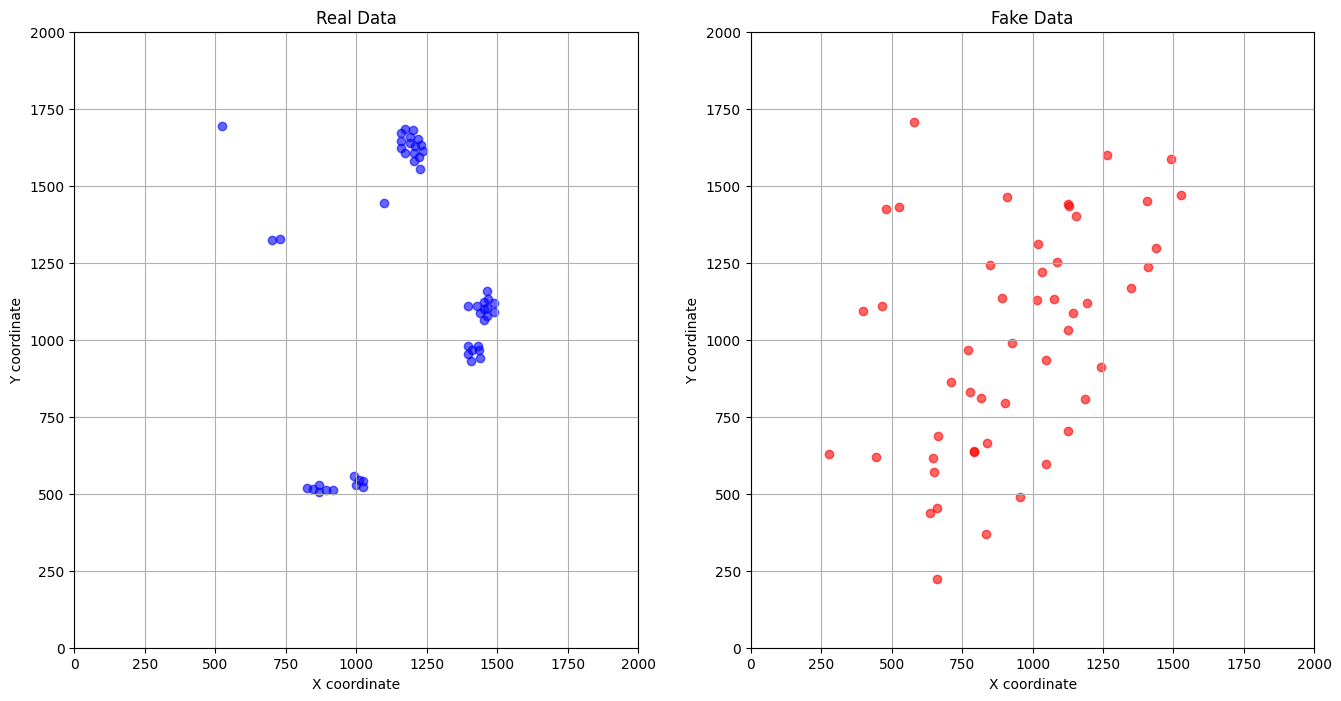

In [619]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from tqdm import tqdm
import matplotlib.animation as animation

def evaluate_and_plot(dataset, generator_model, discriminator_model, device, plot_interval=10):
    """
    Evaluates the generator model on the dataset and plots real vs. fake graph node features.
    Collects all graphs during evaluation and plots them separately.

    Parameters:
    - dataset: The dataset containing graph sequences.
    - generator_model: The trained graph generator model.
    - discriminator_model: The discriminator model (used to get predictions).
    - device: Device (CPU/GPU) to run the models.
    - plot_interval: Interval at which plots are generated.
    """
    generator_model.eval()
    discriminator_model.eval()

    # Collect real and fake graph data
    real_graphs = []
    fake_graphs = []

    with torch.no_grad():
        for idx, (seq, next_graph_of_seq) in tqdm(enumerate(dataset), desc='Evaluating', total=len(dataset)):
            seq = [graph.to(device) for graph in seq]
            real_next_graph_of_seq = next_graph_of_seq.to(device)

            # Generate fake graph data
            fake_graph_node_feats = generator_model(seq)
            edge_index = get_edges_tensor(fake_graph_node_feats, threshold=75)
            fake_next_graph_of_seq = Data(x=fake_graph_node_feats, edge_index=edge_index).to(device)

            # Store graphs
            real_graphs.append(real_next_graph_of_seq)
            fake_graphs.append(fake_next_graph_of_seq)

    # Animate results
    animate_graphs(real_graphs, fake_graphs, plot_interval=plot_interval)

def animate_graphs(real_graphs, fake_graphs, plot_interval=1):
    """
    Animates the nodes of real and fake graphs side by side on separate scatter plots.

    Parameters:
    - real_graphs: List of torch_geometric.data.Data objects containing the real graph data.
    - fake_graphs: List of torch_geometric.data.Data objects containing the generated graph data.
    - plot_interval: Interval at which plots are generated.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    def init():
        for ax in axs:
            ax.clear()
            ax.set_xlim(0, 2000)
            ax.set_ylim(0,2000)
            ax.grid(True)
        axs[0].set_title('Real Data')
        axs[0].set_xlabel('X coordinate')
        axs[0].set_ylabel('Y coordinate')
        axs[1].set_title('Fake Data')
        axs[1].set_xlabel('X coordinate')
        axs[1].set_ylabel('Y coordinate')

    def update(frame):
        real_graph = real_graphs[frame]
        fake_graph = fake_graphs[frame]

        real_node_feats = real_graph.x.cpu().numpy()
        fake_node_feats = fake_graph.x.cpu().numpy()

        real_x = real_node_feats[:, 0]
        real_y = real_node_feats[:, 1]
        fake_x = fake_node_feats[:, 0]
        fake_y = fake_node_feats[:, 1]

        axs[0].clear()
        axs[1].clear()

        axs[0].scatter(real_x, real_y, c='blue', label='Real Data', alpha=0.6)
        axs[1].scatter(fake_x, fake_y, c='red', label='Fake Data', alpha=0.6)

        for ax in axs:
            ax.set_xlim(0, 2000)
            ax.set_ylim(0, 2000)
            ax.grid(True)
        axs[0].set_title('Real Data')
        axs[0].set_xlabel('X coordinate')
        axs[0].set_ylabel('Y coordinate')
        axs[1].set_title('Fake Data')
        axs[1].set_xlabel('X coordinate')
        axs[1].set_ylabel('Y coordinate')

    ani = animation.FuncAnimation(fig, update, frames=range(0, len(real_graphs), plot_interval), init_func=init, interval=200)
    ani.save('boid_animation.gif', writer='pillow')
    plt.show()

# Example usage
device = torch.device('cpu')

# Ensure the following functions and variables are defined:
# dataset, generator_model, discriminator_model, get_edges_tensor

# Evaluate and plot with a plot interval of 10
evaluate_and_plot(dataset, generator_model, discriminator_model, device, plot_interval=1)
